In [276]:
%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering


from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import metrics

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')


from itertools import cycle
import networkx as nx



from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC

from matplotlib_venn import venn2
from matplotlib_venn import venn3
from lineage import get_lineage_coll, get_lineage_snp
from resistance import get_resistance_snp
from coinfection_functions import import_VCF42_to_pandas, filter_repeats, add_snp_distance, \
                            scatter_vcf_pos, distplot_sns, add_window_distance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [277]:
pd.set_option('display.max_columns', None)

In [278]:
sample_list = []
vcf_files = []
directory = "in_silico"

for file in os.listdir(directory):
    if file.endswith(".snp.hf.pass.vcf"):
        name = file.split(".")[0]
        sample_list.append(name)
        file_path = os.path.join(directory, file)
        vcf_files.append(file_path)
        
sample_list.sort()
vcf_files.sort()

print(sample_list)
print(vcf_files)

['16250874FFD', '56850173', 'AL-75607', 'AL14621', 'BURGOS89109', 'P1_50', 'P1_80', 'P1_90', 'P1_95', 'P2_50', 'P2_80', 'P2_90', 'P2_95', 'P3_50', 'P3_80', 'P3_90', 'P3_95', 'SOMOZACOL2']
['in_silico/16250874FFD.snp.hf.pass.vcf', 'in_silico/56850173.snp.hf.pass.vcf', 'in_silico/AL-75607.snp.hf.pass.vcf', 'in_silico/AL14621.snp.hf.pass.vcf', 'in_silico/BURGOS89109.snp.hf.pass.vcf', 'in_silico/P1_50.snp.hf.pass.vcf', 'in_silico/P1_80.snp.hf.pass.vcf', 'in_silico/P1_90.snp.hf.pass.vcf', 'in_silico/P1_95.snp.hf.pass.vcf', 'in_silico/P2_50.snp.hf.pass.vcf', 'in_silico/P2_80.snp.hf.pass.vcf', 'in_silico/P2_90.snp.hf.pass.vcf', 'in_silico/P2_95.snp.hf.pass.vcf', 'in_silico/P3_50.snp.hf.pass.vcf', 'in_silico/P3_80.snp.hf.pass.vcf', 'in_silico/P3_90.snp.hf.pass.vcf', 'in_silico/P3_95.snp.hf.pass.vcf', 'in_silico/SOMOZACOL2.snp.hf.pass.vcf']


# Import vcf as dataframe

In [279]:
x = datetime.datetime.now()
print(x)
dict_vcf = {}
for vcf, df_name in zip(vcf_files, sample_list):
    dict_vcf[df_name] = import_VCF42_to_pandas(vcf)
y = datetime.datetime.now()
print(y)
print("Done with import in: %s" % (y - x))

2019-05-29 17:20:05.135036
2019-05-29 17:22:29.444561
Done with import in: 0:02:24.309525


In [280]:
dict_vcf['P1_80'].head()

#CHROM   POS ID REF ALT      QUAL FILTER  \
0  MTB_anc  1977  .   G   A  19963.51   PASS   
1  MTB_anc  2532  .   C   T  16595.27   PASS   
2  MTB_anc  6140  .   G   T  22403.11   PASS   
3  MTB_anc  7585  .   C   G  31938.04   PASS   
4  MTB_anc  9143  .   C   T  56818.27   PASS   

                                                INFO          FORMAT  \
0  AC=1;AF=0.500;AN=2;BaseQRankSum=0.720;DP=42;Ex...  GT:AD:DP:GQ:PL   
1  AC=2;AF=1.00;AN=2;DP=13;ExcessHet=3.0103;FS=0....  GT:AD:DP:GQ:PL   
2  AC=1;AF=0.500;AN=2;BaseQRankSum=1.43;DP=52;Exc...  GT:AD:DP:GQ:PL   
3  AC=1;AF=0.500;AN=2;BaseQRankSum=1.27;DP=72;Exc...  GT:AD:DP:GQ:PL   
4  AC=2;AF=1.00;AN=2;DP=73;ExcessHet=3.0103;FS=0....  GT:AD:DP:GQ:PL   

                       sample   AC   af   AN  BaseQRankSum    DP  ExcessHet  \
0  0/1:10,32:42:99:1042,0,200  1.0  0.5  2.0          0.72  42.0     0.0442   
1     1/1:0,13:13:39:394,39,0  2.0  1.0  2.0           NaN  13.0     3.0103   
2   0/1:43,9:52:99:213,0,1214  1.0  0.5  2.0          1.43  52.0     0.0069   
3  0/1:22,50:72:99:1565,0,484  1.0  0.5  2.0          1.27  72.0     0.0111   
4   1/1:0,73:73:99:2536,218,0  2.0  1.0  2.0           NaN  73.0     3.0103   

      FS InbreedingCoeff    MQ  MQRankSum     QD  ReadPosRankSum    SOR   GT  \
0  1.003          0.5558  60.0        0.0  30.57           0.655  0.434  0/1   
1  0.000         -0.0000  60.0        NaN  31.55             NaN  0.883  1/1   
2  0.919          0.7203  60.0        0.0  29.67          -0.273  0.827  0/1   
3  0.994          0.6656  60.0        0.0  32.33          -0.405  0.573  0/1   
4  0.000          0.0000  60.0        NaN  34.27             NaN  1.010  1/1   

      AD    GQ          PL  PGT  PID   PS  len_AD  REF_AD  ALT_AD  gt0  gt1  \
0  10,32  99.0  1042,0,200  NaN  NaN  NaN       2    10.0    32.0    0    1   
1   0,13  39.0    394,39,0  NaN  NaN  NaN       2     0.0    13.0    1    1   
2   43,9  99.0  213,0,1214  NaN  NaN  NaN       2    43.0     9.0    0    1   
3  22,50  99.0  1565,0,484  NaN  NaN  NaN       2    22.0    50.0    0    1   
4   0,73  99.0  2536,218,0  NaN  NaN  NaN       2     0.0    73.0    1    1   

     dp        aF        AF  
0  42.0  0.238095  0.761905  
1  13.0  0.000000  1.000000  
2  52.0  0.826923  0.173077  
3  72.0  0.305556  0.694444  
4  73.0  0.000000  1.000000

In [281]:
dict_vcf['P1_80'].columns

Index(['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'sample', 'AC', 'af', 'AN', 'BaseQRankSum', 'DP', 'ExcessHet', 'FS',
       'InbreedingCoeff', 'MQ', 'MQRankSum', 'QD', 'ReadPosRankSum', 'SOR',
       'GT', 'AD', 'GQ', 'PL', 'PGT', 'PID', 'PS', 'len_AD', 'REF_AD',
       'ALT_AD', 'gt0', 'gt1', 'dp', 'aF', 'AF'],
      dtype='object')

# Add repeat and snp distance info

In [282]:
#dict_vcf = {}

for name, vcf_df in dict_vcf.items():
    #Add repeat info (Phage, Transposon or PE/PPE regions)
    vcf_df['Is_repeat'] = vcf_df.apply(filter_repeats, axis=1)

    #Add info of nearby positions
    add_snp_distance(vcf_df)
    
    #Add info of clustered positions in sliding window
    add_window_distance(vcf_df, window_size=10)

In [283]:
dict_vcf['P1_50'].columns

Index(['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'sample', 'AC', 'af', 'AN', 'BaseQRankSum', 'DP', 'ExcessHet', 'FS',
       'InbreedingCoeff', 'MQ', 'MQRankSum', 'QD', 'ReadPosRankSum', 'SOR',
       'GT', 'AD', 'GQ', 'PL', 'PGT', 'PID', 'PS', 'len_AD', 'REF_AD',
       'ALT_AD', 'gt0', 'gt1', 'dp', 'aF', 'AF', 'Is_repeat',
       'snp_left_distance', 'snp_right_distance', 'Window_10'],
      dtype='object')

# Create a set of filtered df in different dictionary

In [284]:
dict_dff = {}
distance = 0
QD = 15
for name, df_vcf in dict_vcf.items():
    list_positions_to_filter = df_vcf['POS'][(
                                #(df_vcf.snp_left_distance <= distance)|
                                #(df_vcf.snp_right_distance <= distance)|
                                (df_vcf.Window_10 >= 3)|
                                (df_vcf.Is_repeat == True) |
                                (df_vcf.AF <= 0.0) |
                                (df_vcf.len_AD > 2) |
                                (df_vcf.QD <= QD))].tolist()
    dict_dff[name] = df_vcf[~df_vcf.POS.isin(list_positions_to_filter)]

In [285]:
dict_dff['P1_80'][dict_dff['P1_80'].Is_repeat == True].head()

Empty DataFrame
Columns: [#CHROM, POS, ID, REF, ALT, QUAL, FILTER, INFO, FORMAT, sample, AC, af, AN, BaseQRankSum, DP, ExcessHet, FS, InbreedingCoeff, MQ, MQRankSum, QD, ReadPosRankSum, SOR, GT, AD, GQ, PL, PGT, PID, PS, len_AD, REF_AD, ALT_AD, gt0, gt1, dp, aF, AF, Is_repeat, snp_left_distance, snp_right_distance, Window_10]
Index: []

In [286]:
dict_dff['P1_80'][dict_dff['P1_80'].snp_left_distance <= 30].head()

#CHROM     POS ID REF ALT      QUAL FILTER  \
12   MTB_anc   15122  .   A   G  50600.24   PASS   
42   MTB_anc   80475  .   A   G   6244.61   PASS   
84   MTB_anc  206484  .   T   G  22447.27   PASS   
94   MTB_anc  233364  .   C   G  62319.27   PASS   
212  MTB_anc  455329  .   C   T  62093.27   PASS   

                                                  INFO  \
12   AC=1;AF=0.500;AN=2;BaseQRankSum=2.32;DP=82;Exc...   
42   AC=1;AF=0.500;AN=2;BaseQRankSum=0.276;DP=38;Ex...   
84   AC=2;AF=1.00;AN=2;BaseQRankSum=2.50;DP=20;Exce...   
94   AC=2;AF=1.00;AN=2;DP=44;ExcessHet=3.0103;FS=0....   
212  AC=2;AF=1.00;AN=2;DP=81;ExcessHet=3.0103;FS=0....   

                        FORMAT  \
12              GT:AD:DP:GQ:PL   
42   GT:AD:DP:GQ:PGT:PID:PL:PS   
84   GT:AD:DP:GQ:PGT:PID:PL:PS   
94   GT:AD:DP:GQ:PGT:PID:PL:PS   
212  GT:AD:DP:GQ:PGT:PID:PL:PS   

                                              sample   AC   af   AN  \
12                         0/1:10,72:82:83:2470,0,83  1.0  0.5  2.0   
42    0|1:11,27:38:99:0|1:80473_G_T:1068,0,544:80473  1.0  0.5  2.0   
84     1|1:0,20:20:63:1|1:206481_G_C:906,63,0:206481  2.0  1.0  2.0   
94   1|1:0,44:44:99:1|1:233358_C_A:1963,138,0:233358  2.0  1.0  2.0   
212  1|1:0,81:81:99:1|1:455325_G_C:3555,244,0:455325  2.0  1.0  2.0   

     BaseQRankSum    DP  ExcessHet     FS InbreedingCoeff    MQ  MQRankSum  \
12          2.320  82.0     0.0021  1.405          0.7750  60.0        0.0   
42          0.276  38.0     1.0462  4.034          0.2000  60.0        0.0   
84          2.500  20.0     3.0103  0.000         -0.0000  60.0        0.0   
94            NaN  44.0     3.0103  0.000         -0.0000  60.0        NaN   
212           NaN  81.0     3.0103  0.000         -0.0000  60.0        NaN   

        QD  ReadPosRankSum    SOR   GT     AD    GQ          PL  PGT  \
12   28.73           1.720  0.989  0/1  10,72  83.0   2470,0,83  NaN   
42   30.17           0.822  1.075  0|1  11,27  99.0  1068,0,544  0|1   
84   26.61          -1.654  0.733  1|1   0,20  63.0    906,63,0  1|1   
94   32.91             NaN  1.045  1|1   0,44  99.0  1963,138,0  1|1   
212  33.11             NaN  1.171  1|1   0,81  99.0  3555,244,0  1|1   

            PID      PS  len_AD  REF_AD  ALT_AD  gt0  gt1    dp        aF  \
12          NaN     NaN       2    10.0    72.0    0    1  82.0  0.121951   
42    80473_G_T   80473       2    11.0    27.0    0    1  38.0  0.289474   
84   206481_G_C  206481       2     0.0    20.0    1    1  20.0  0.000000   
94   233358_C_A  233358       2     0.0    44.0    1    1  44.0  0.000000   
212  455325_G_C  455325       2     0.0    81.0    1    1  81.0  0.000000   

           AF  Is_repeat  snp_left_distance  snp_right_distance  Window_10  
12   0.878049      False                5.0              2486.0          2  
42   0.710526      False                2.0               141.0          2  
84   1.000000      False                3.0               742.0          2  
94   1.000000      False                6.0               687.0          2  
212  1.000000      False                4.0               414.0          2

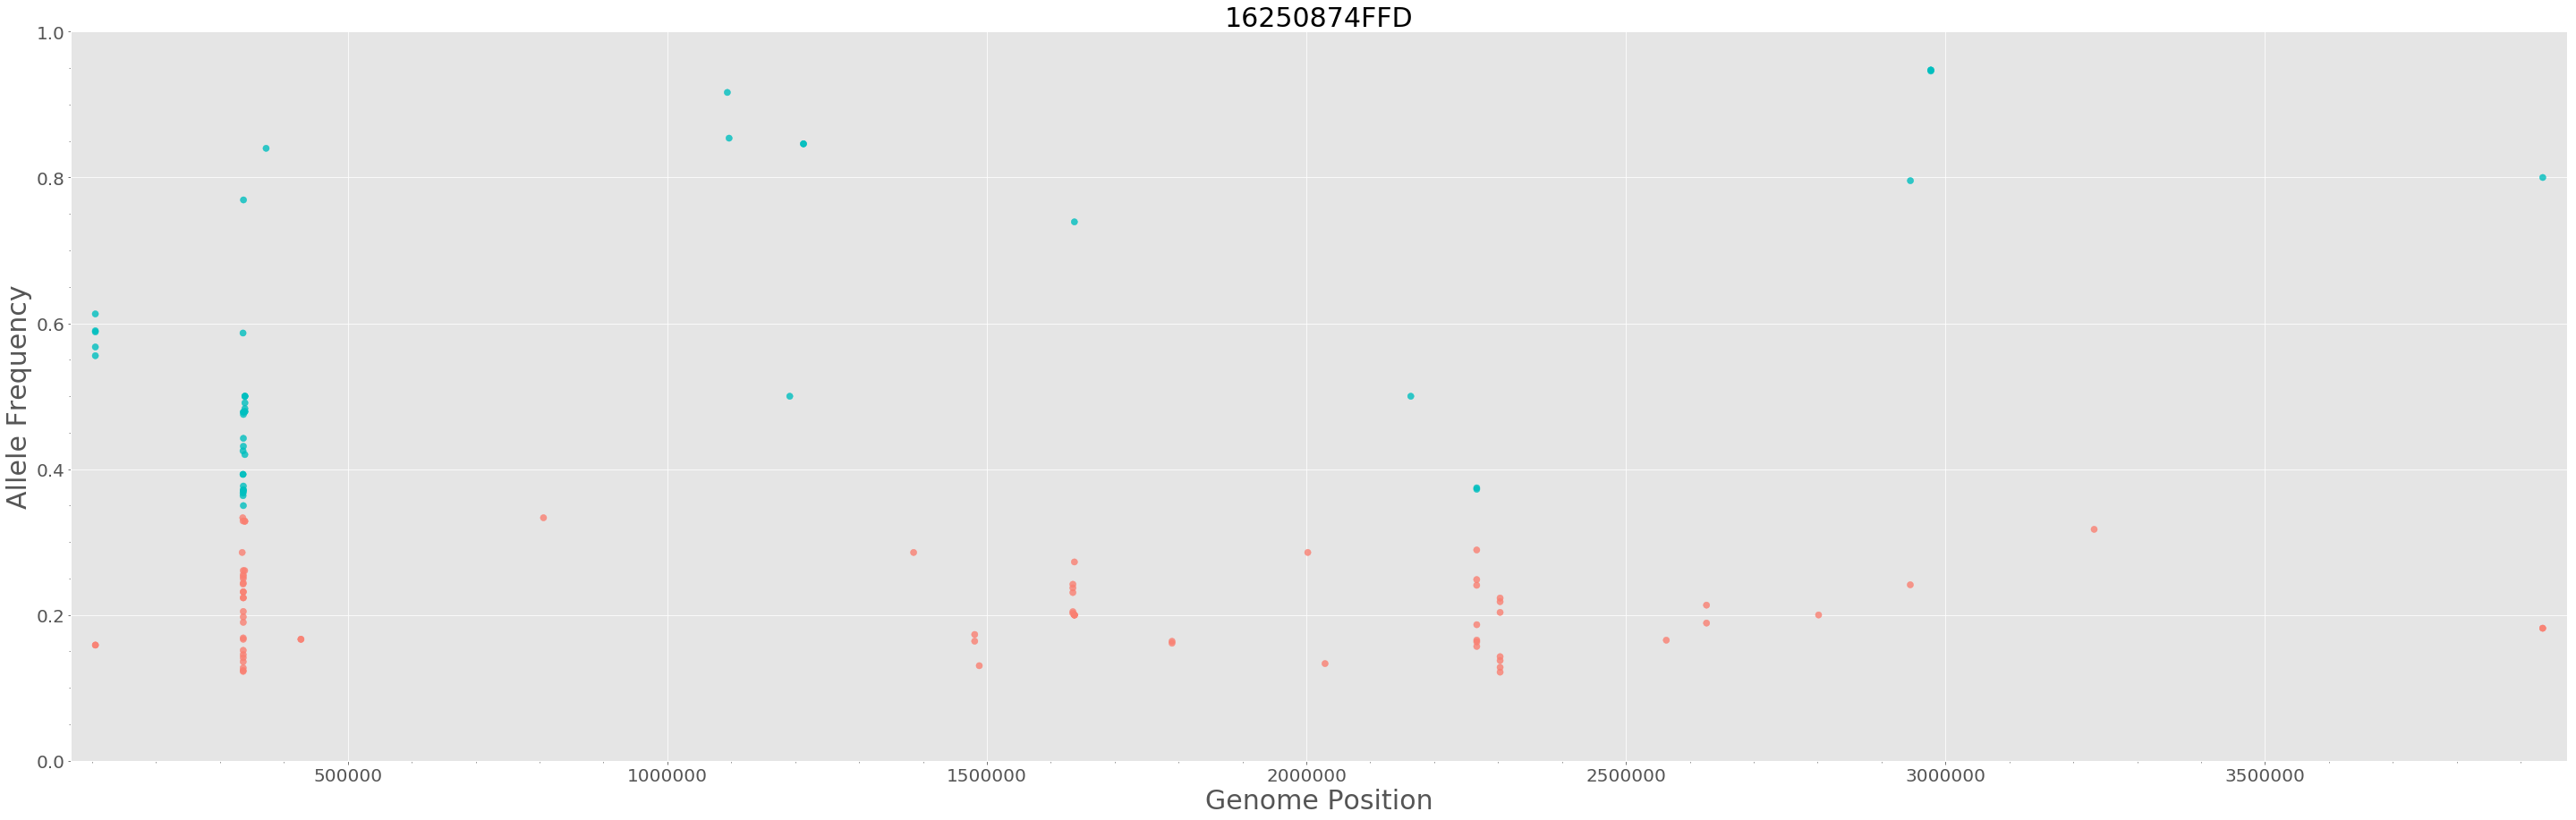

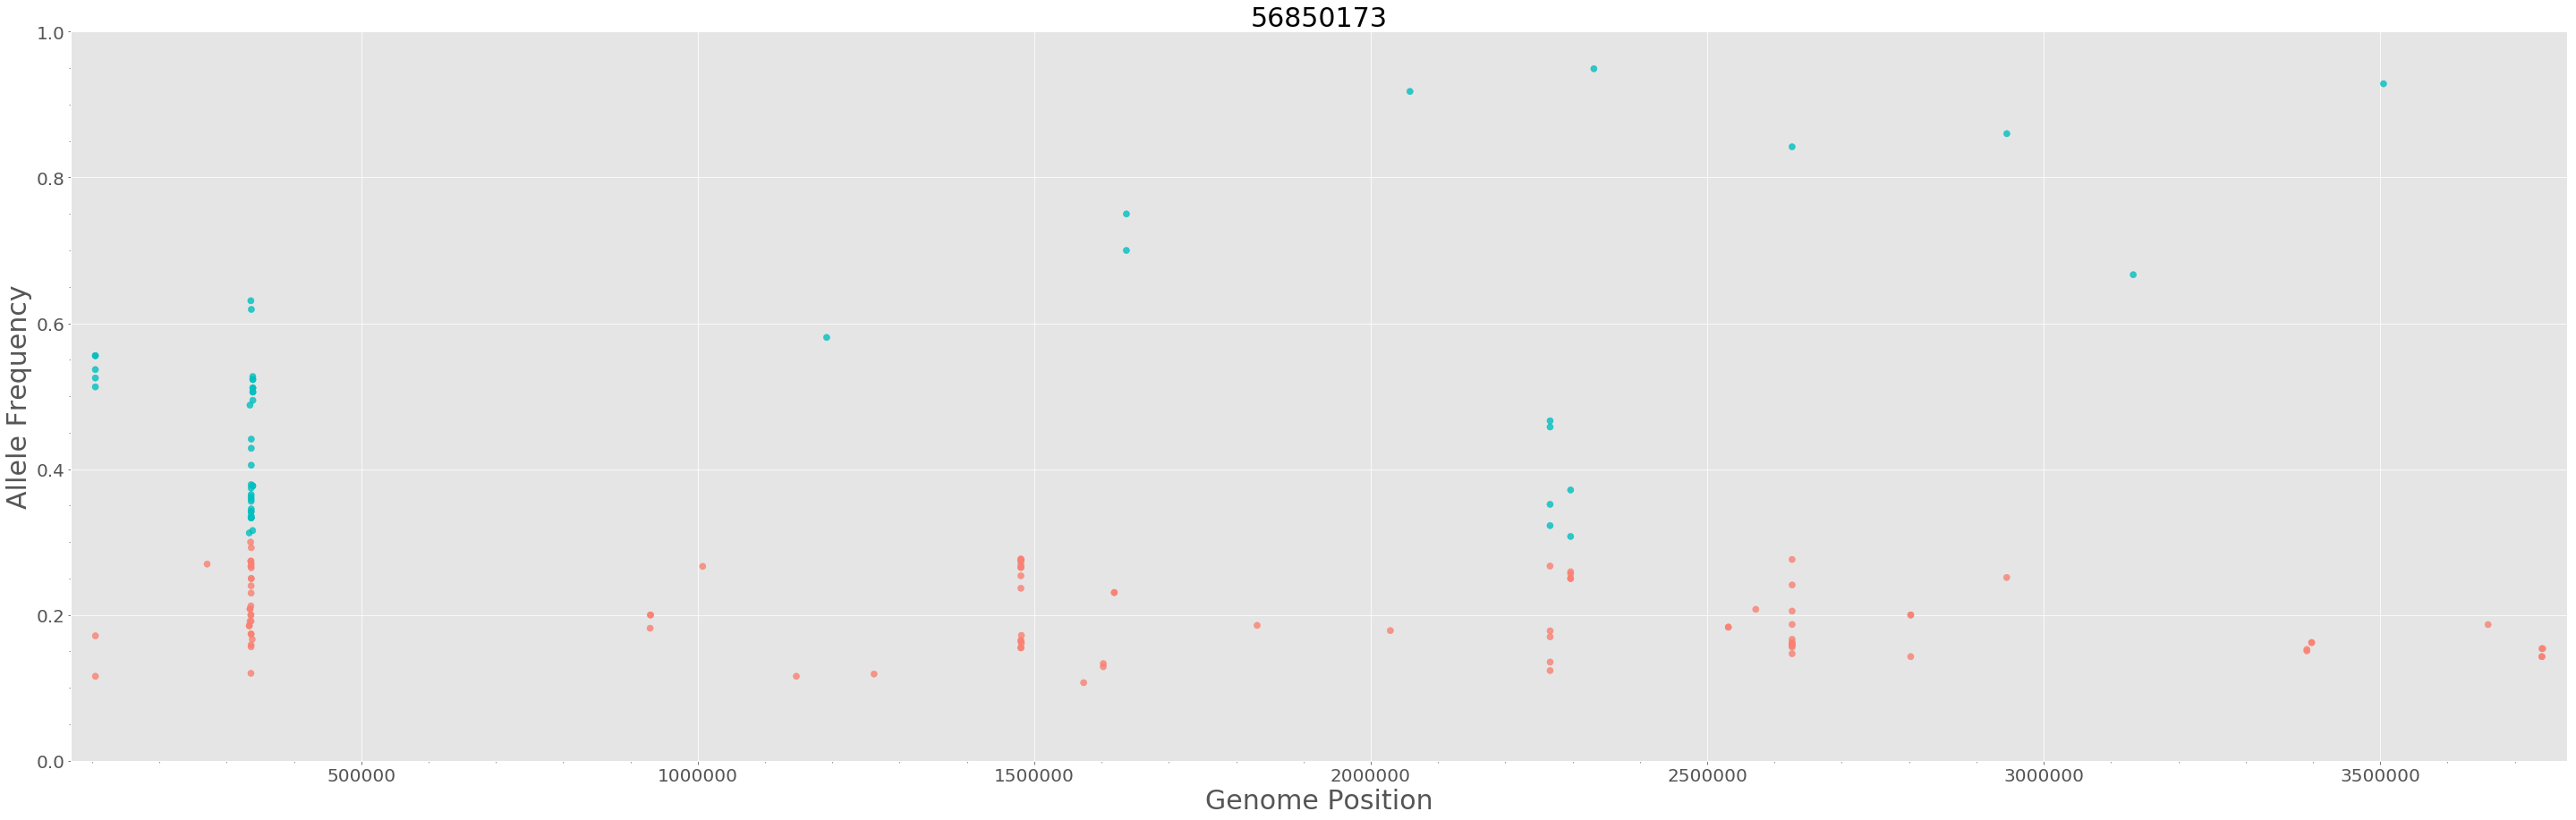

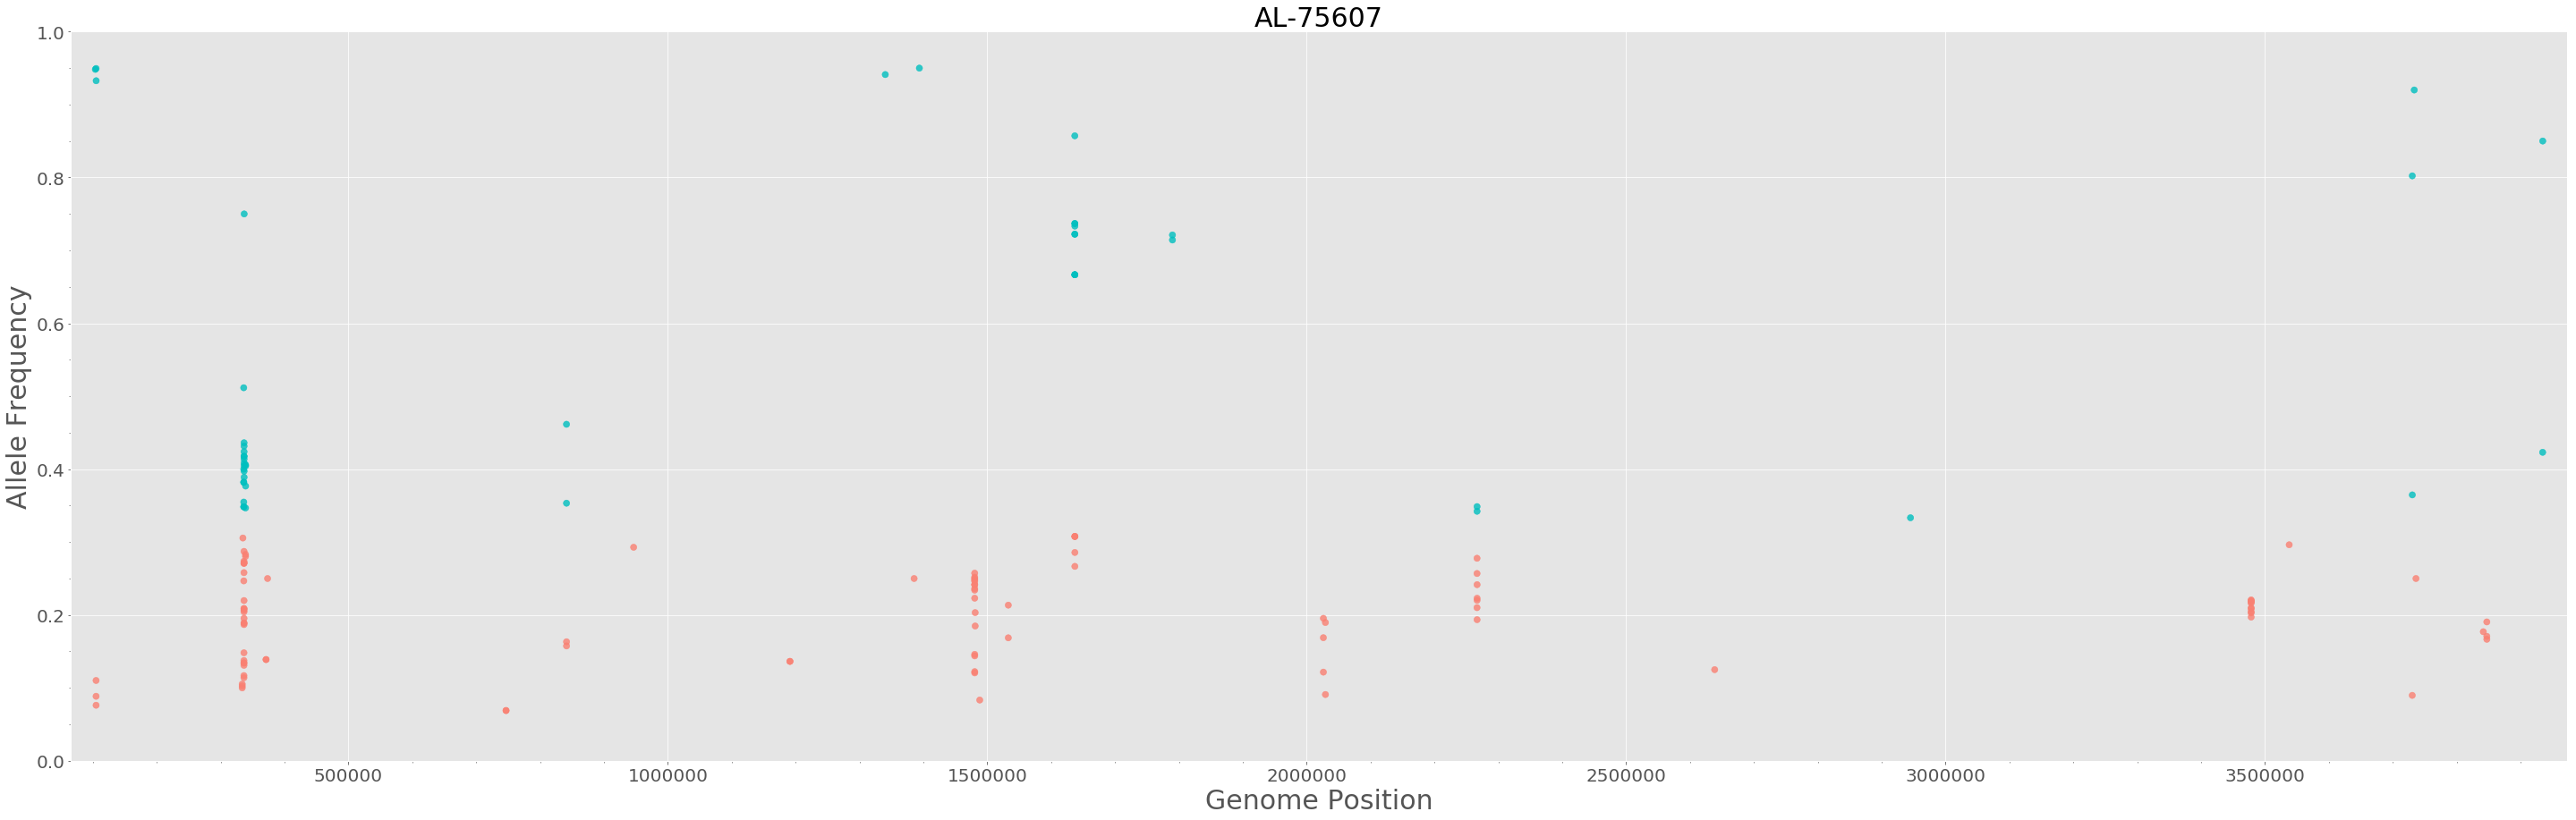

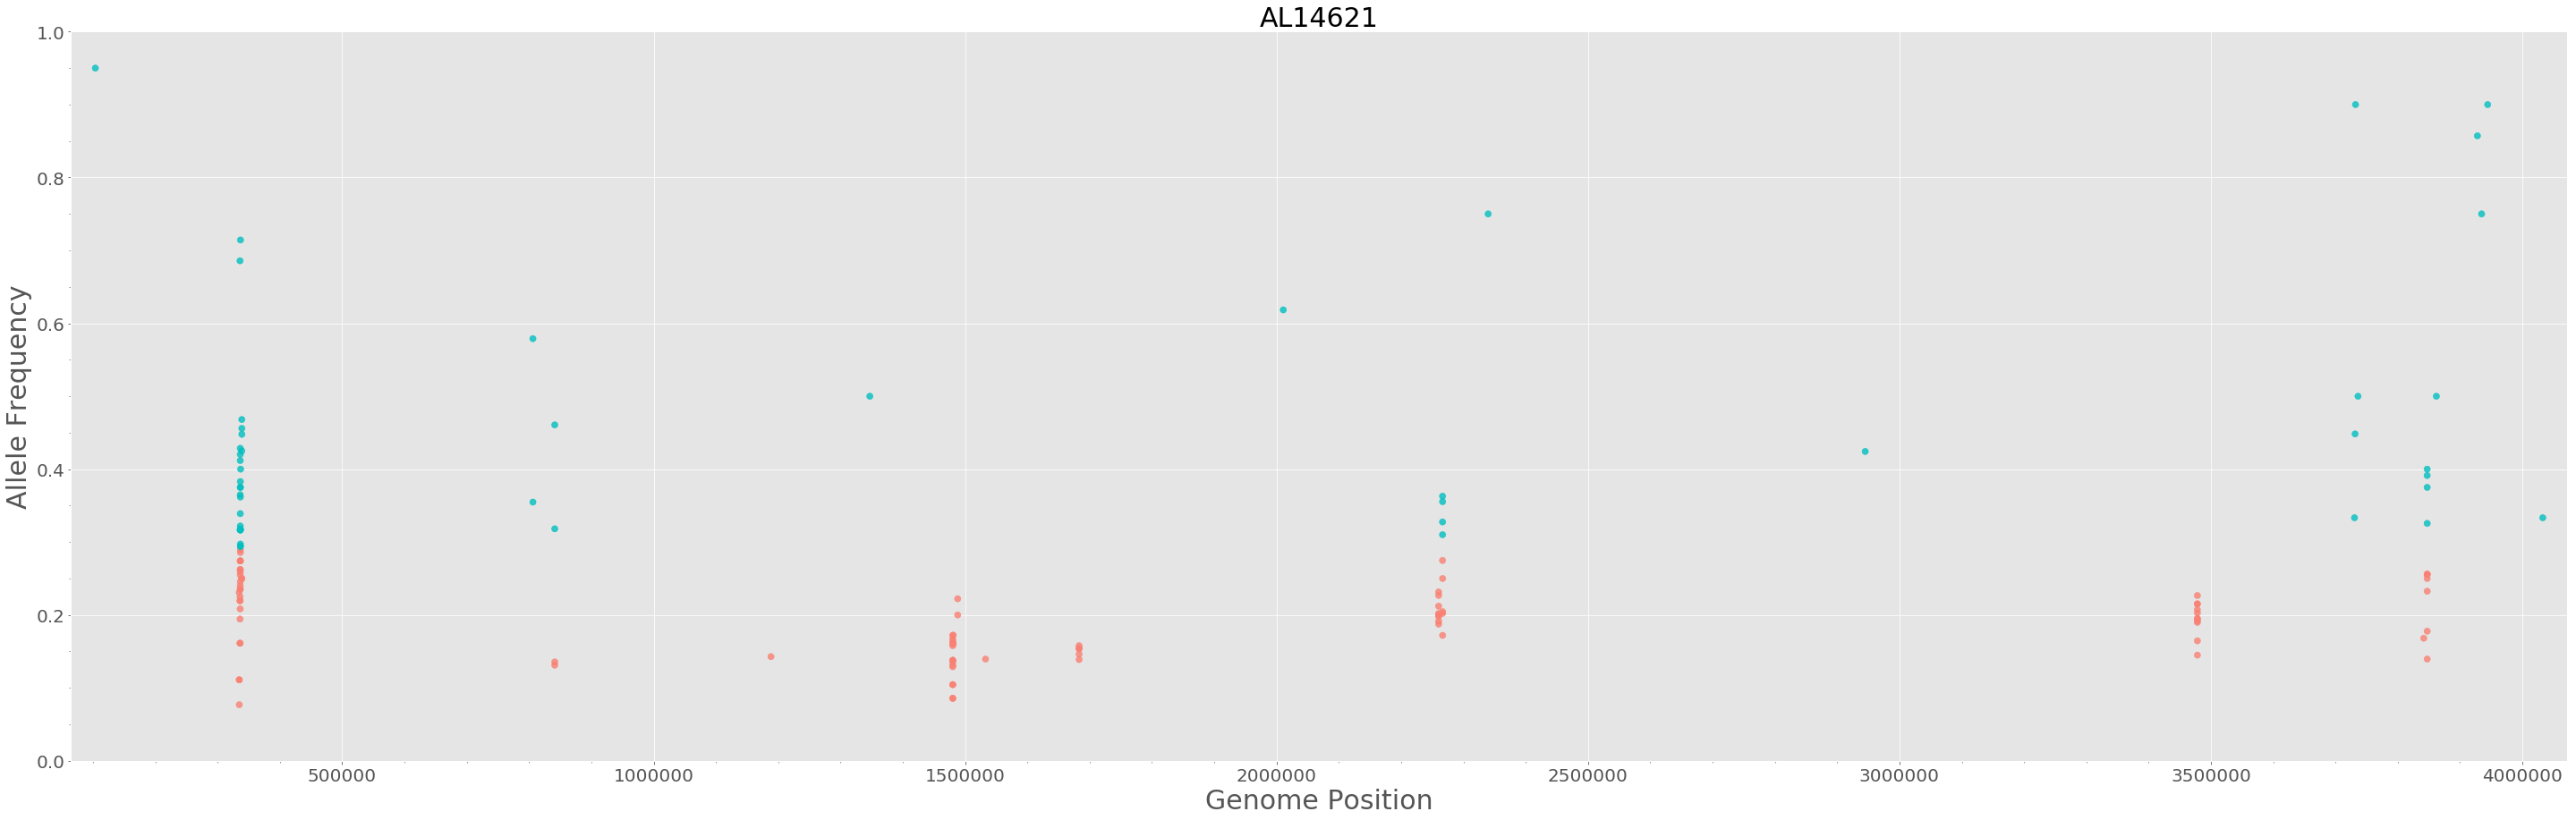

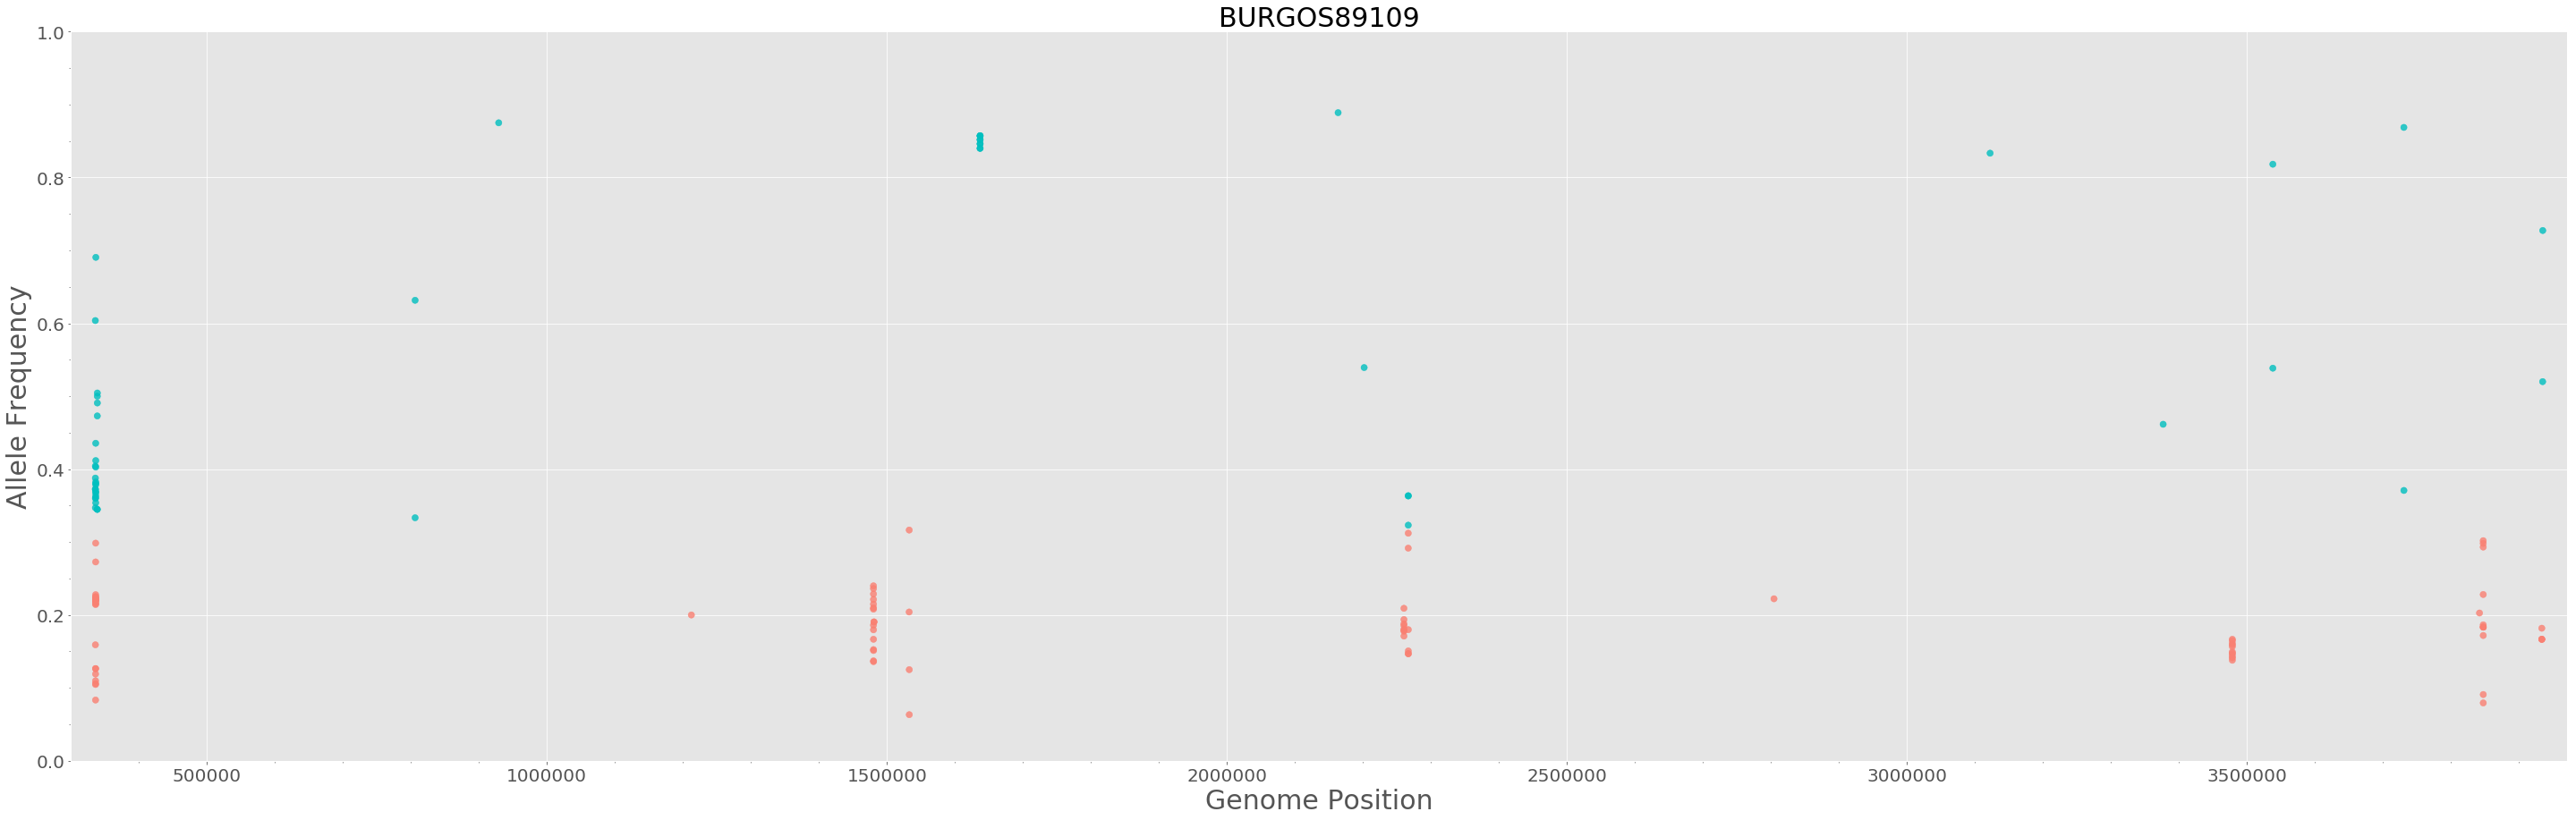

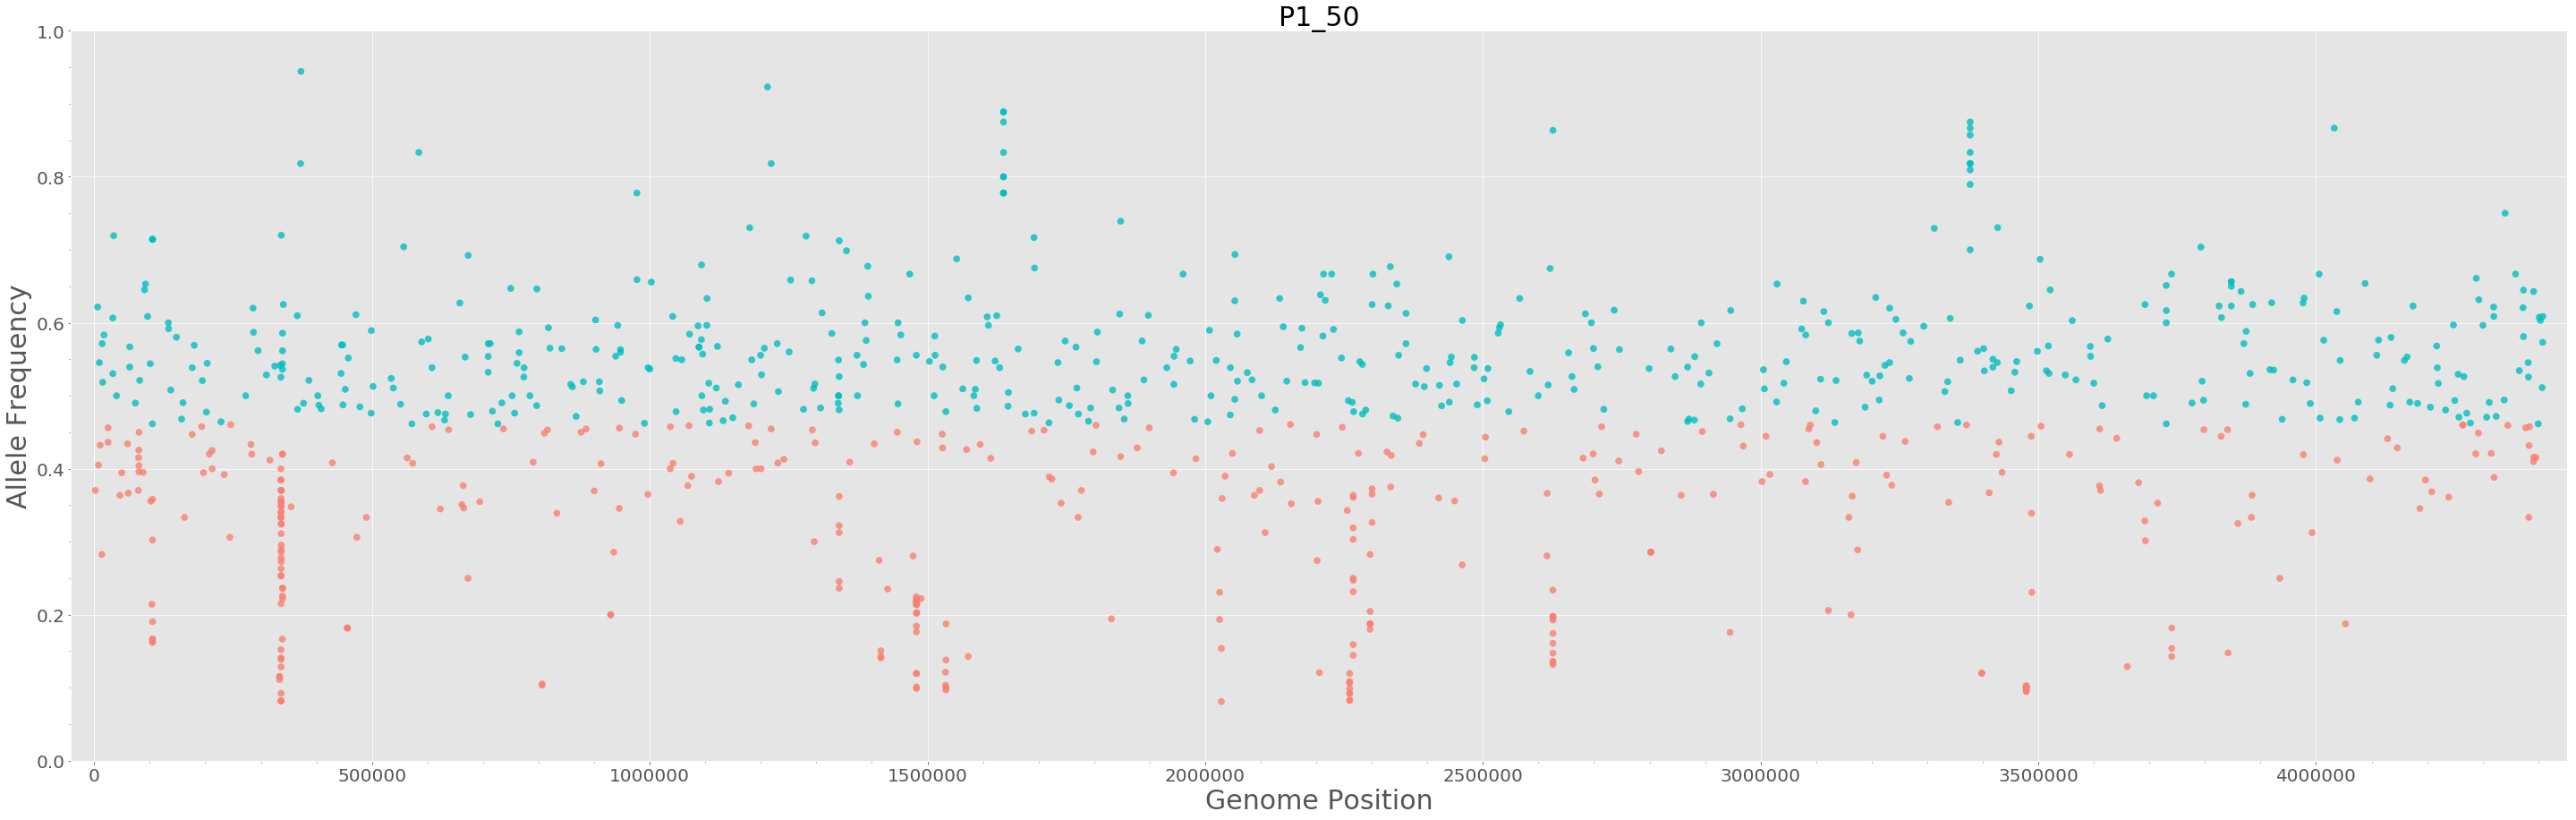

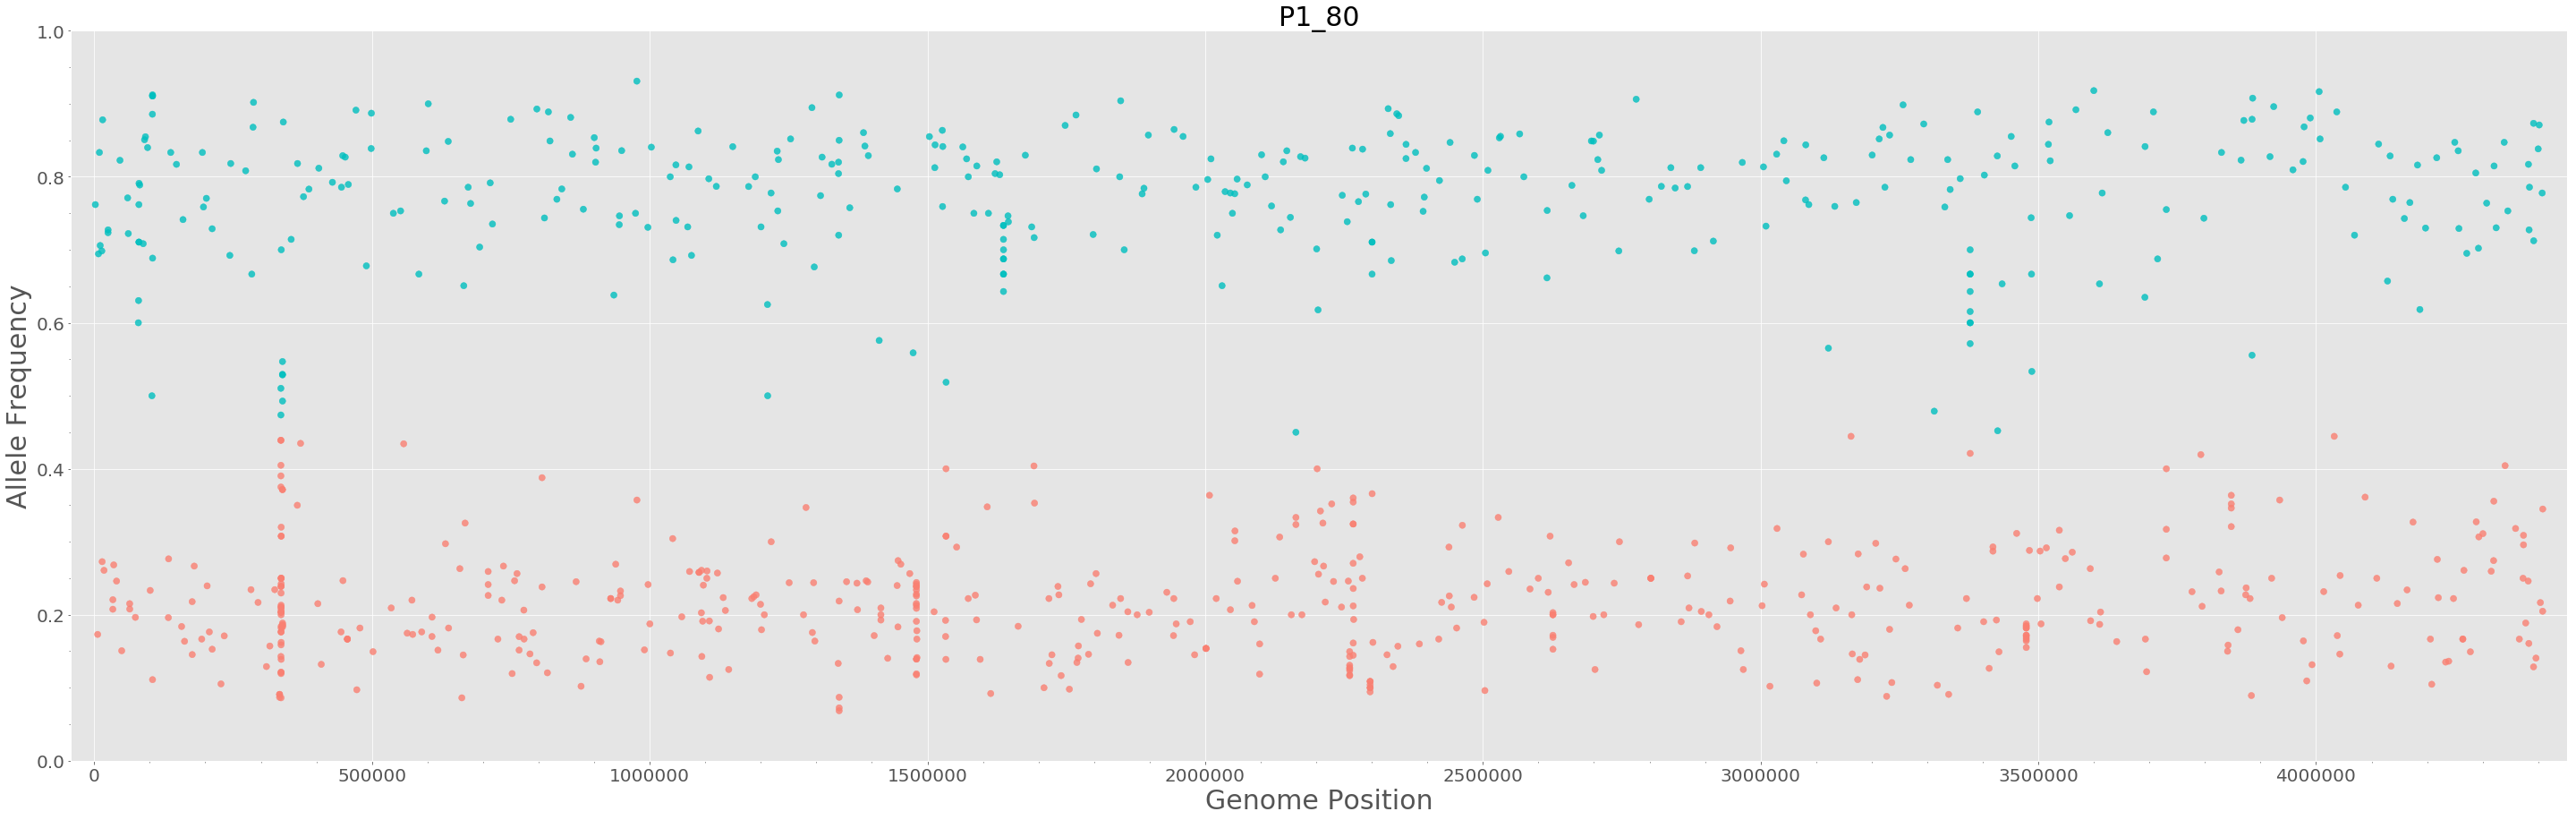

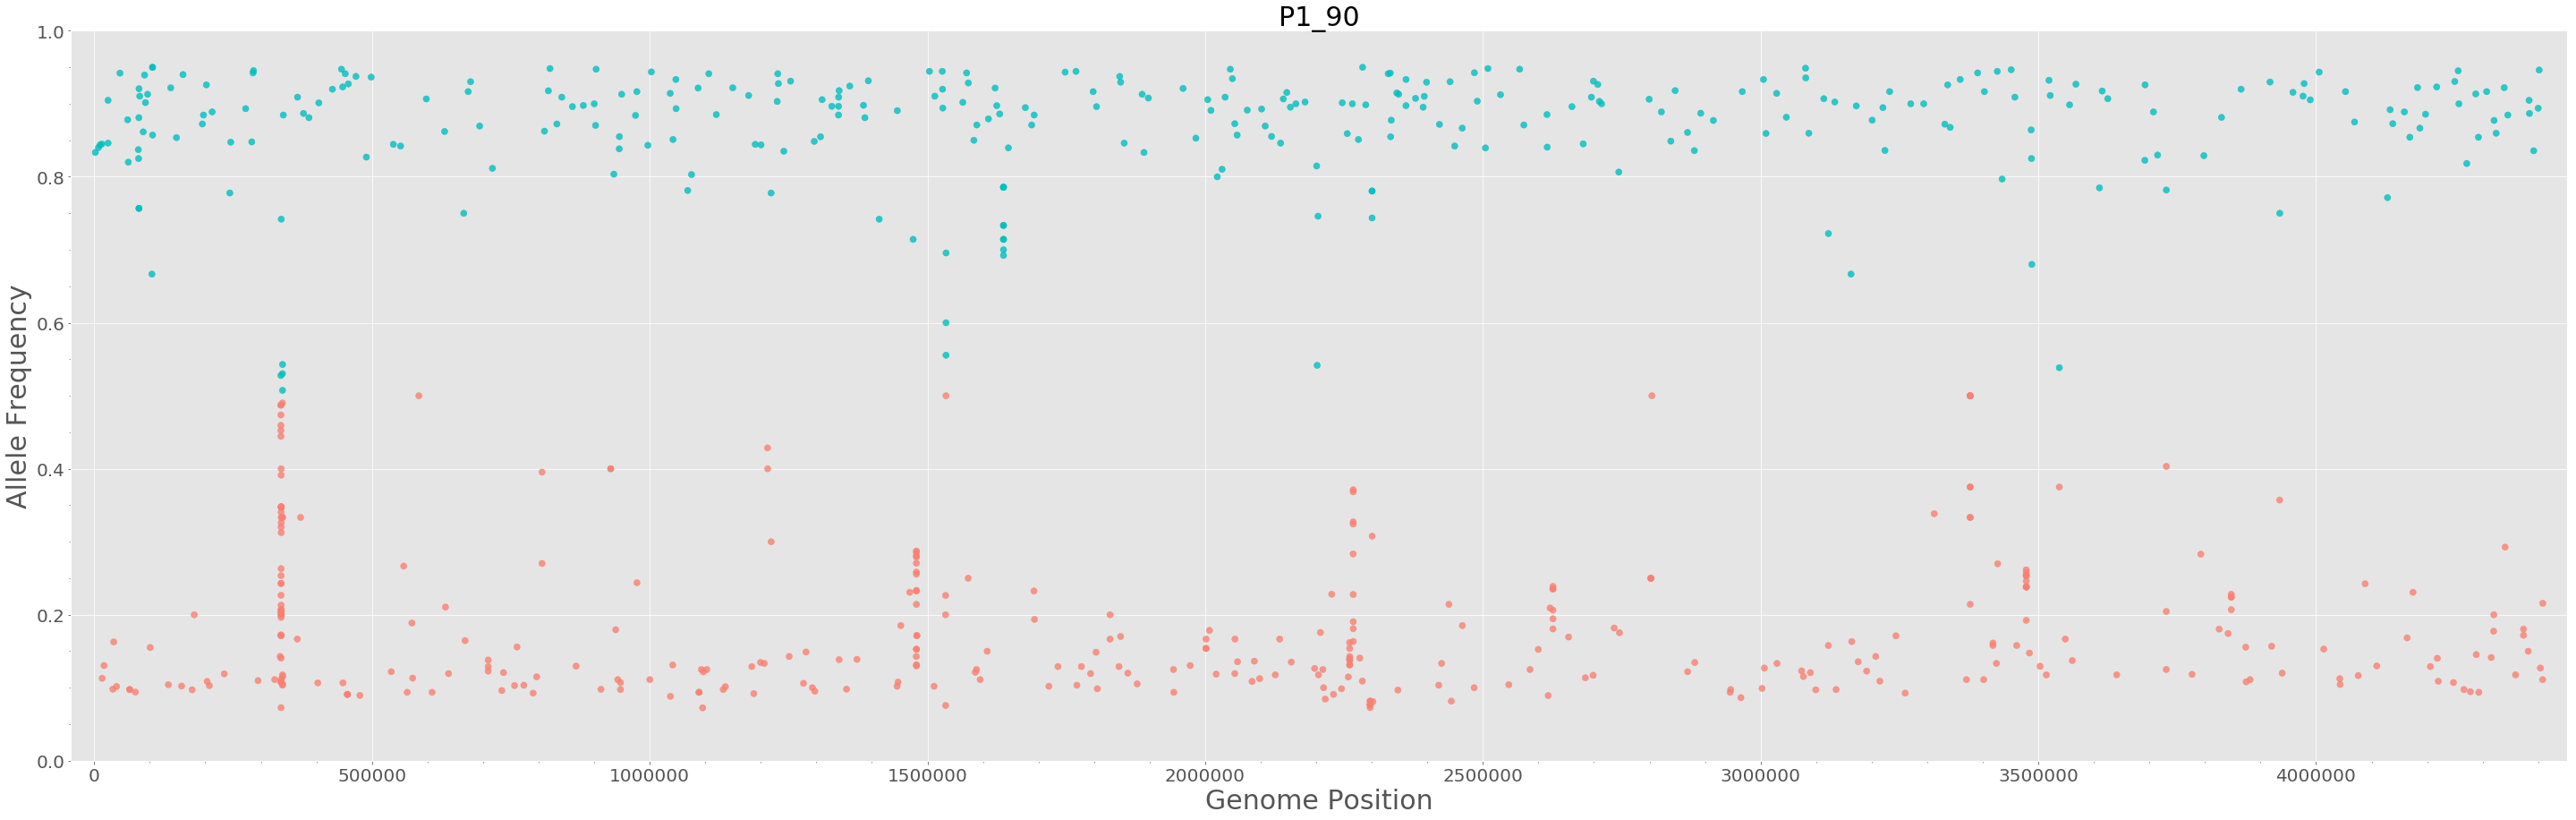

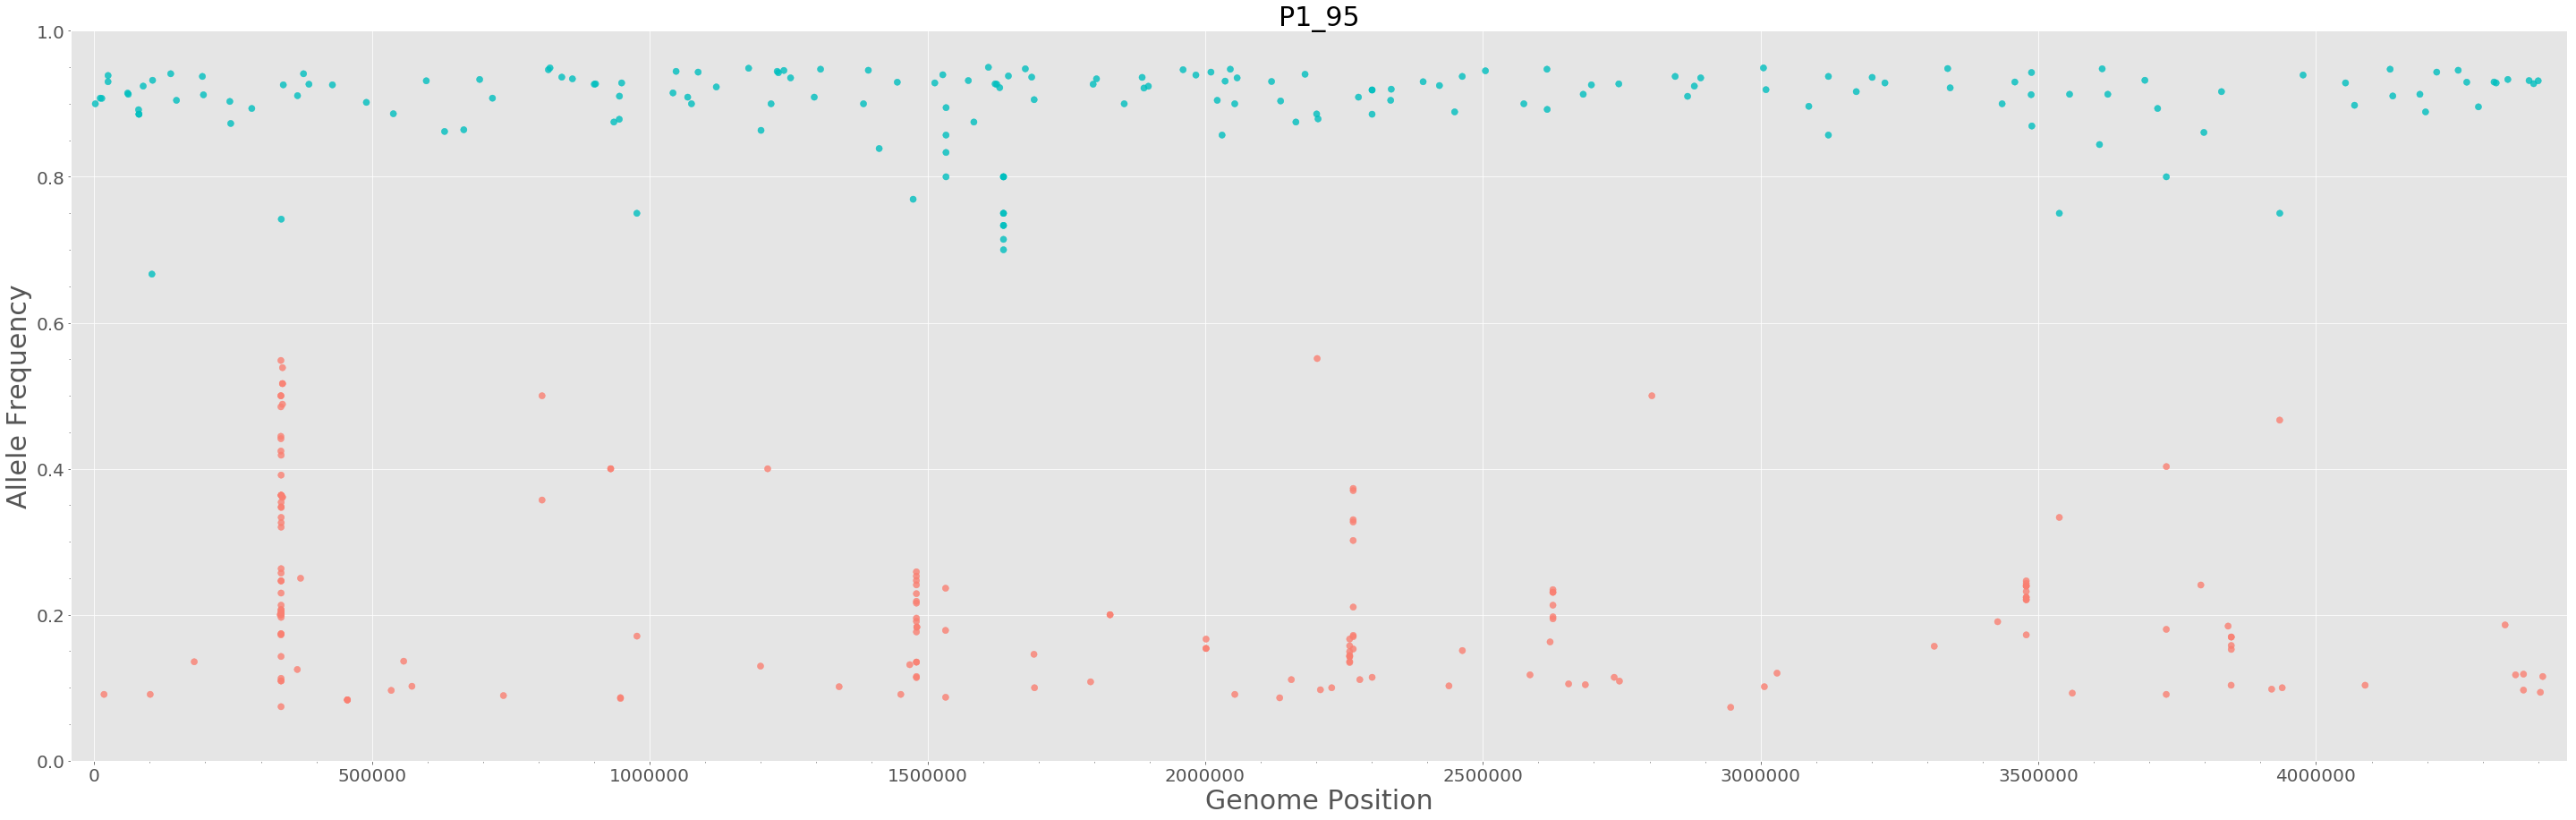

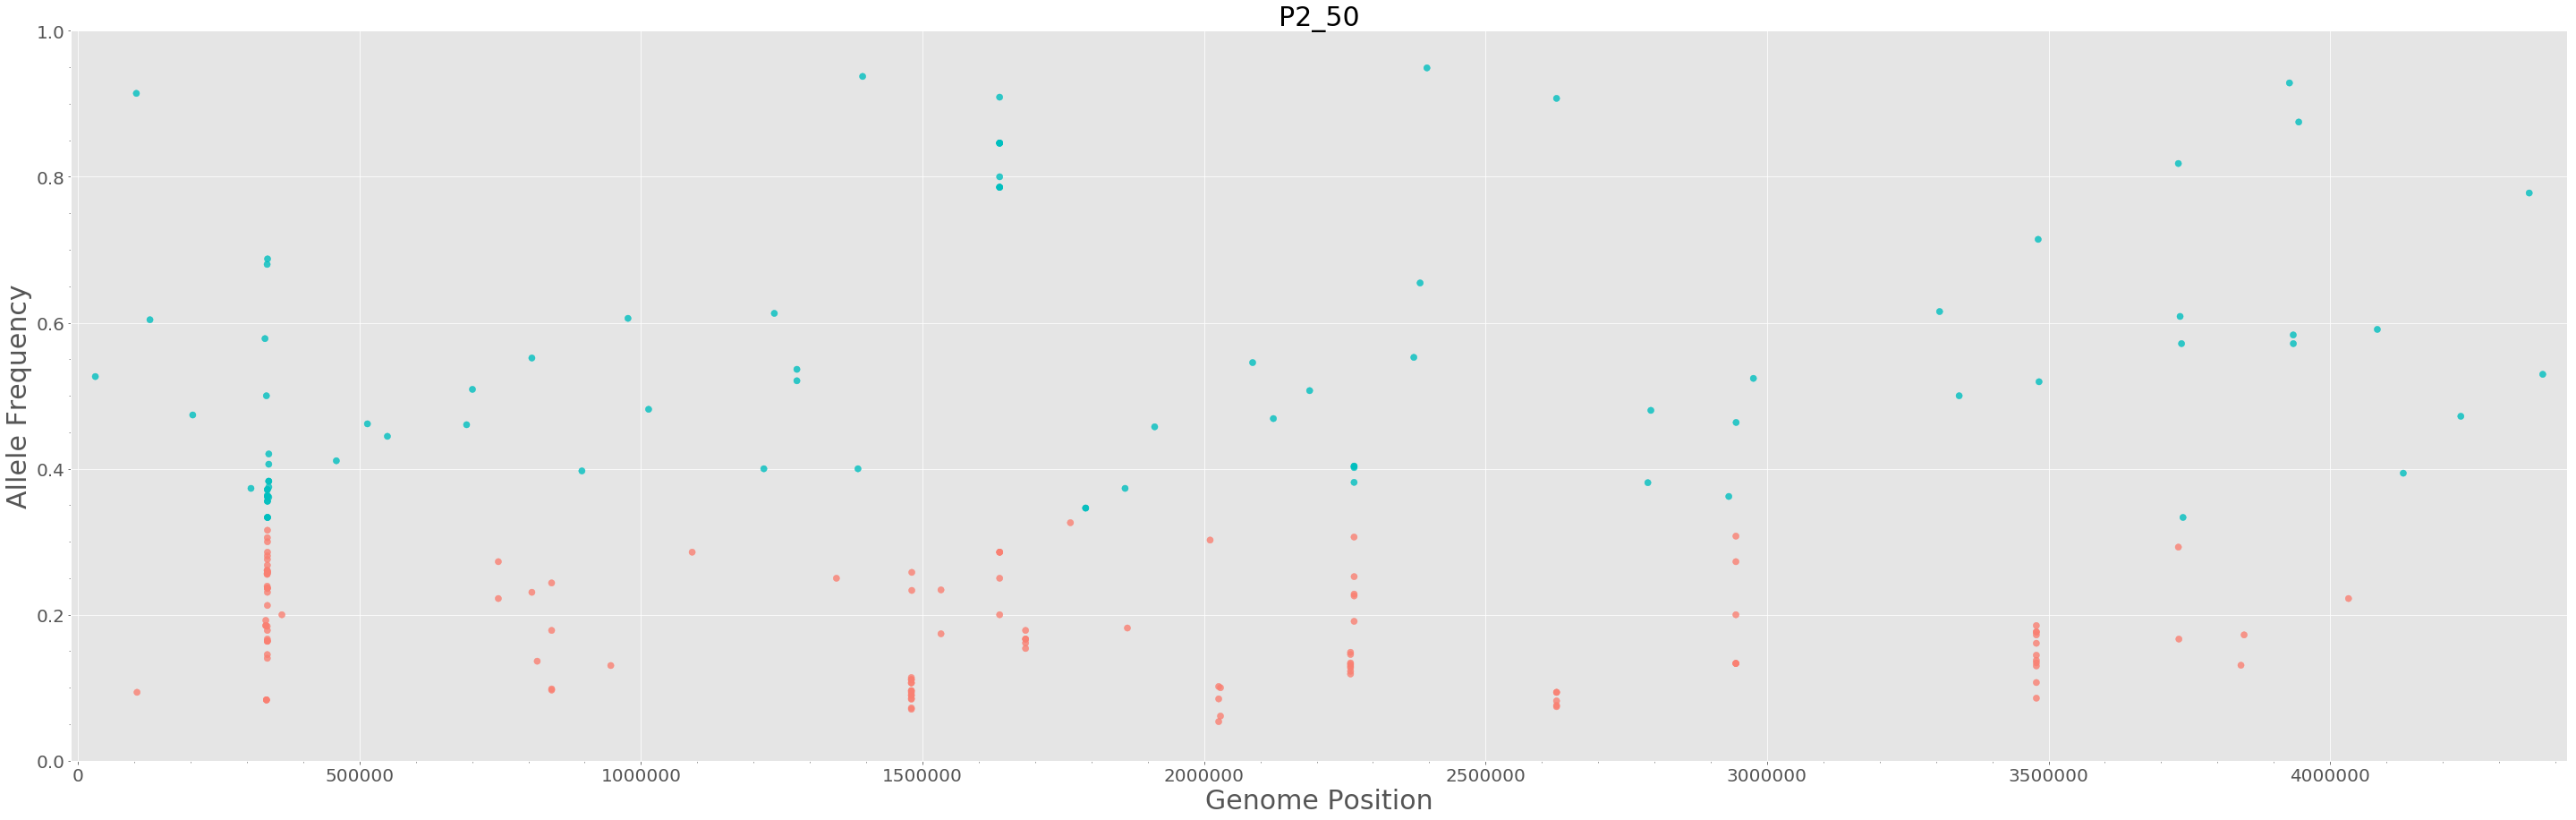

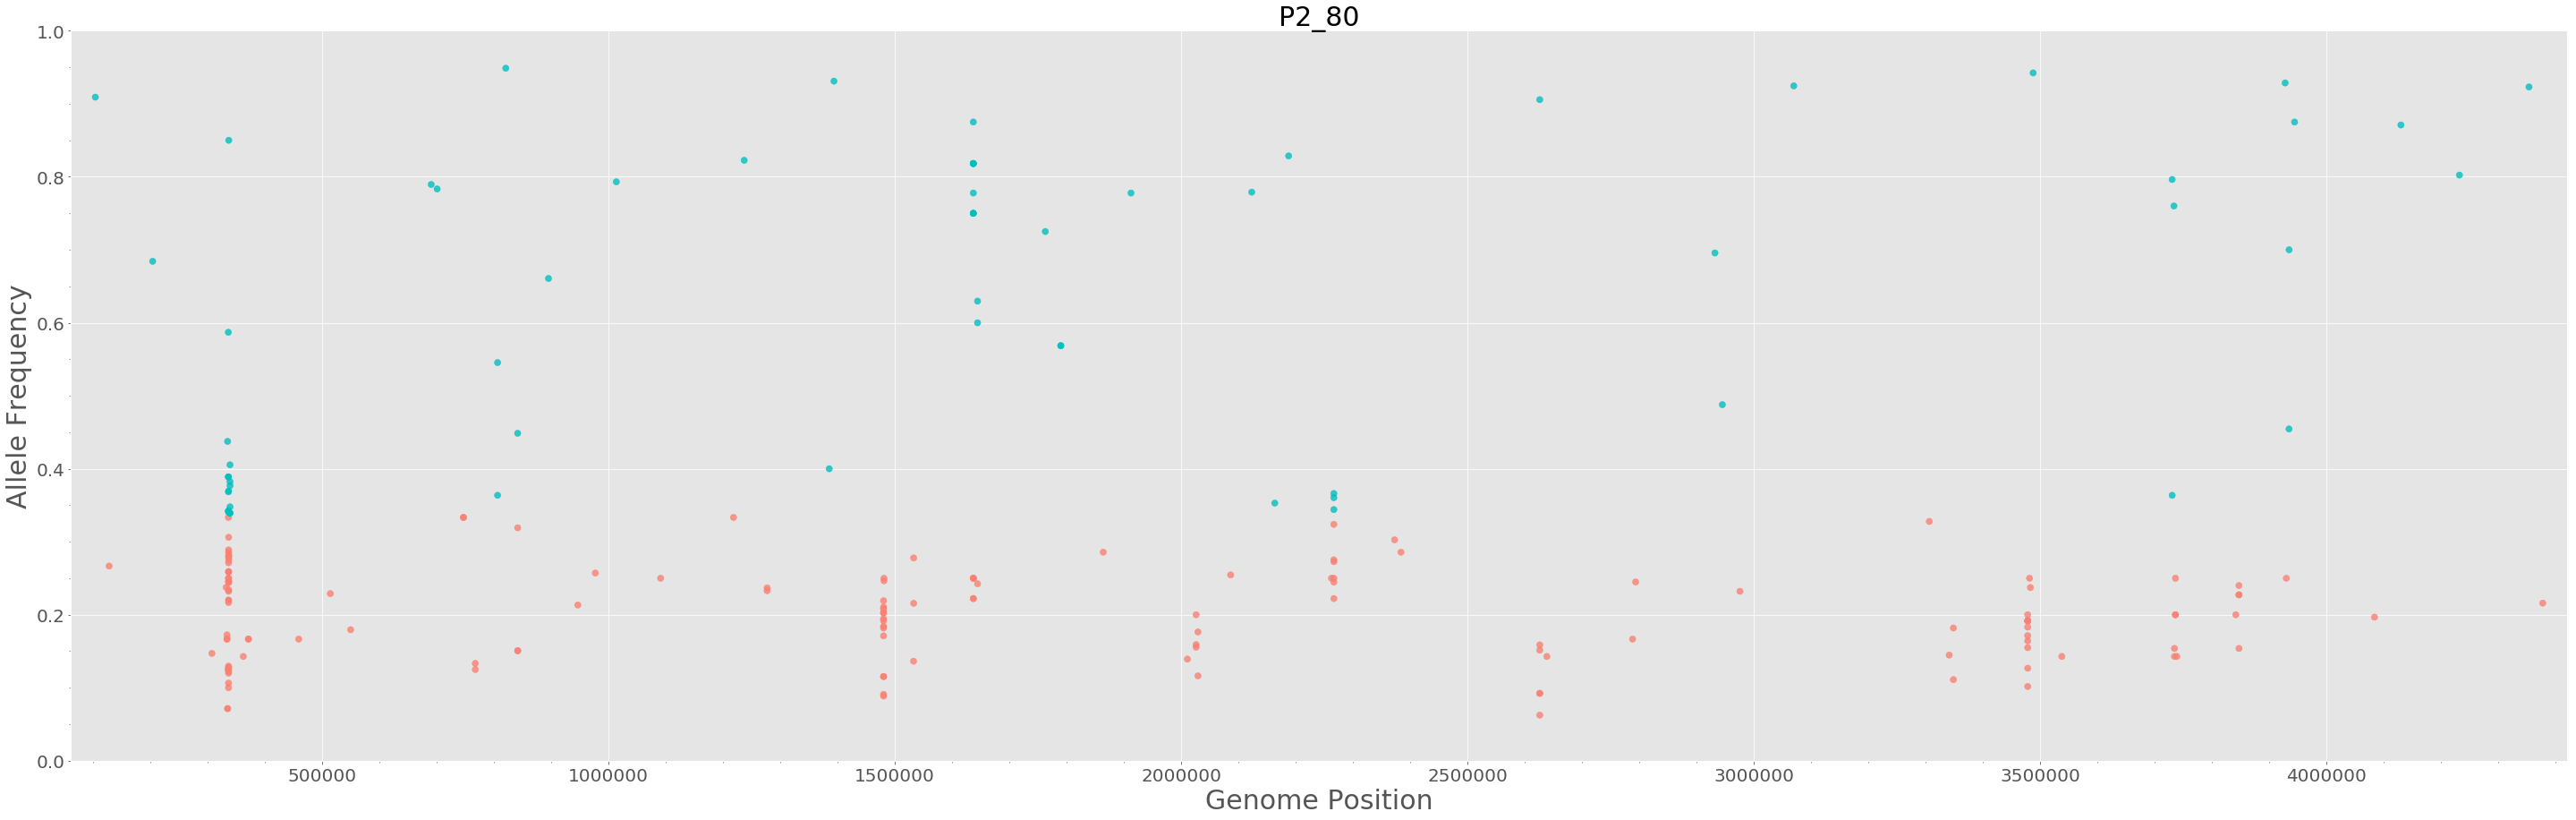

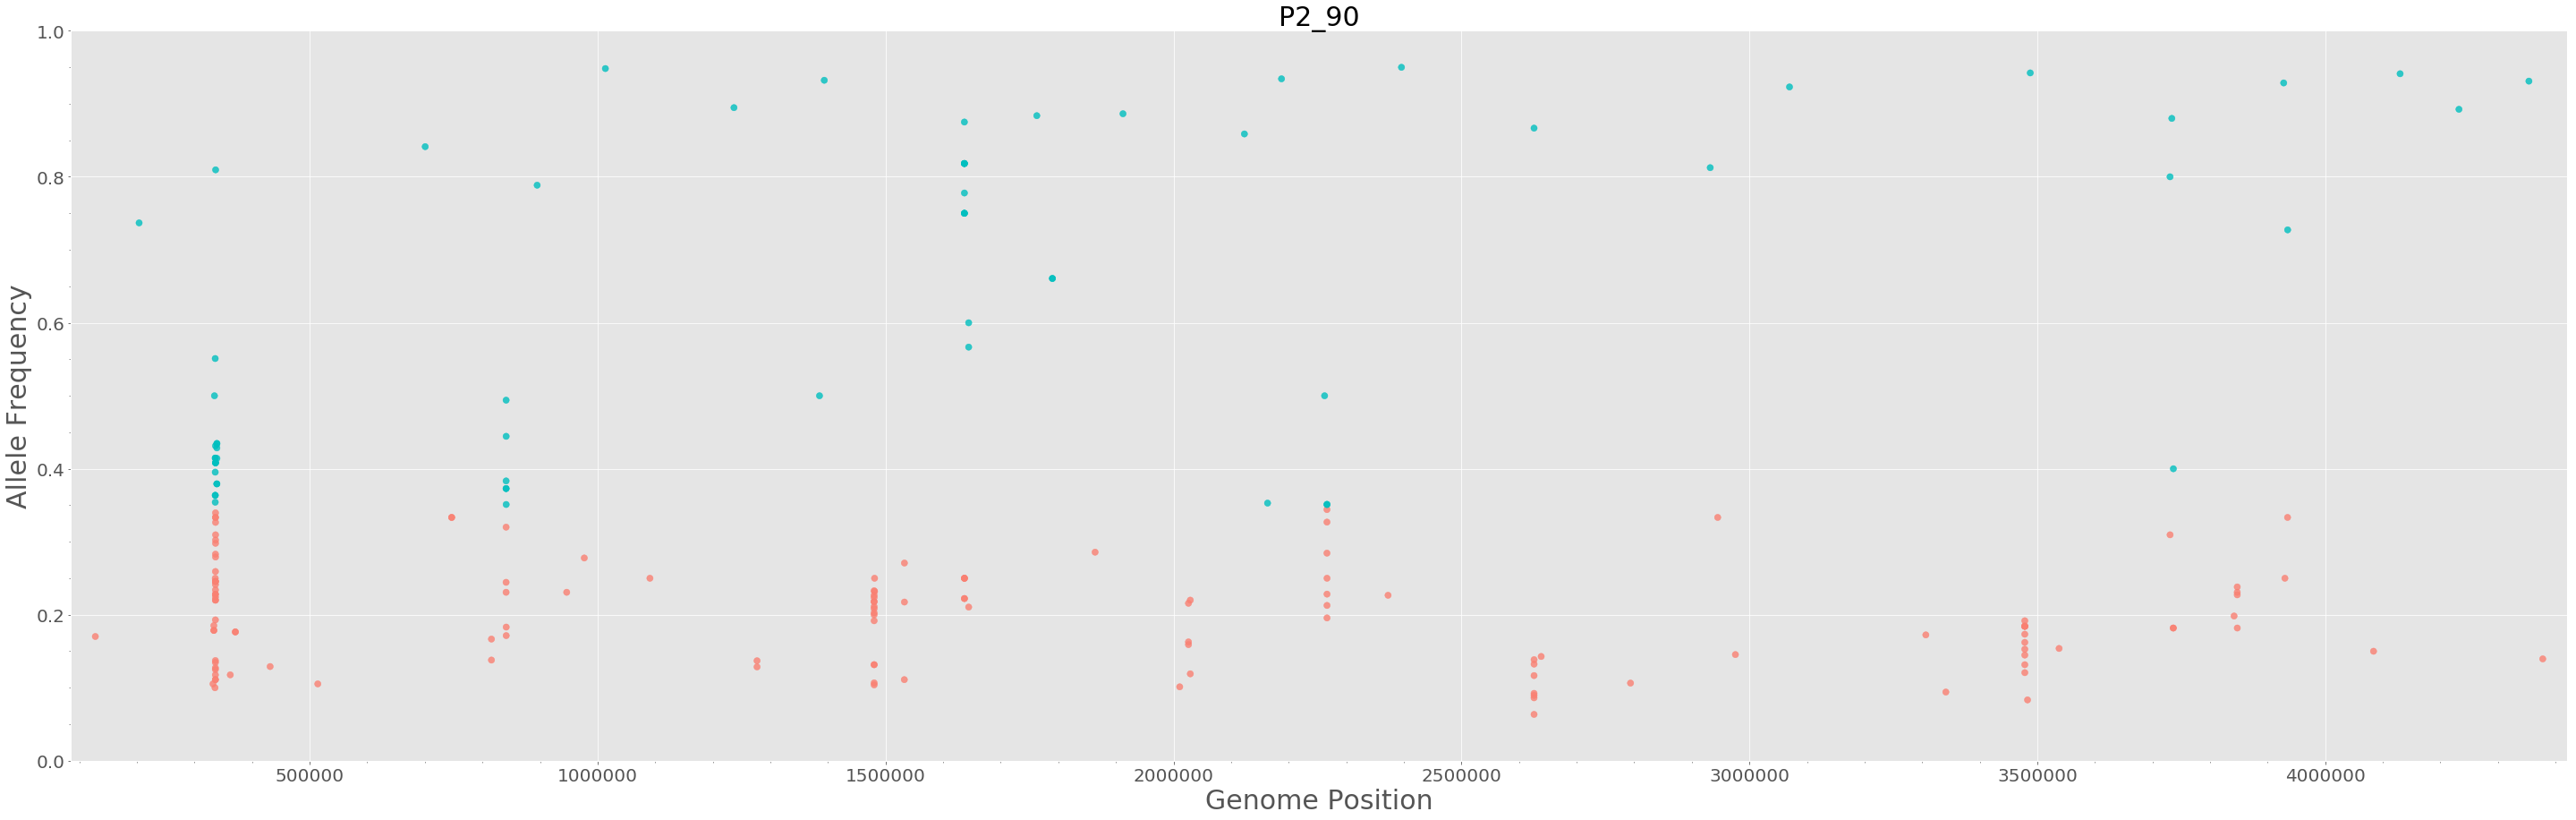

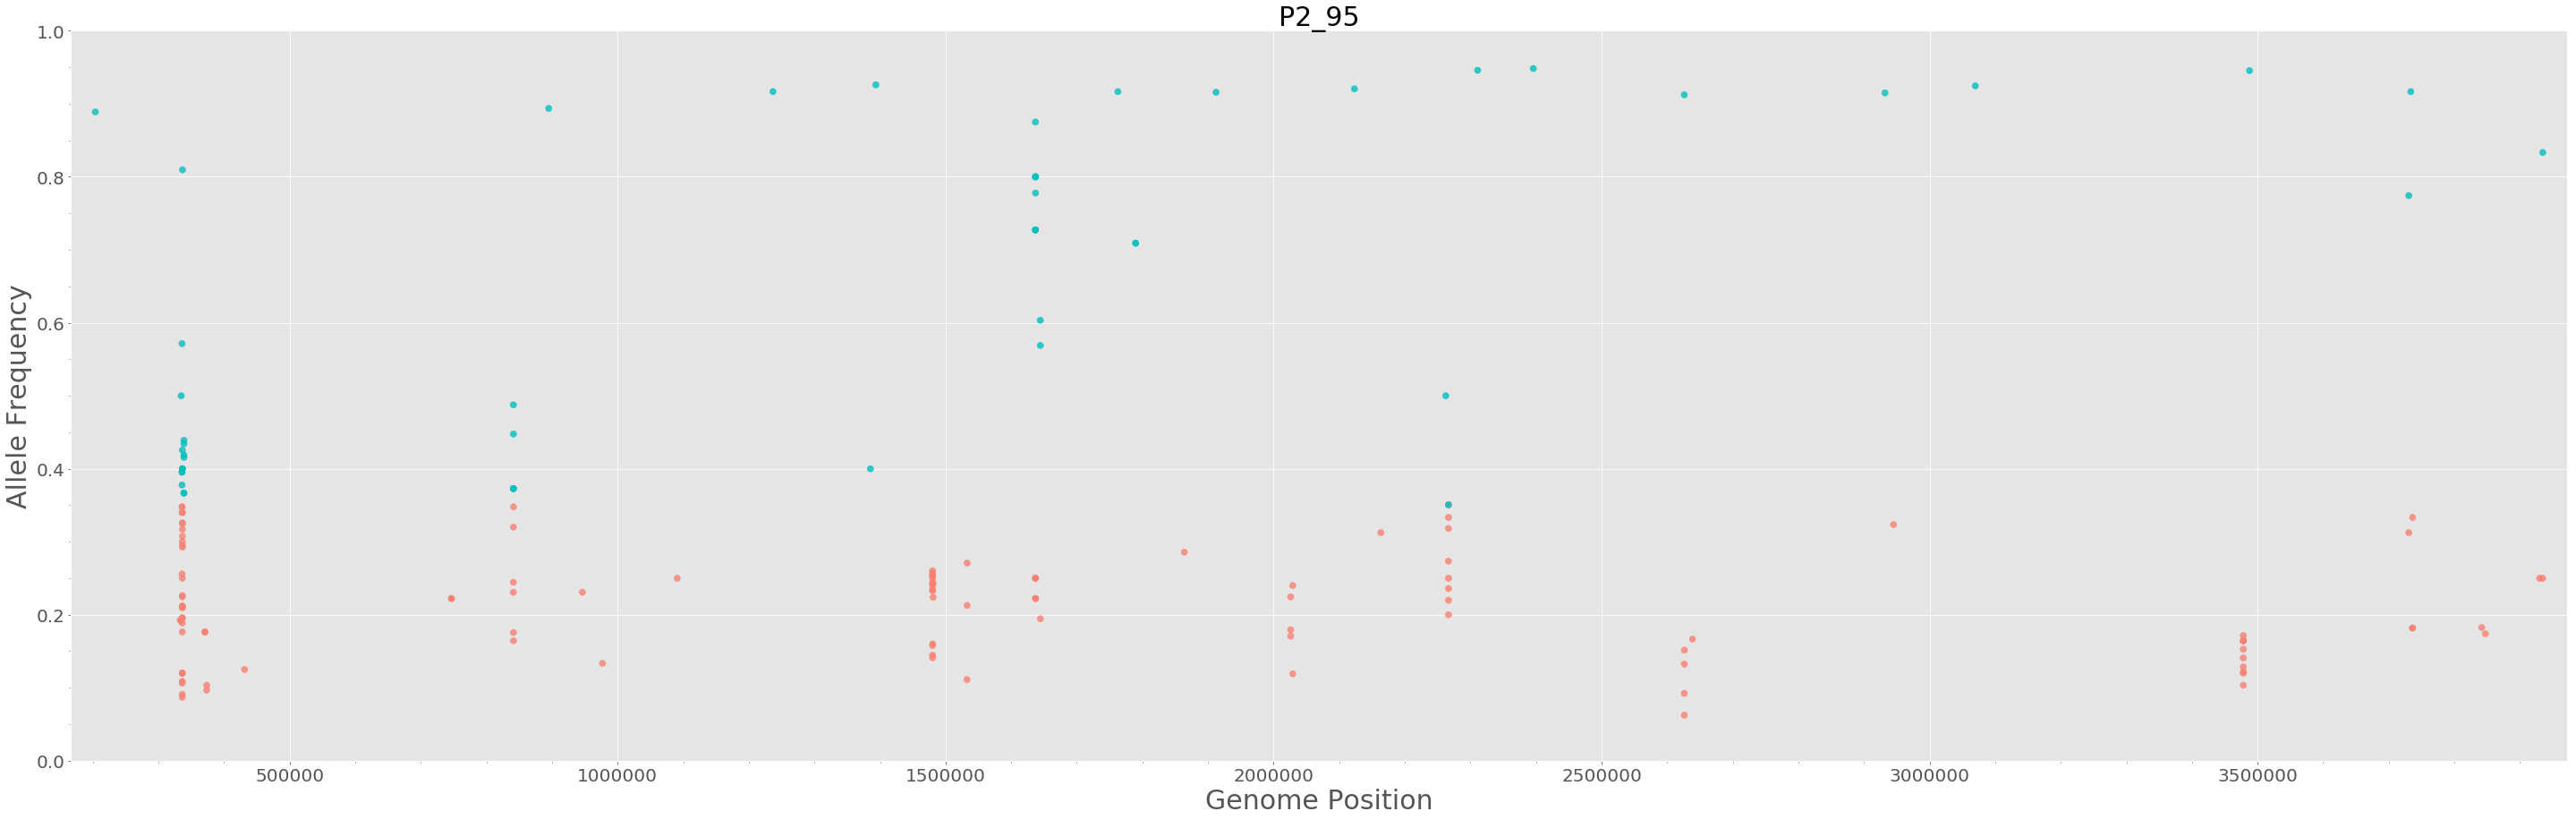

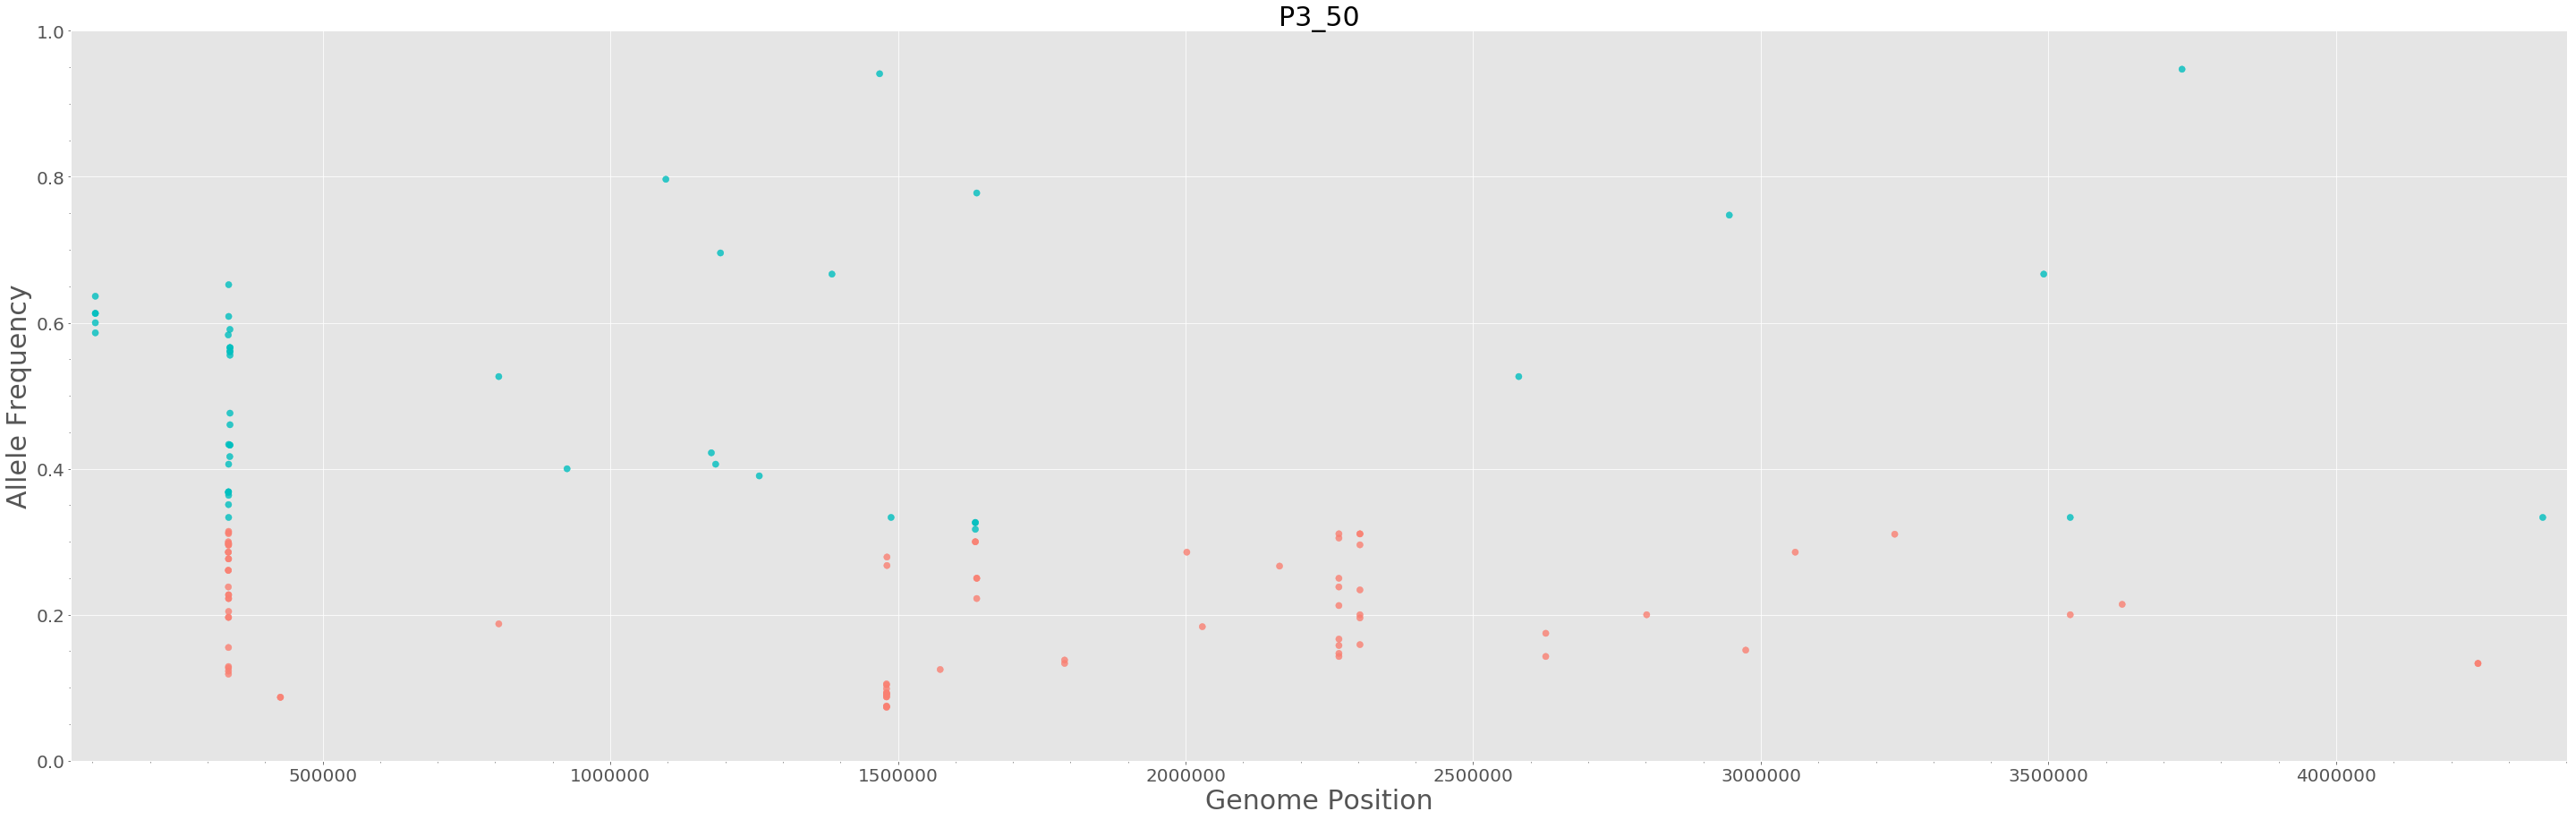

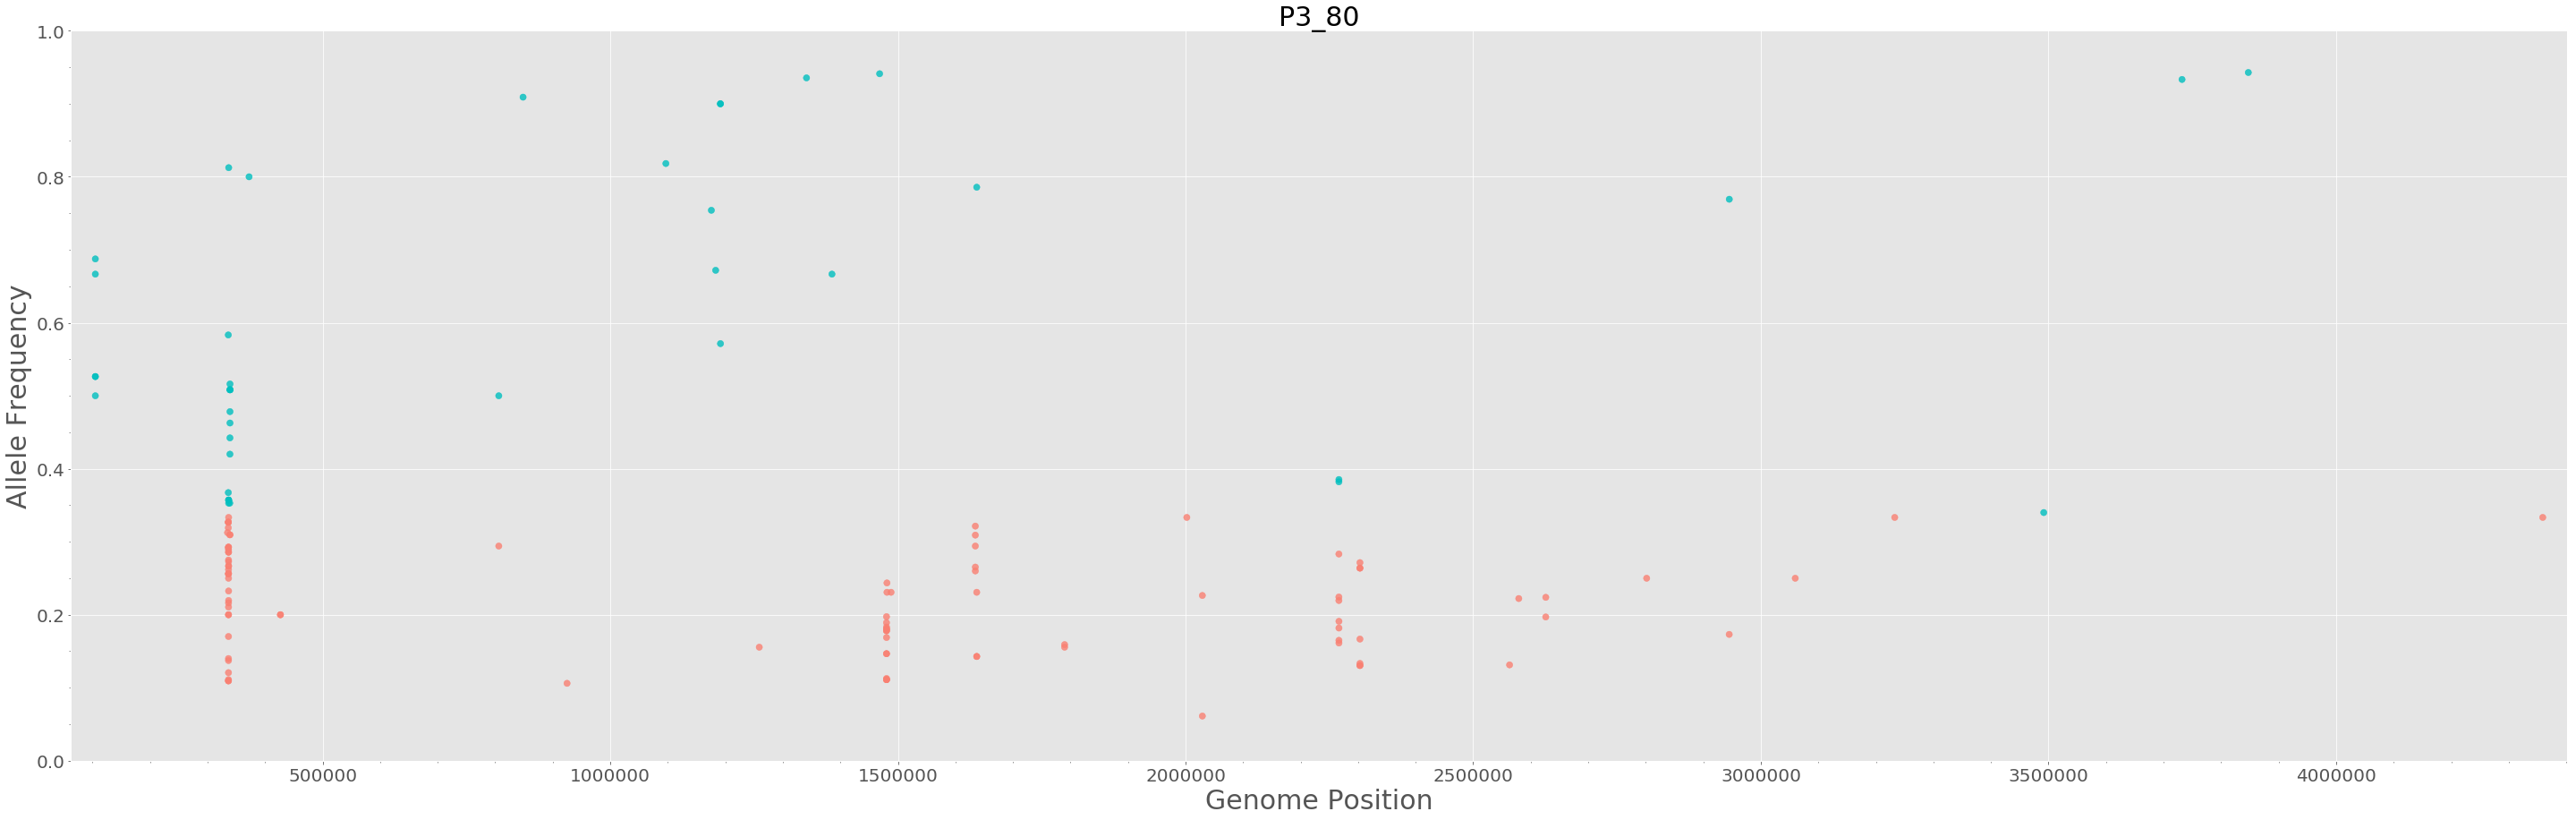

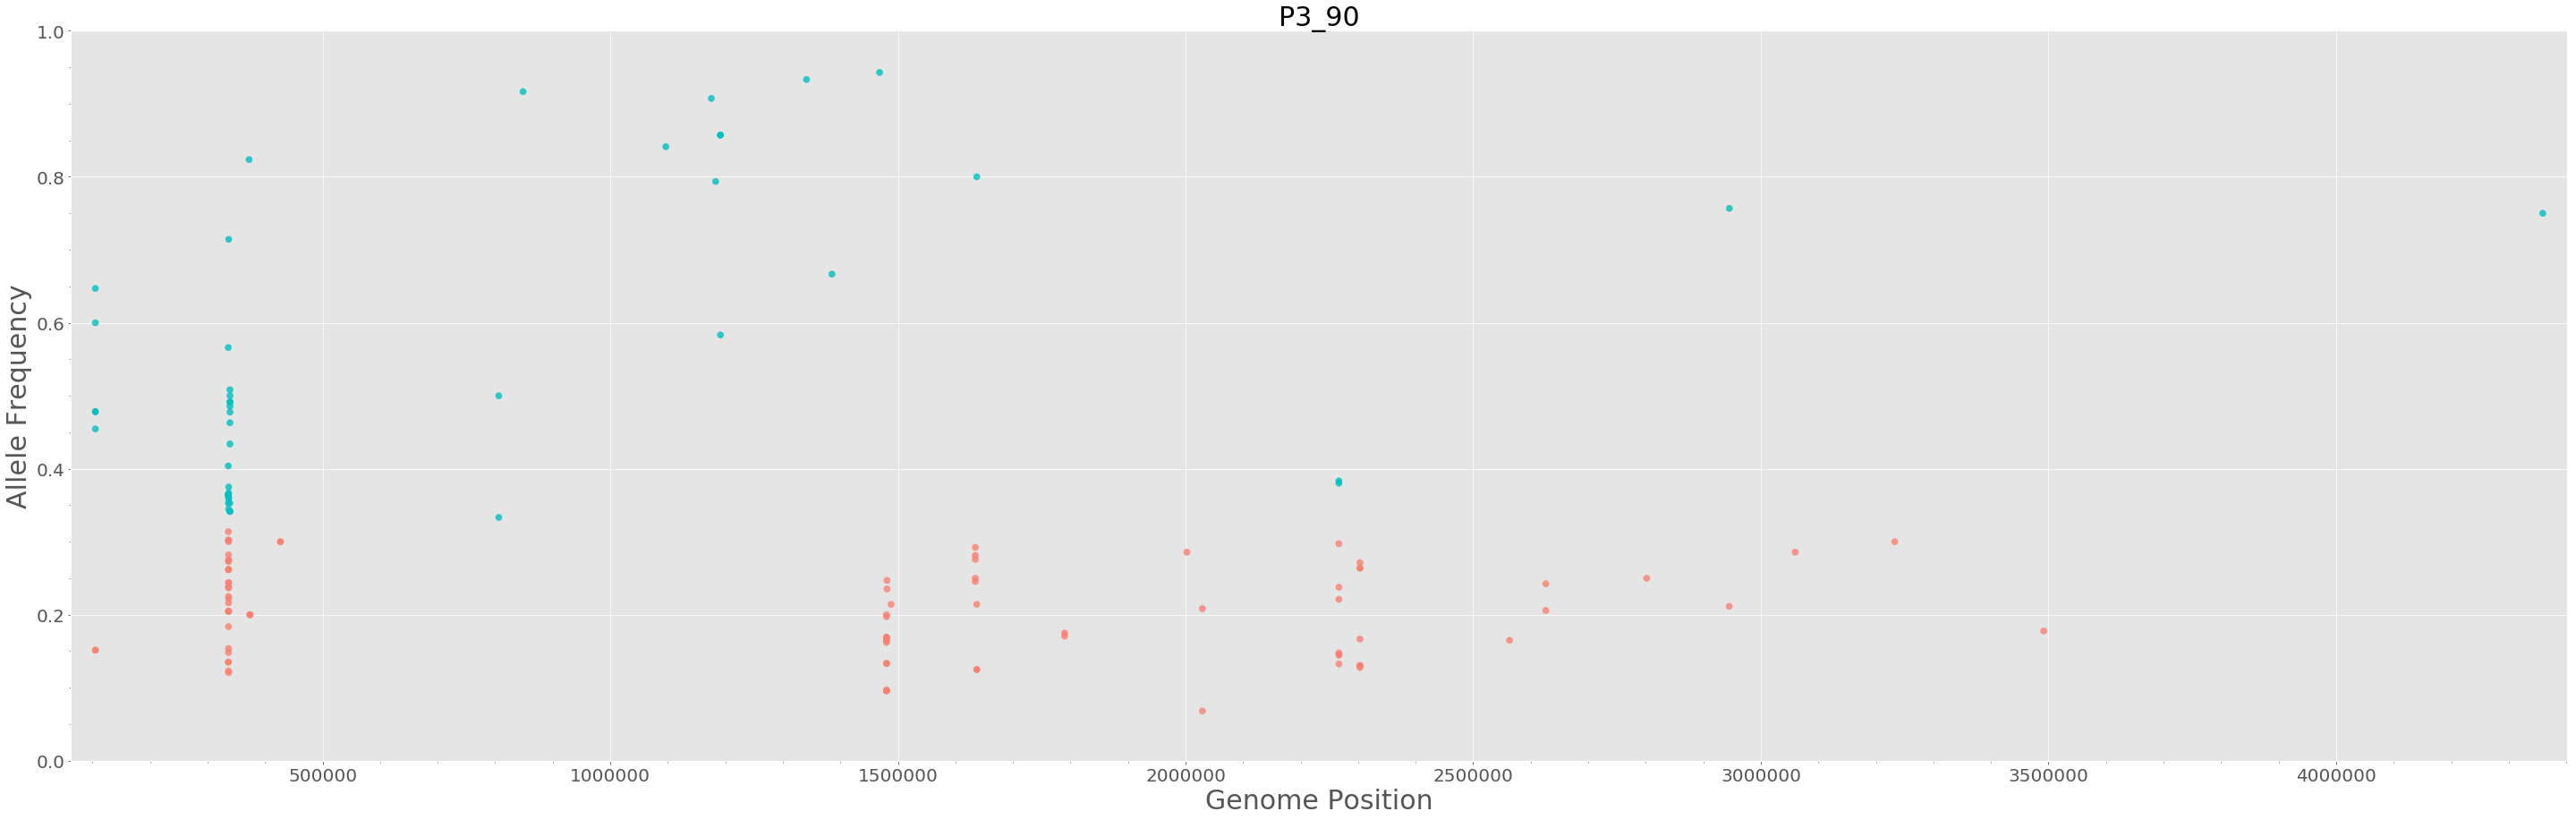

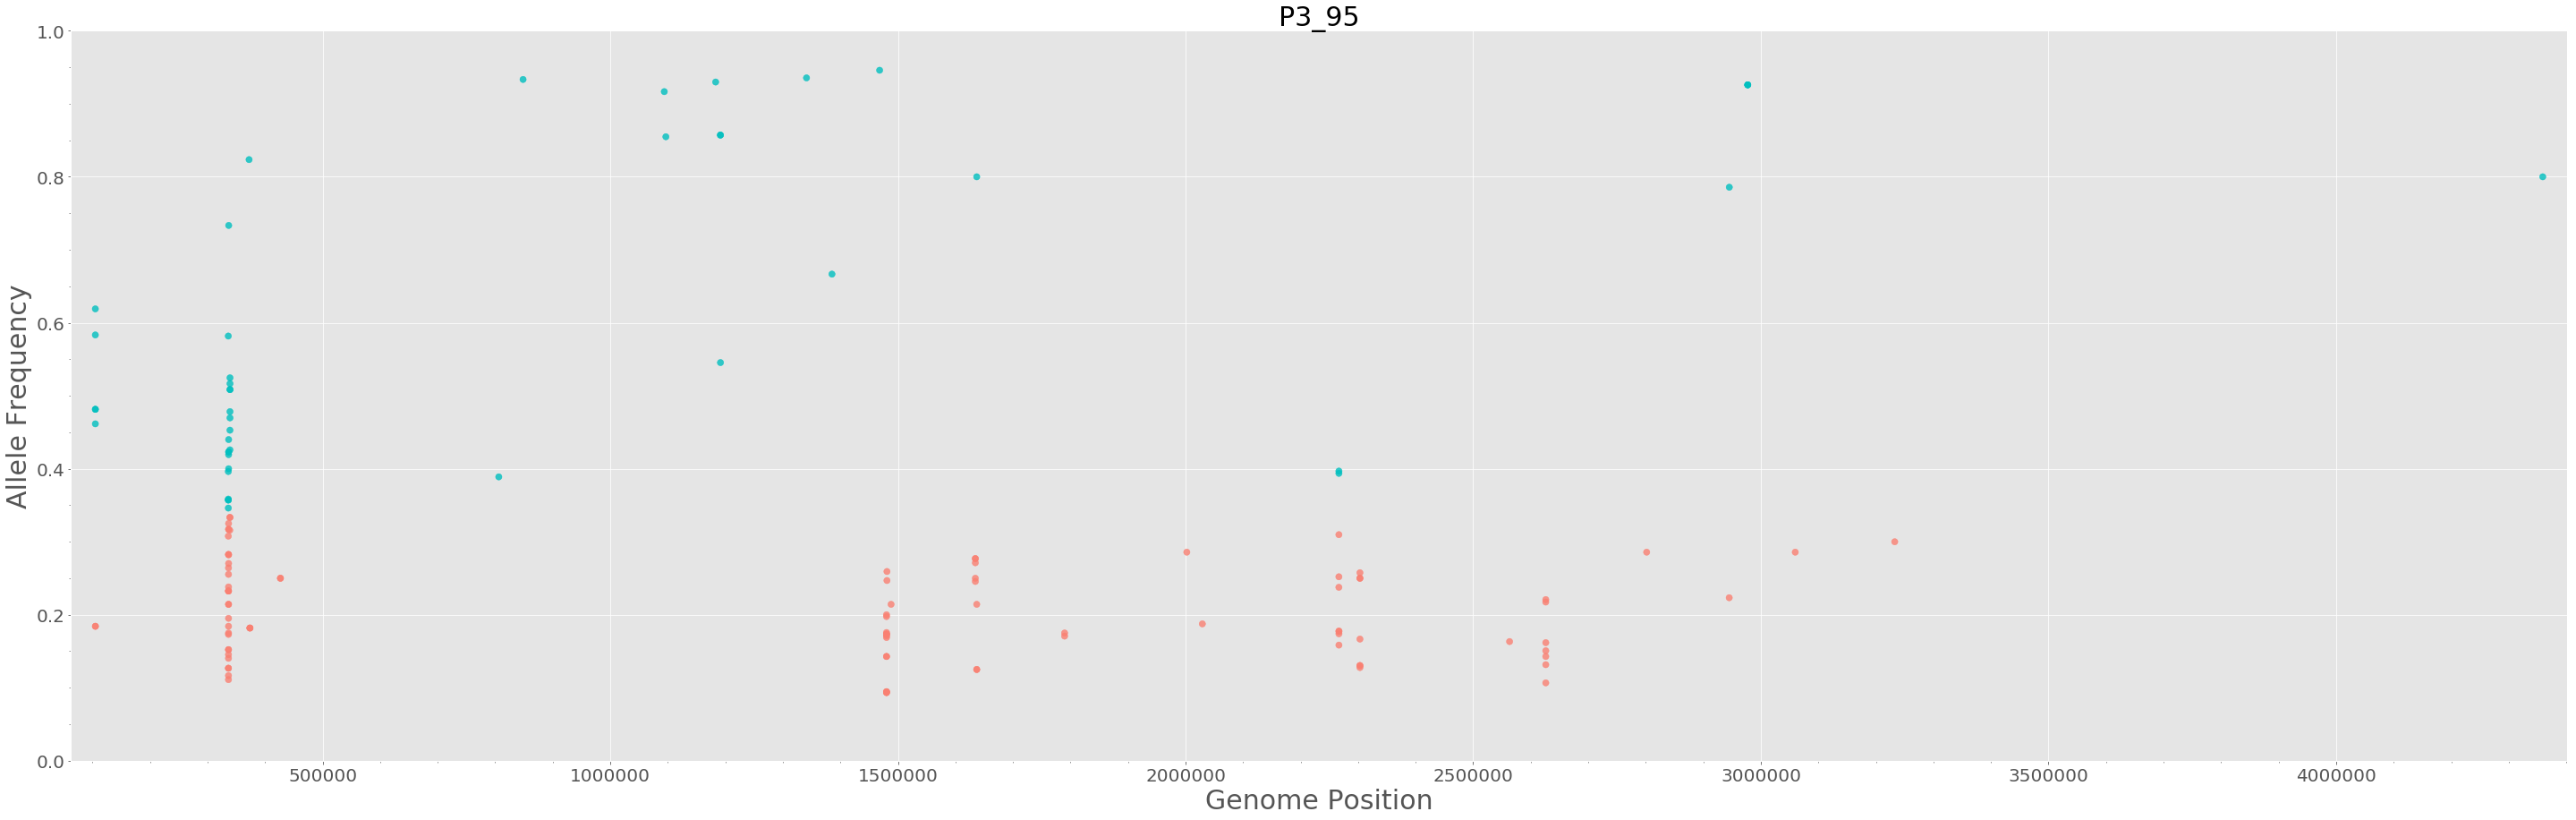

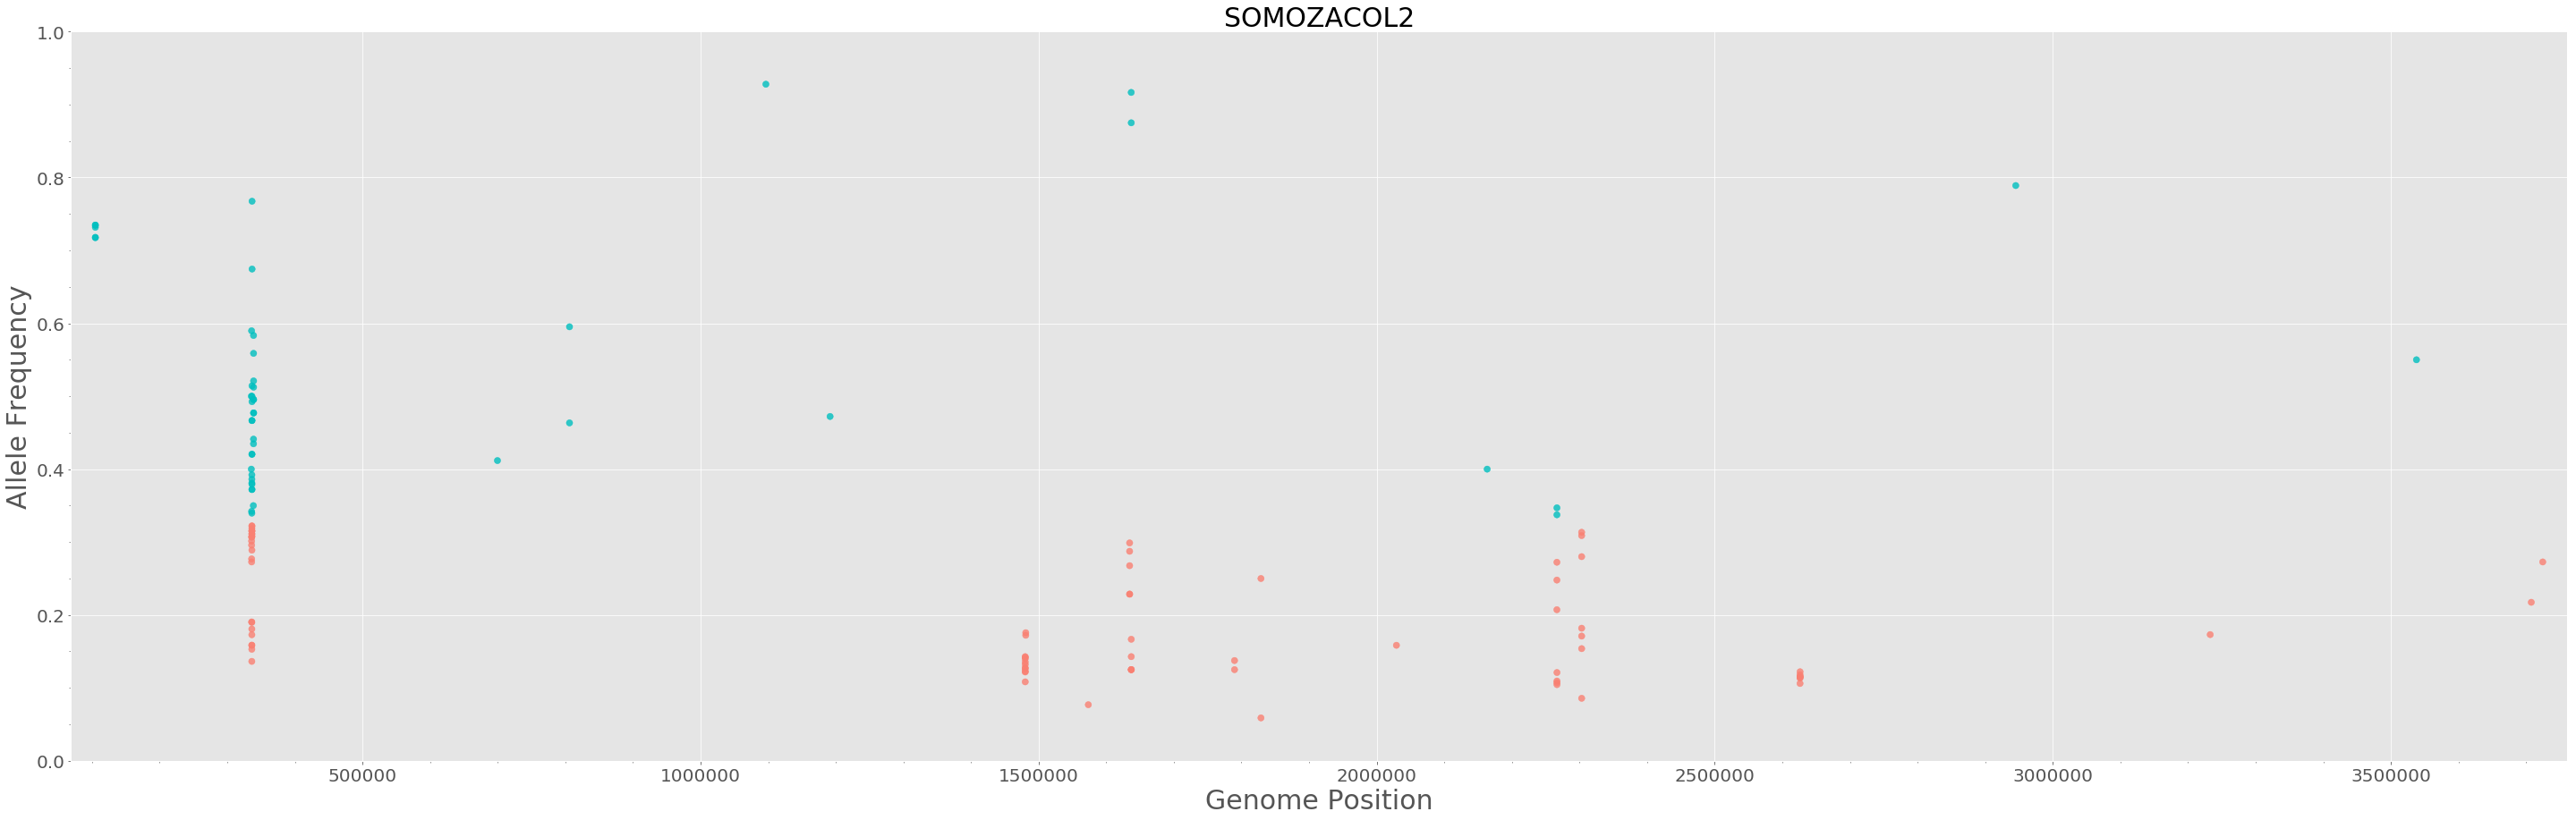

In [287]:
for name_dsf, df in dict_vcf.items():
    scatter_vcf_pos(df,name_dsf)

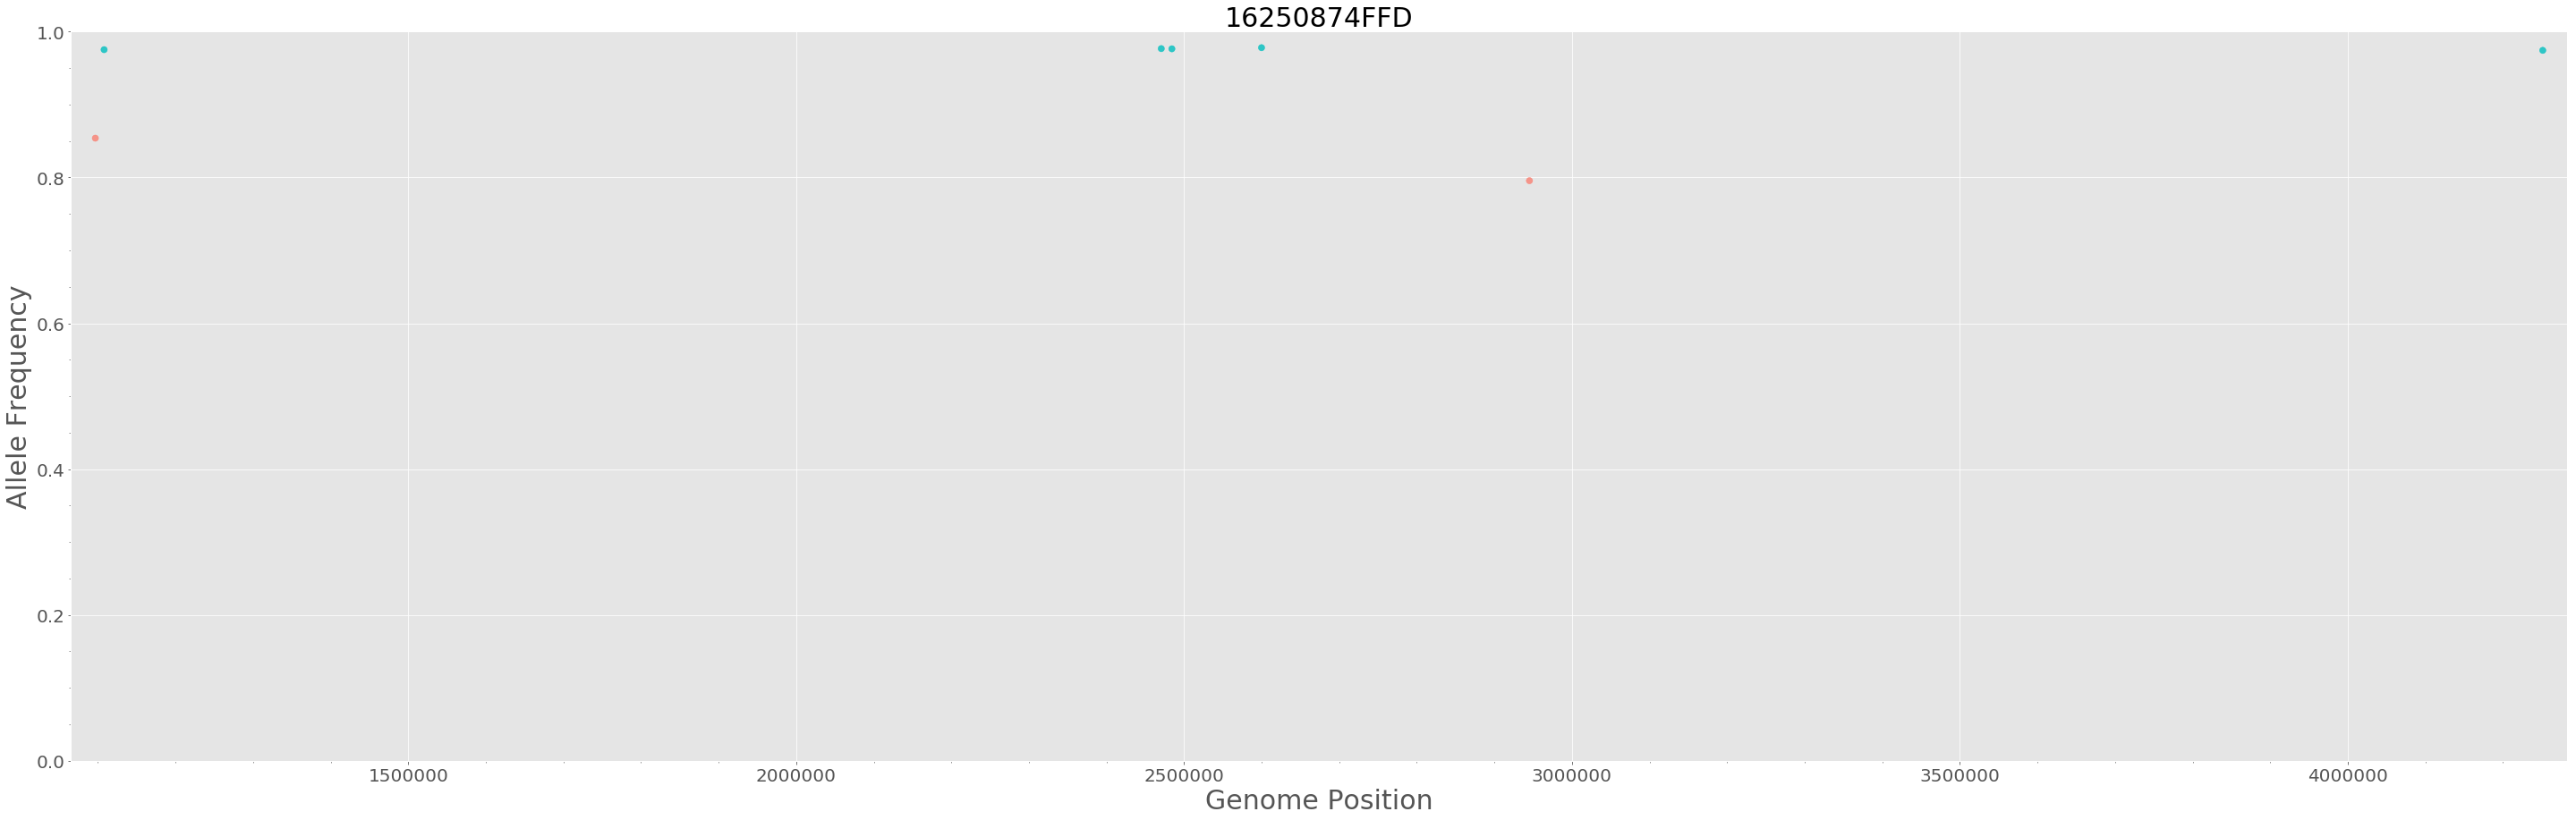

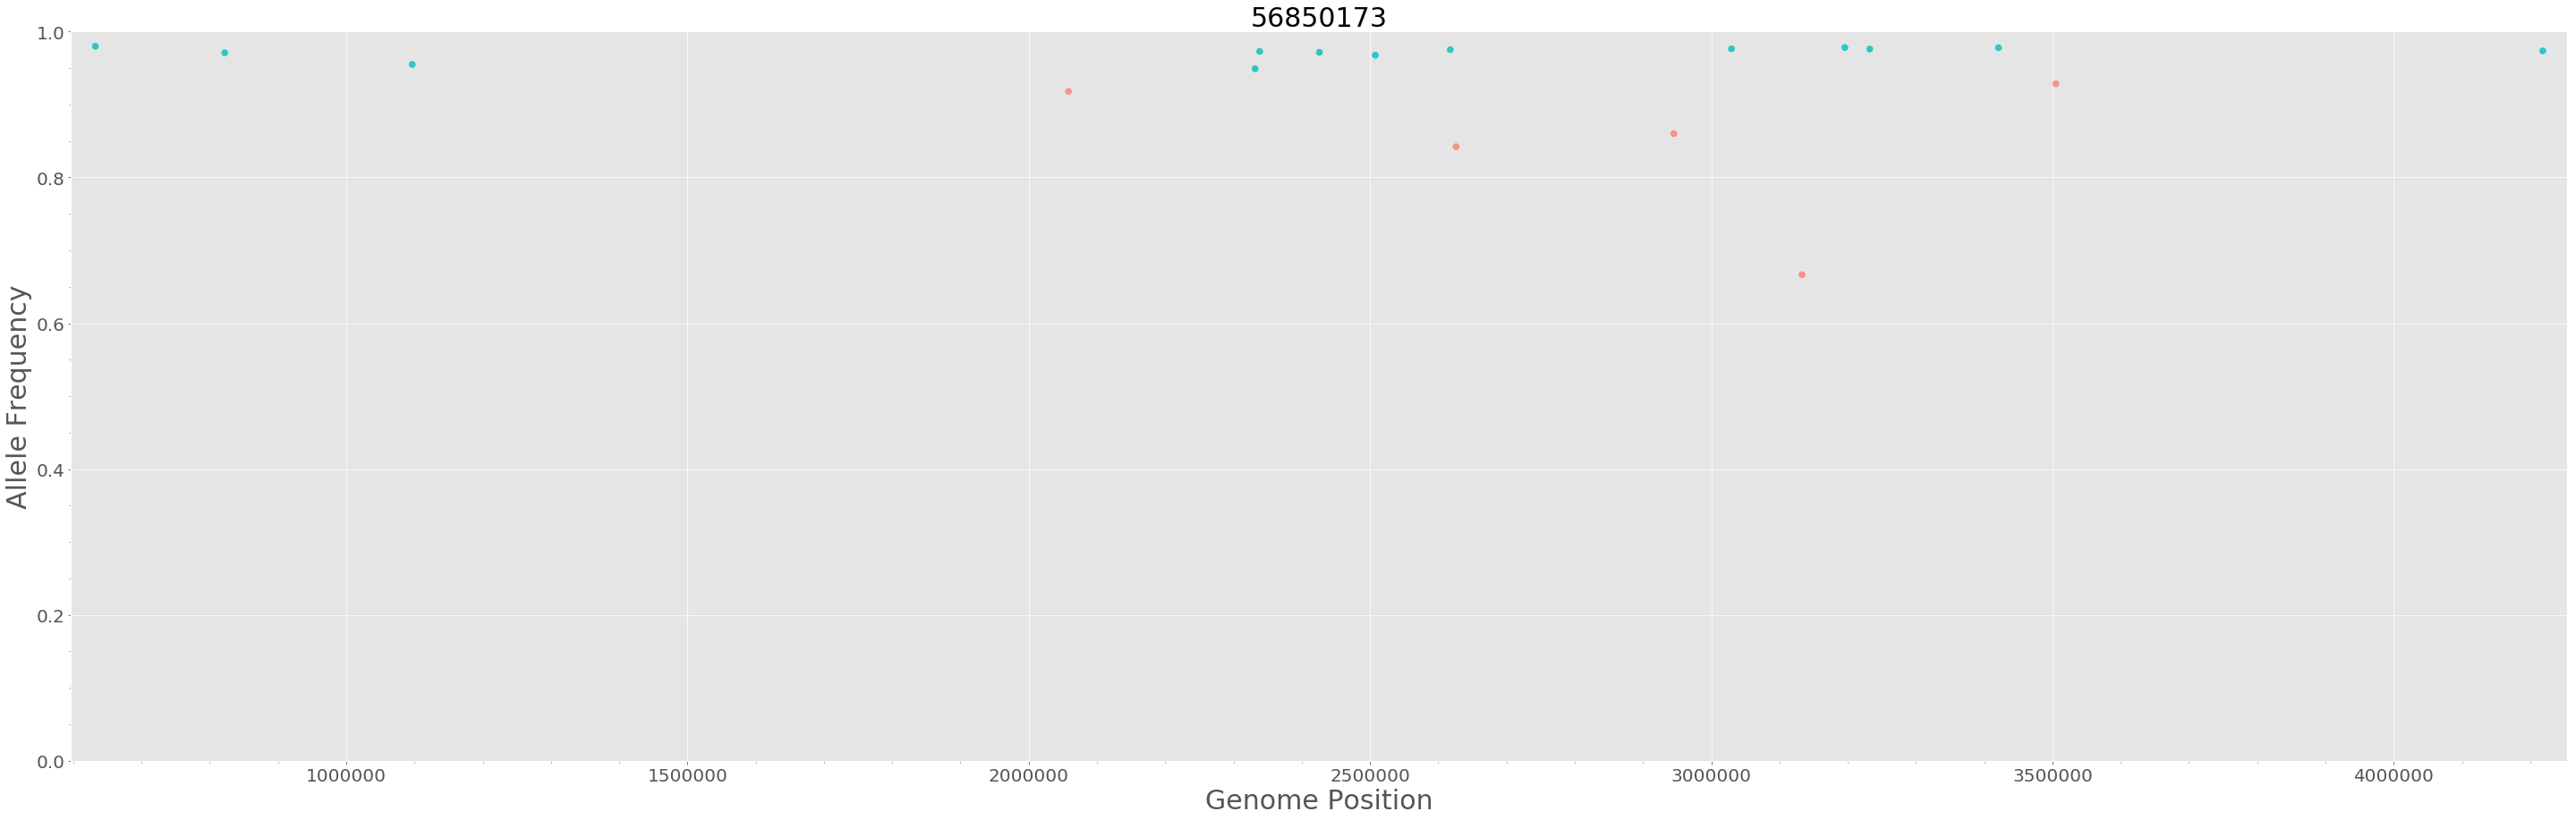

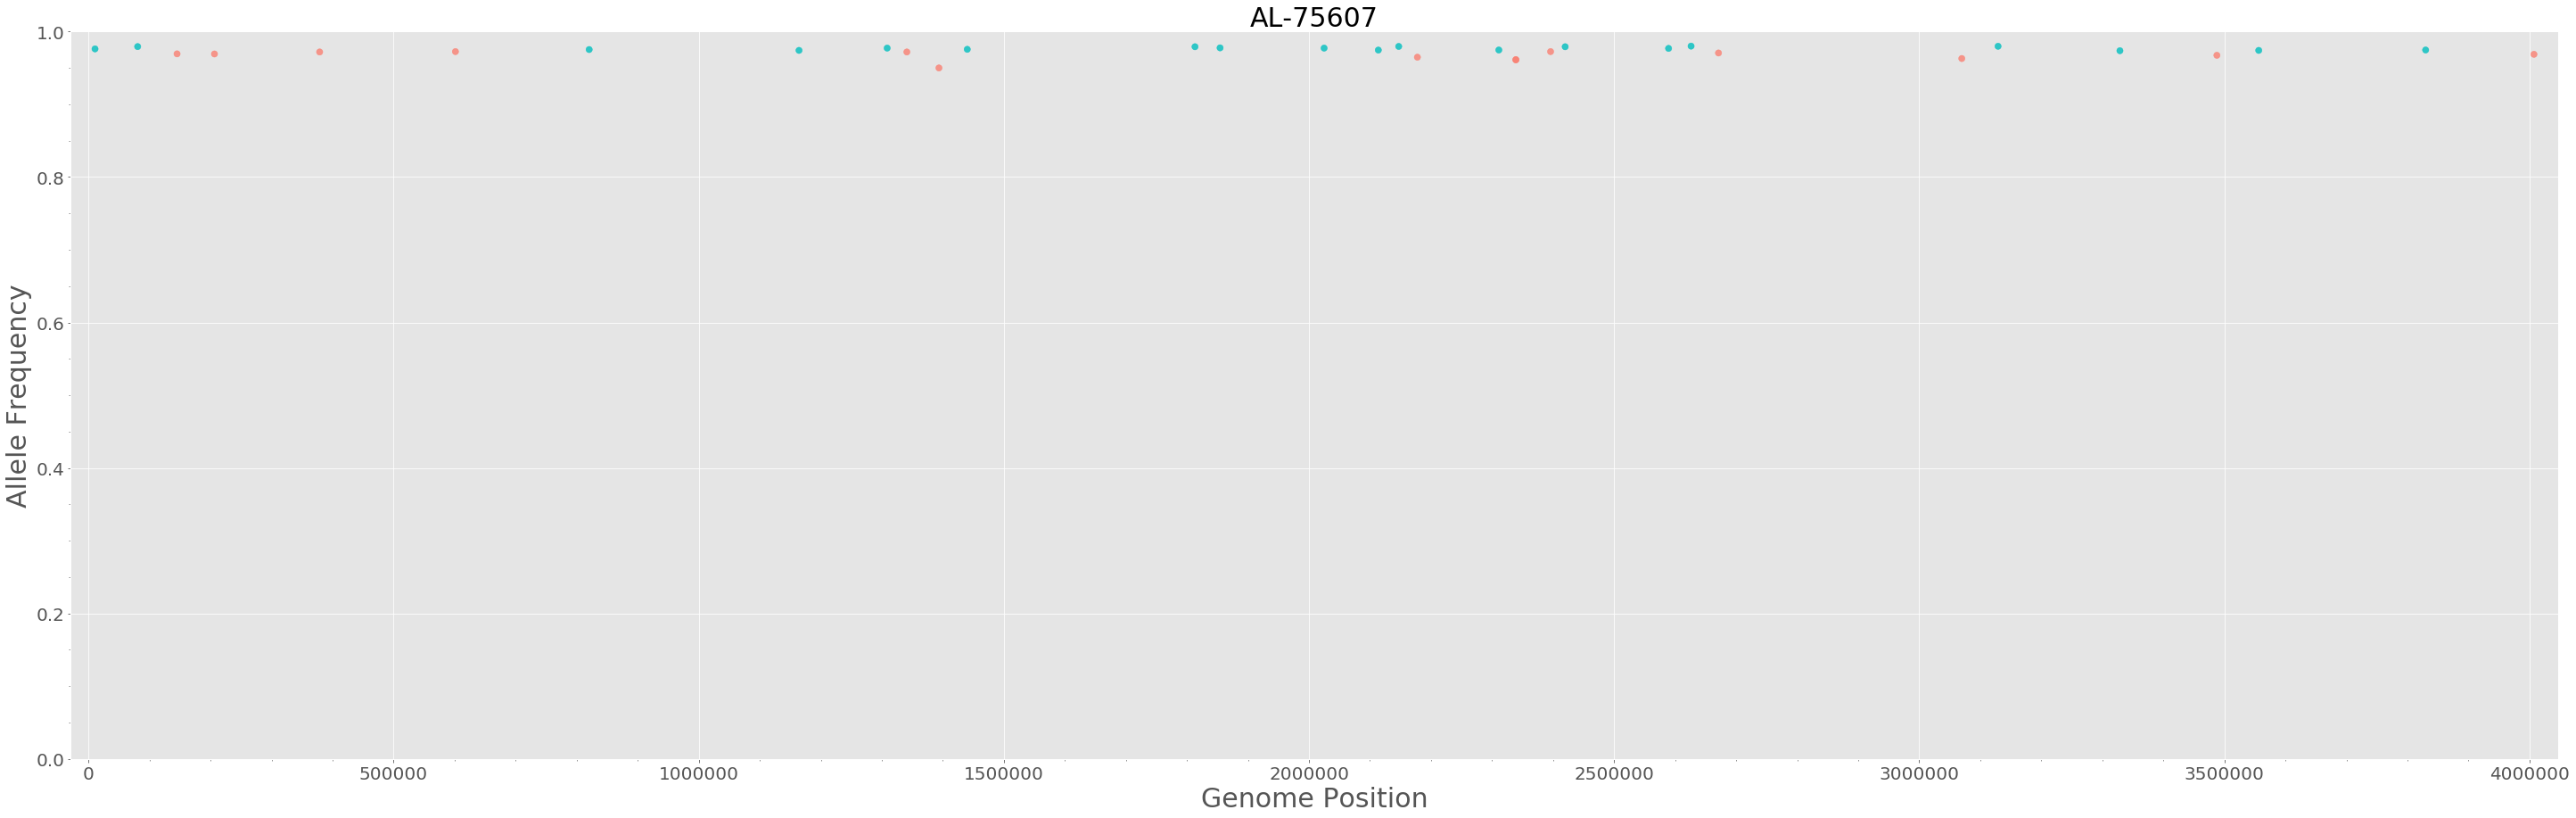

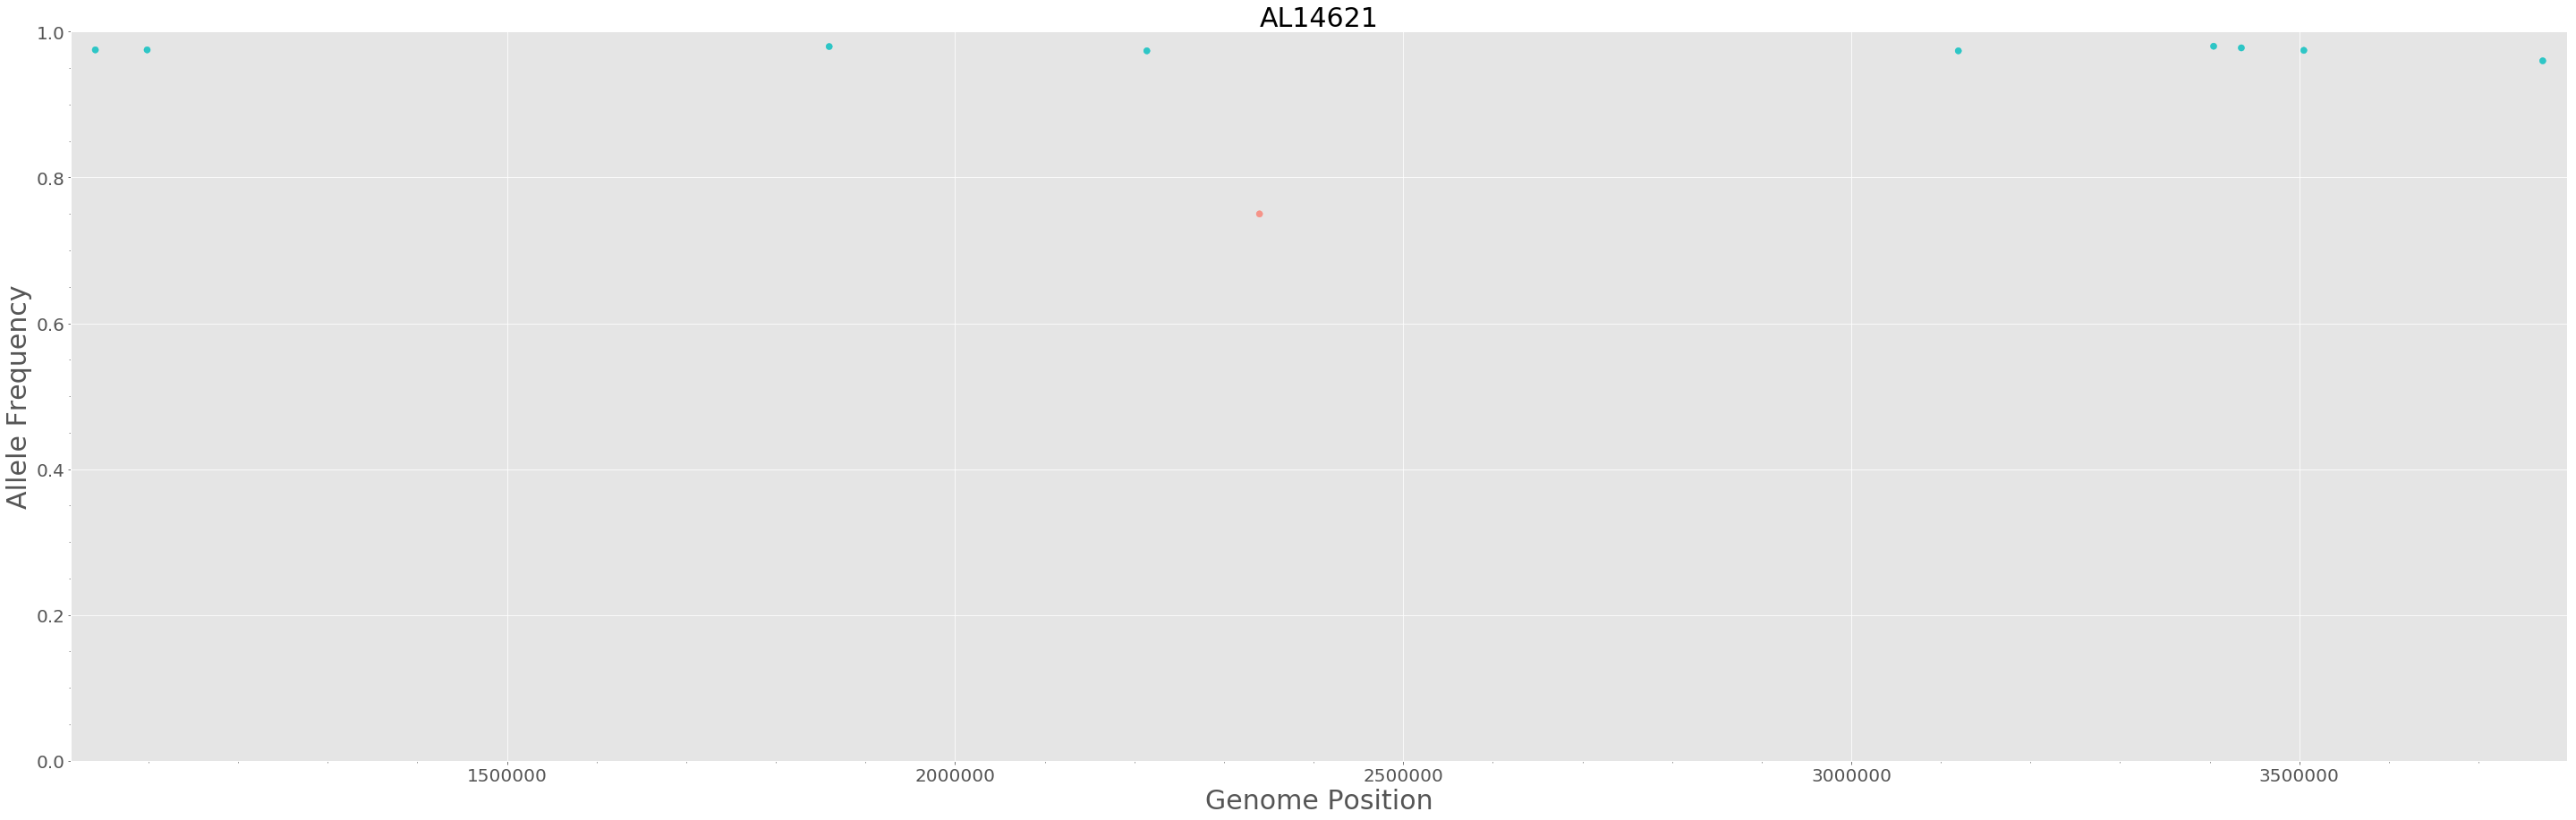

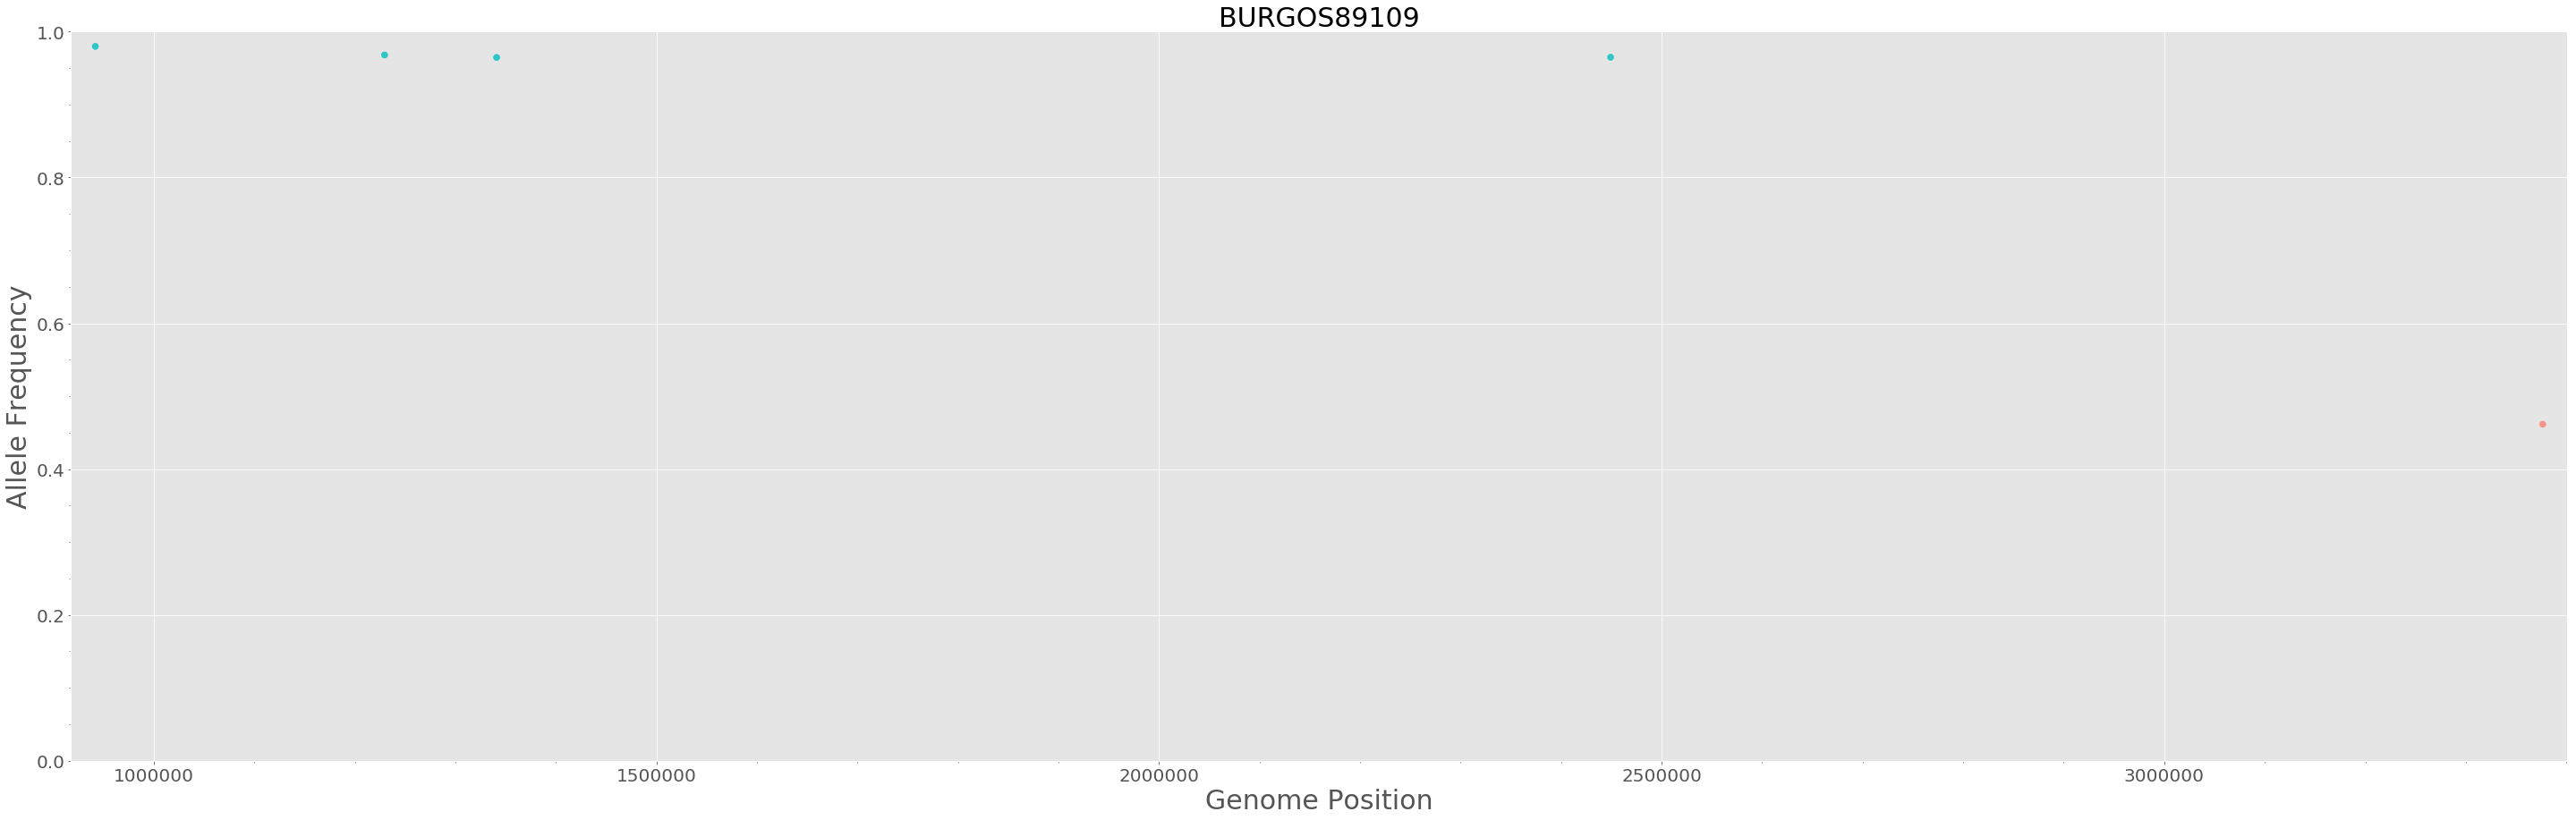

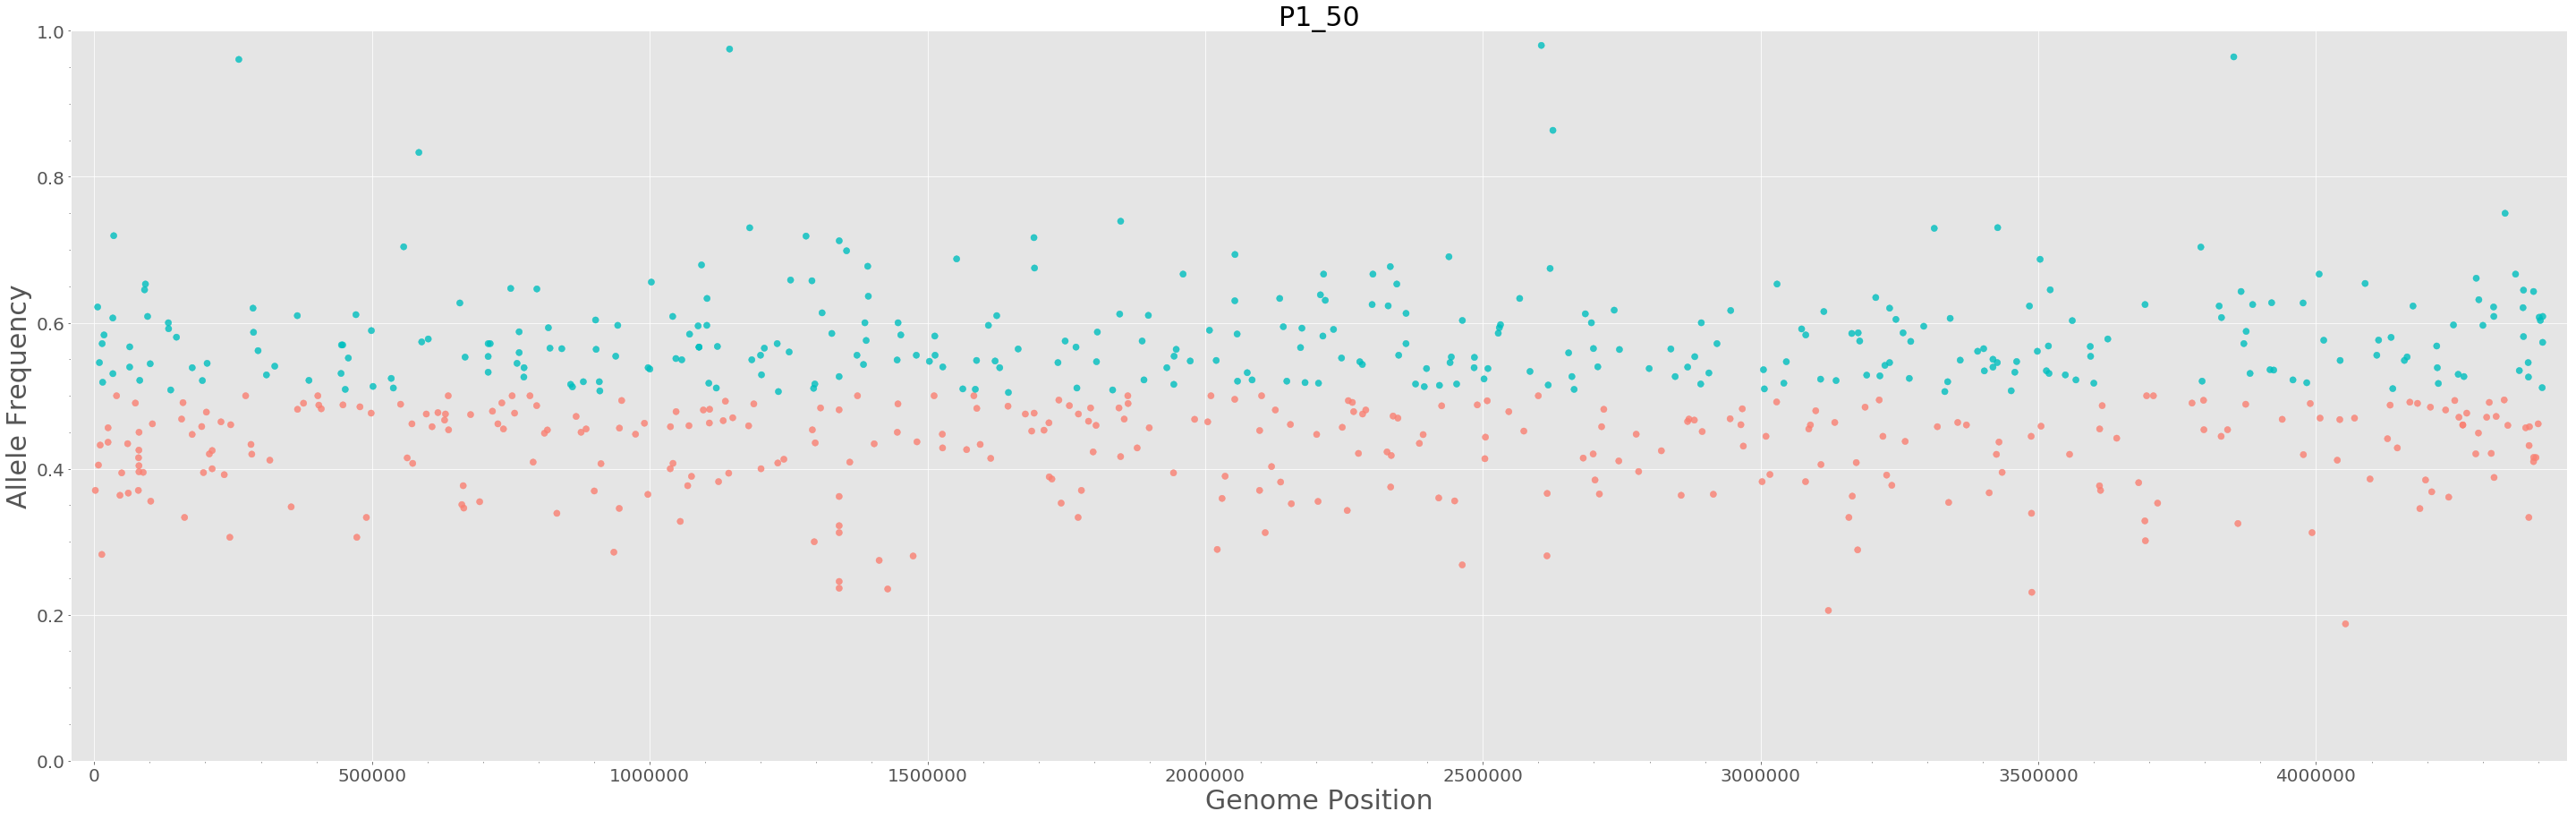

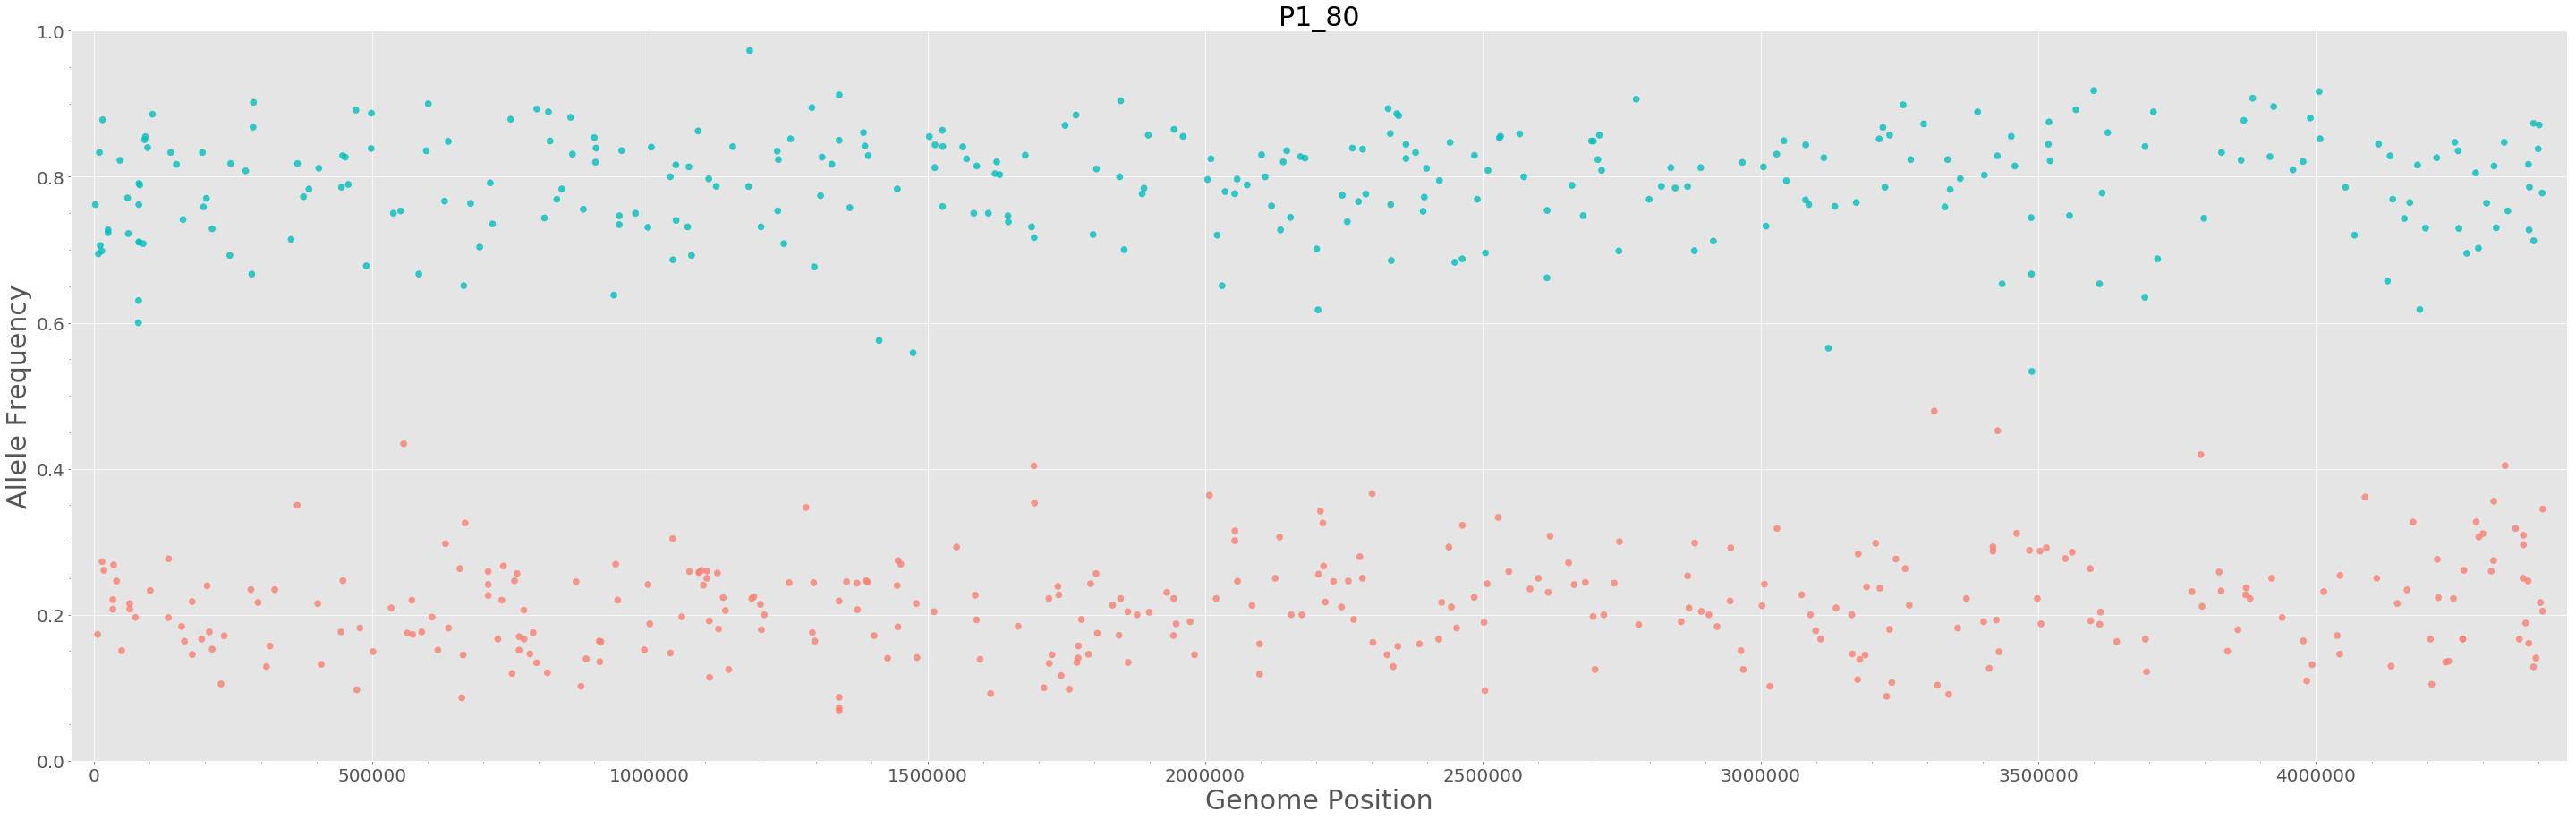

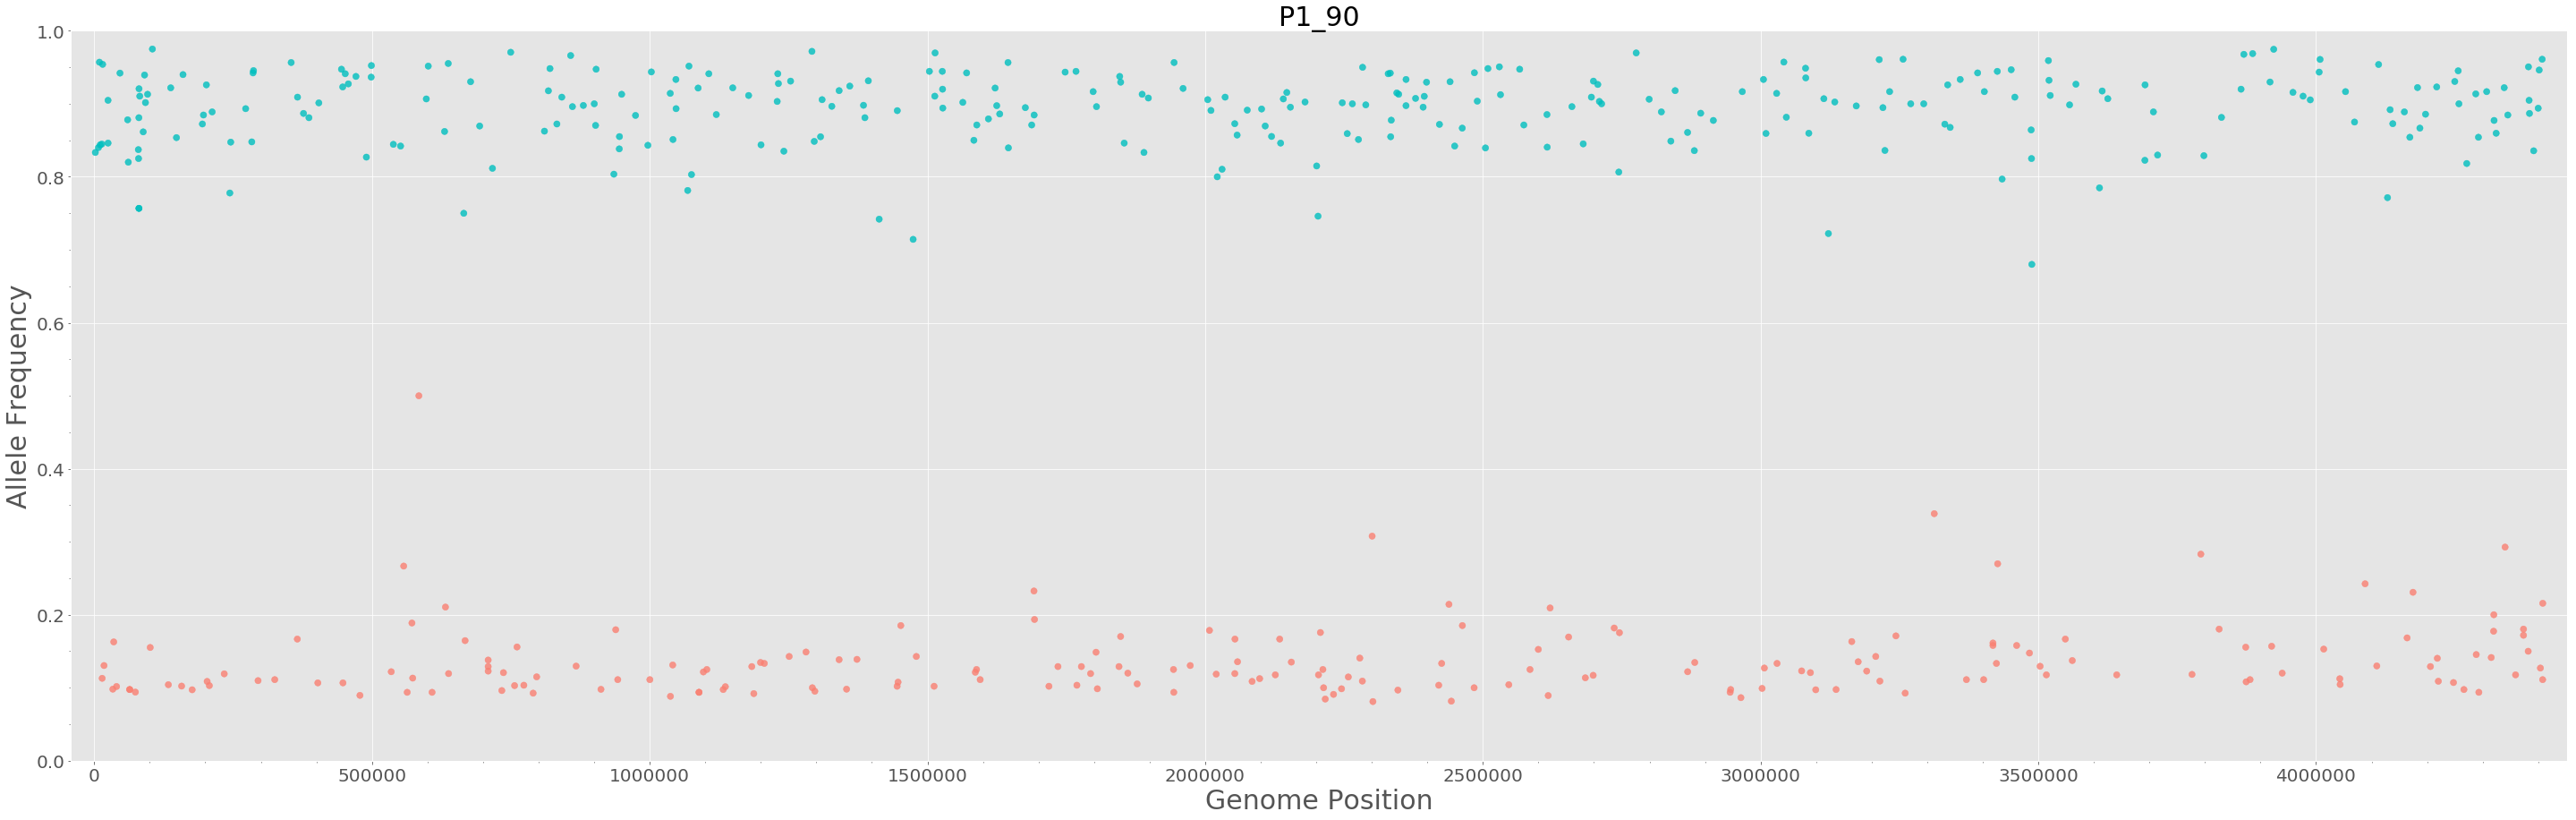

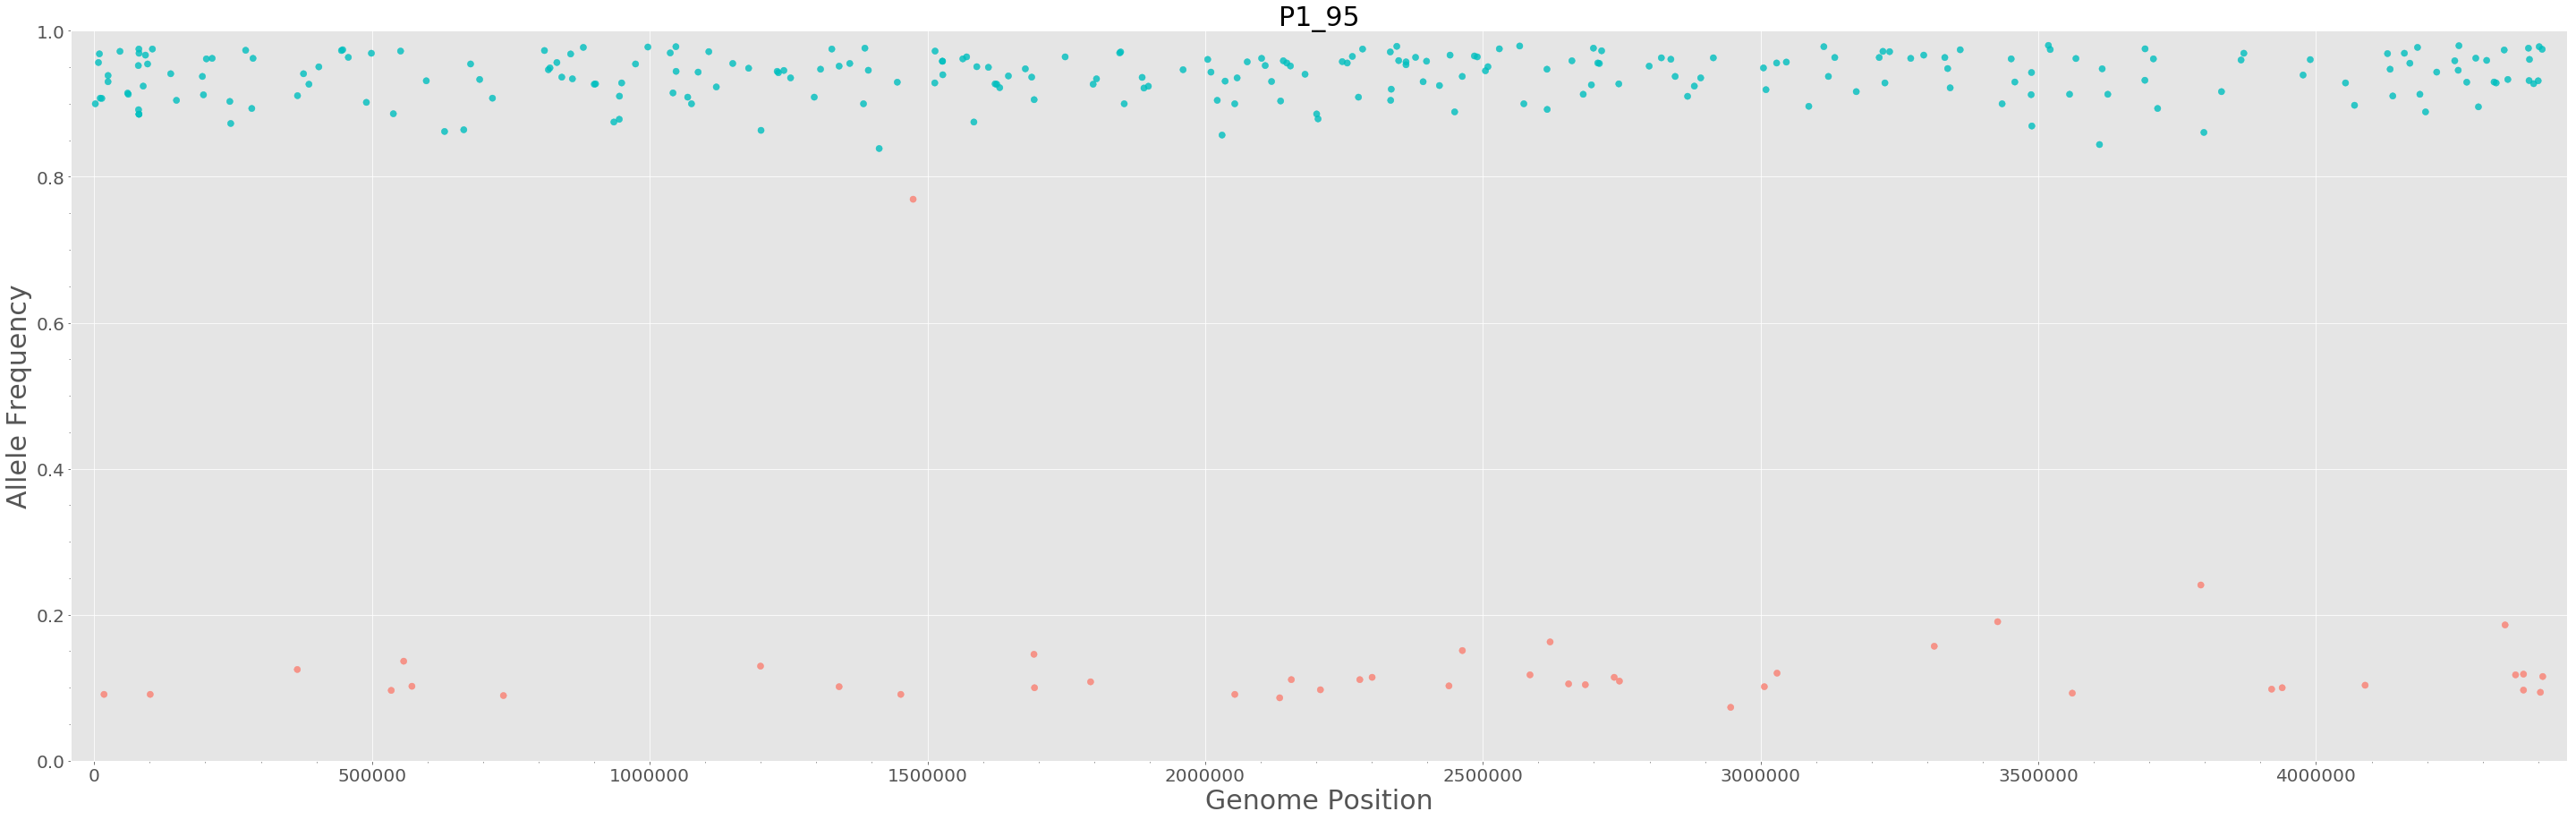

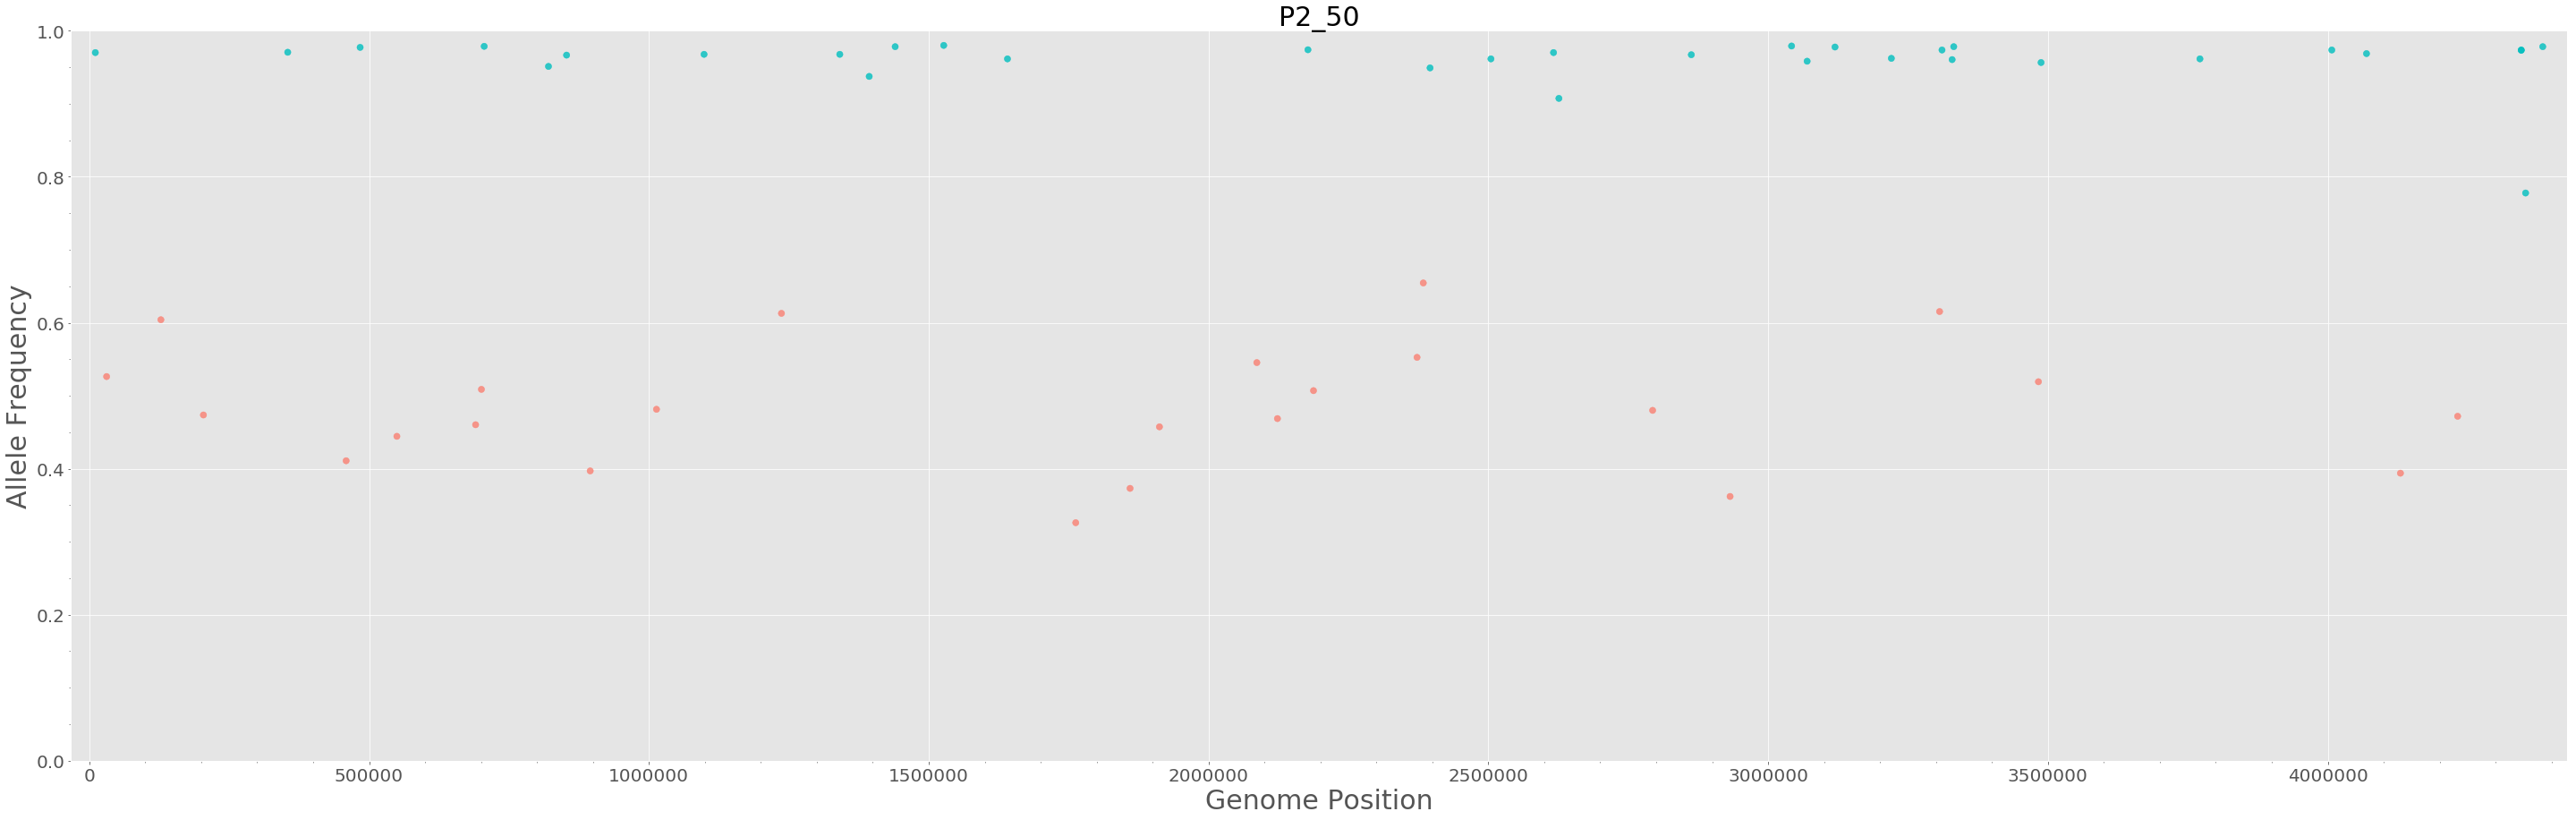

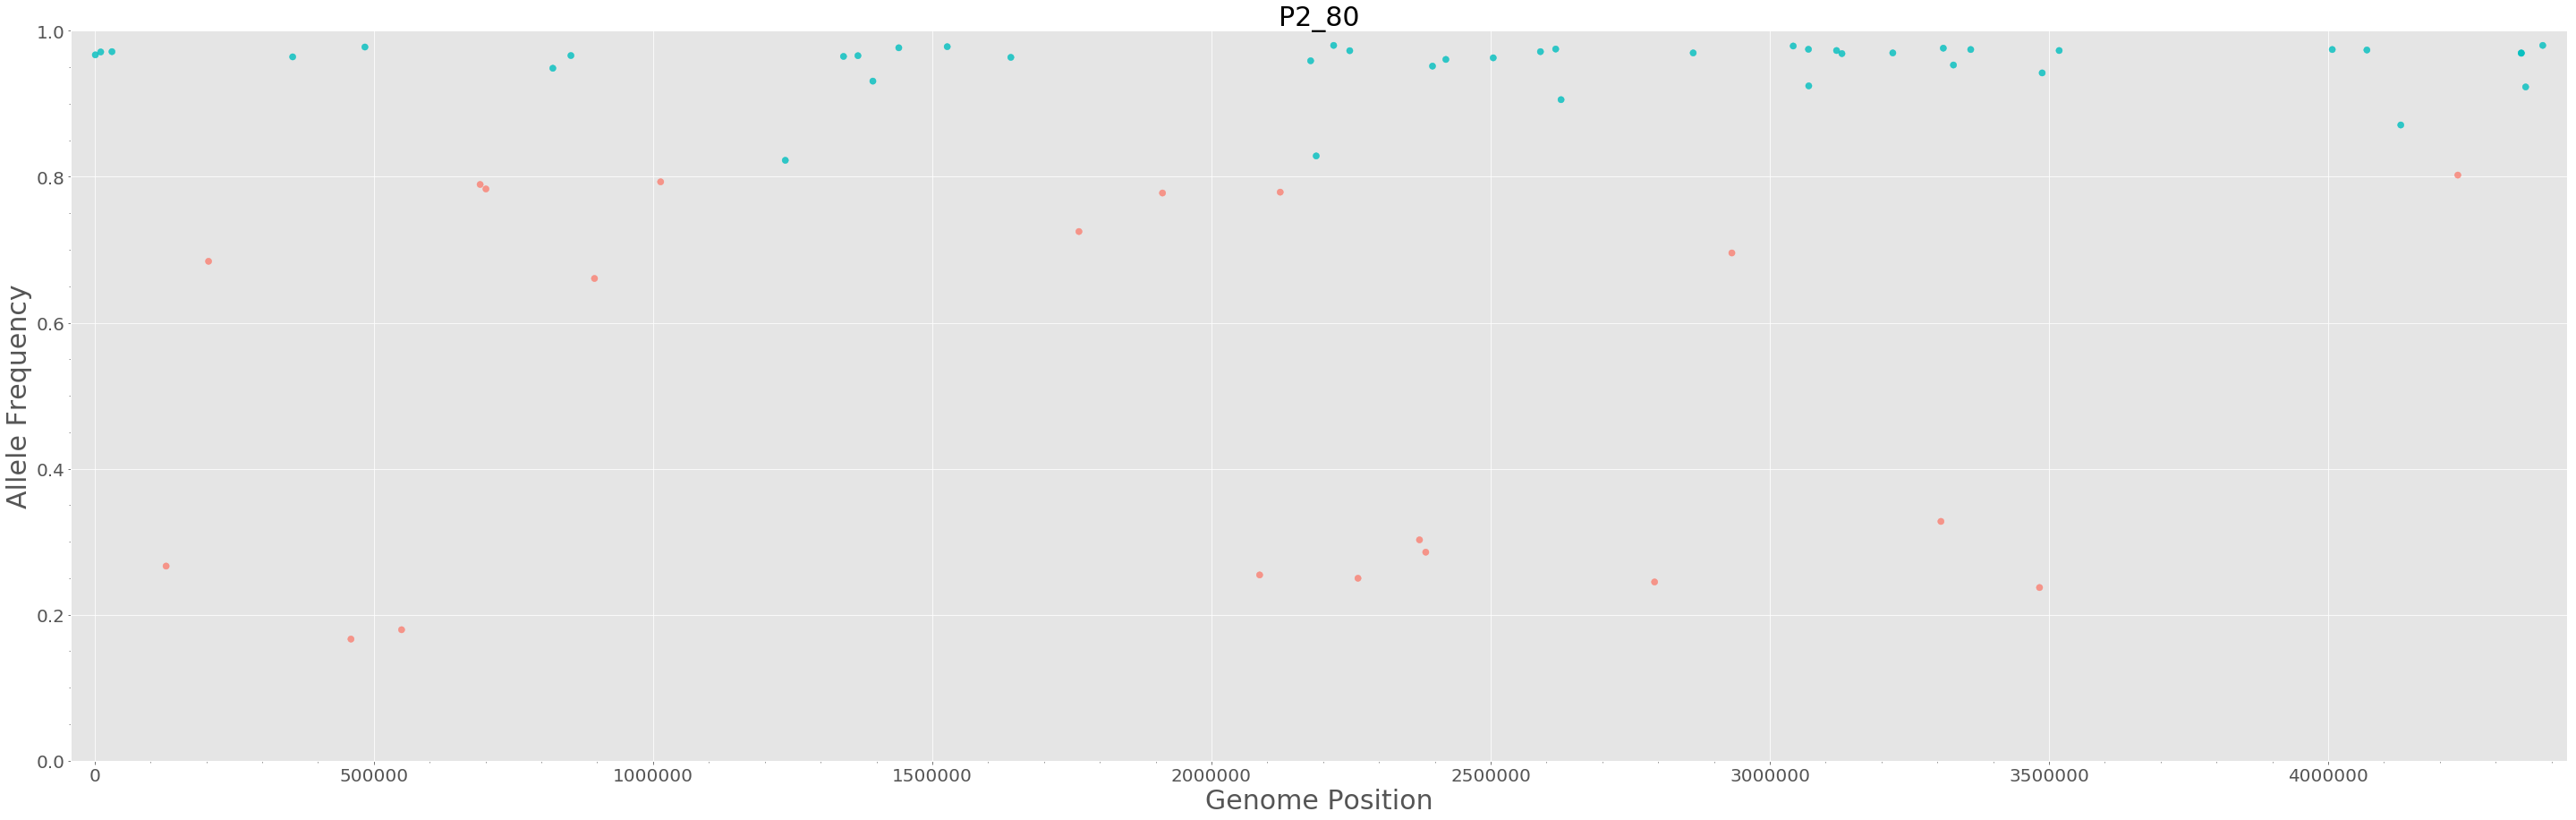

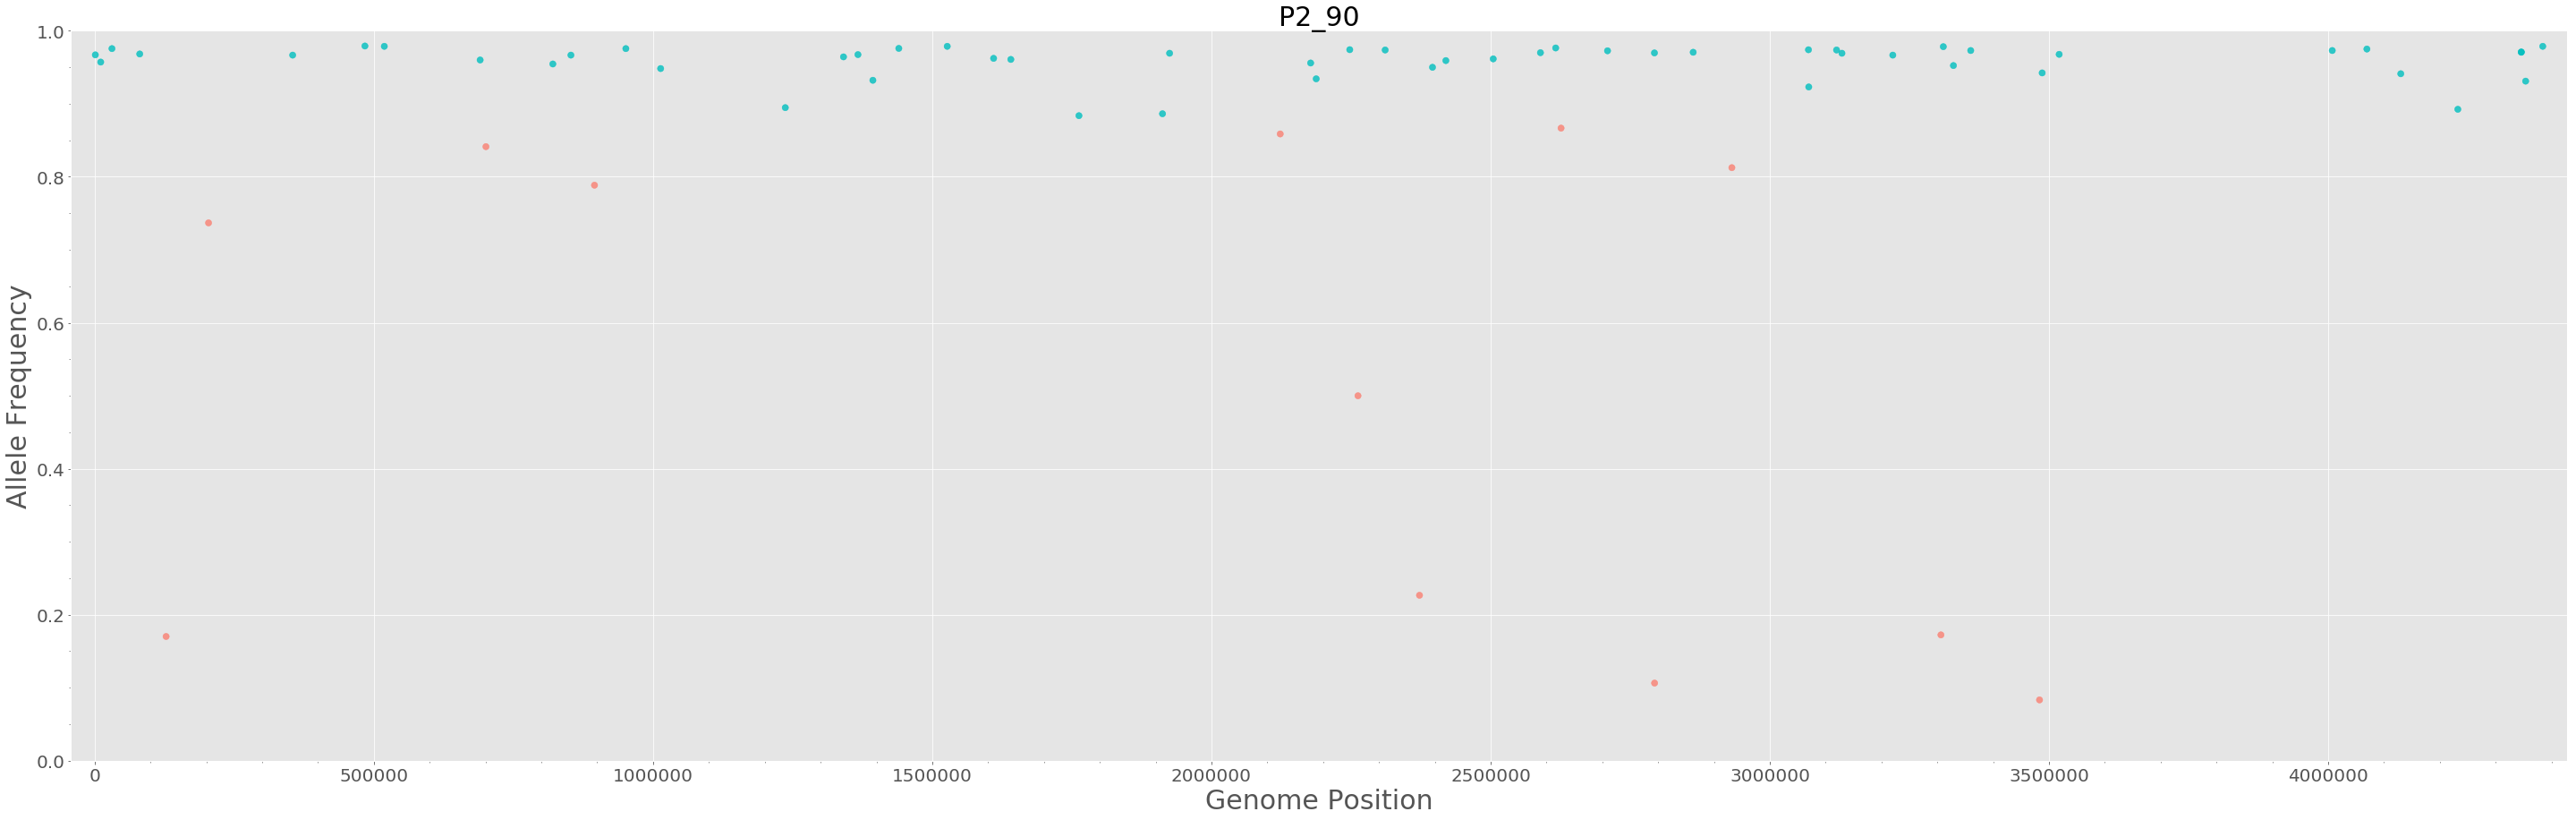

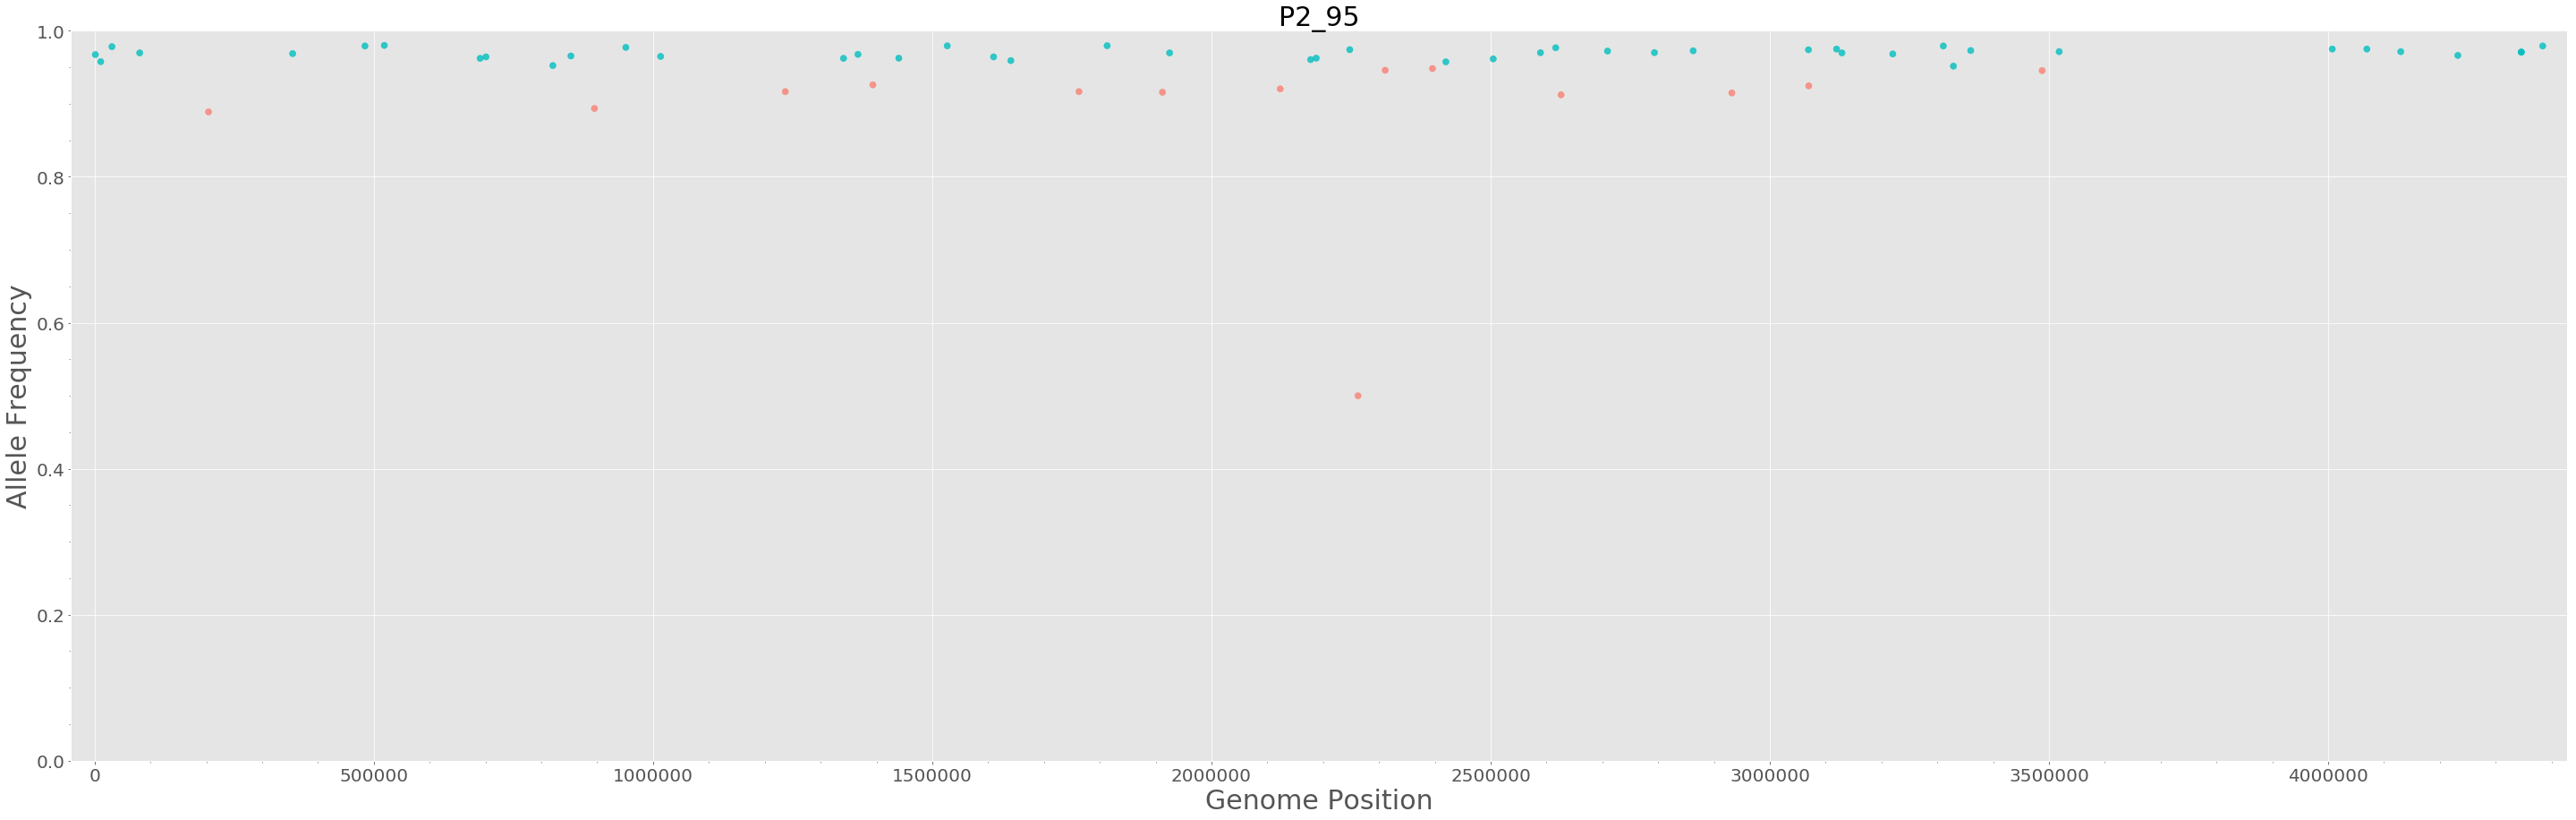

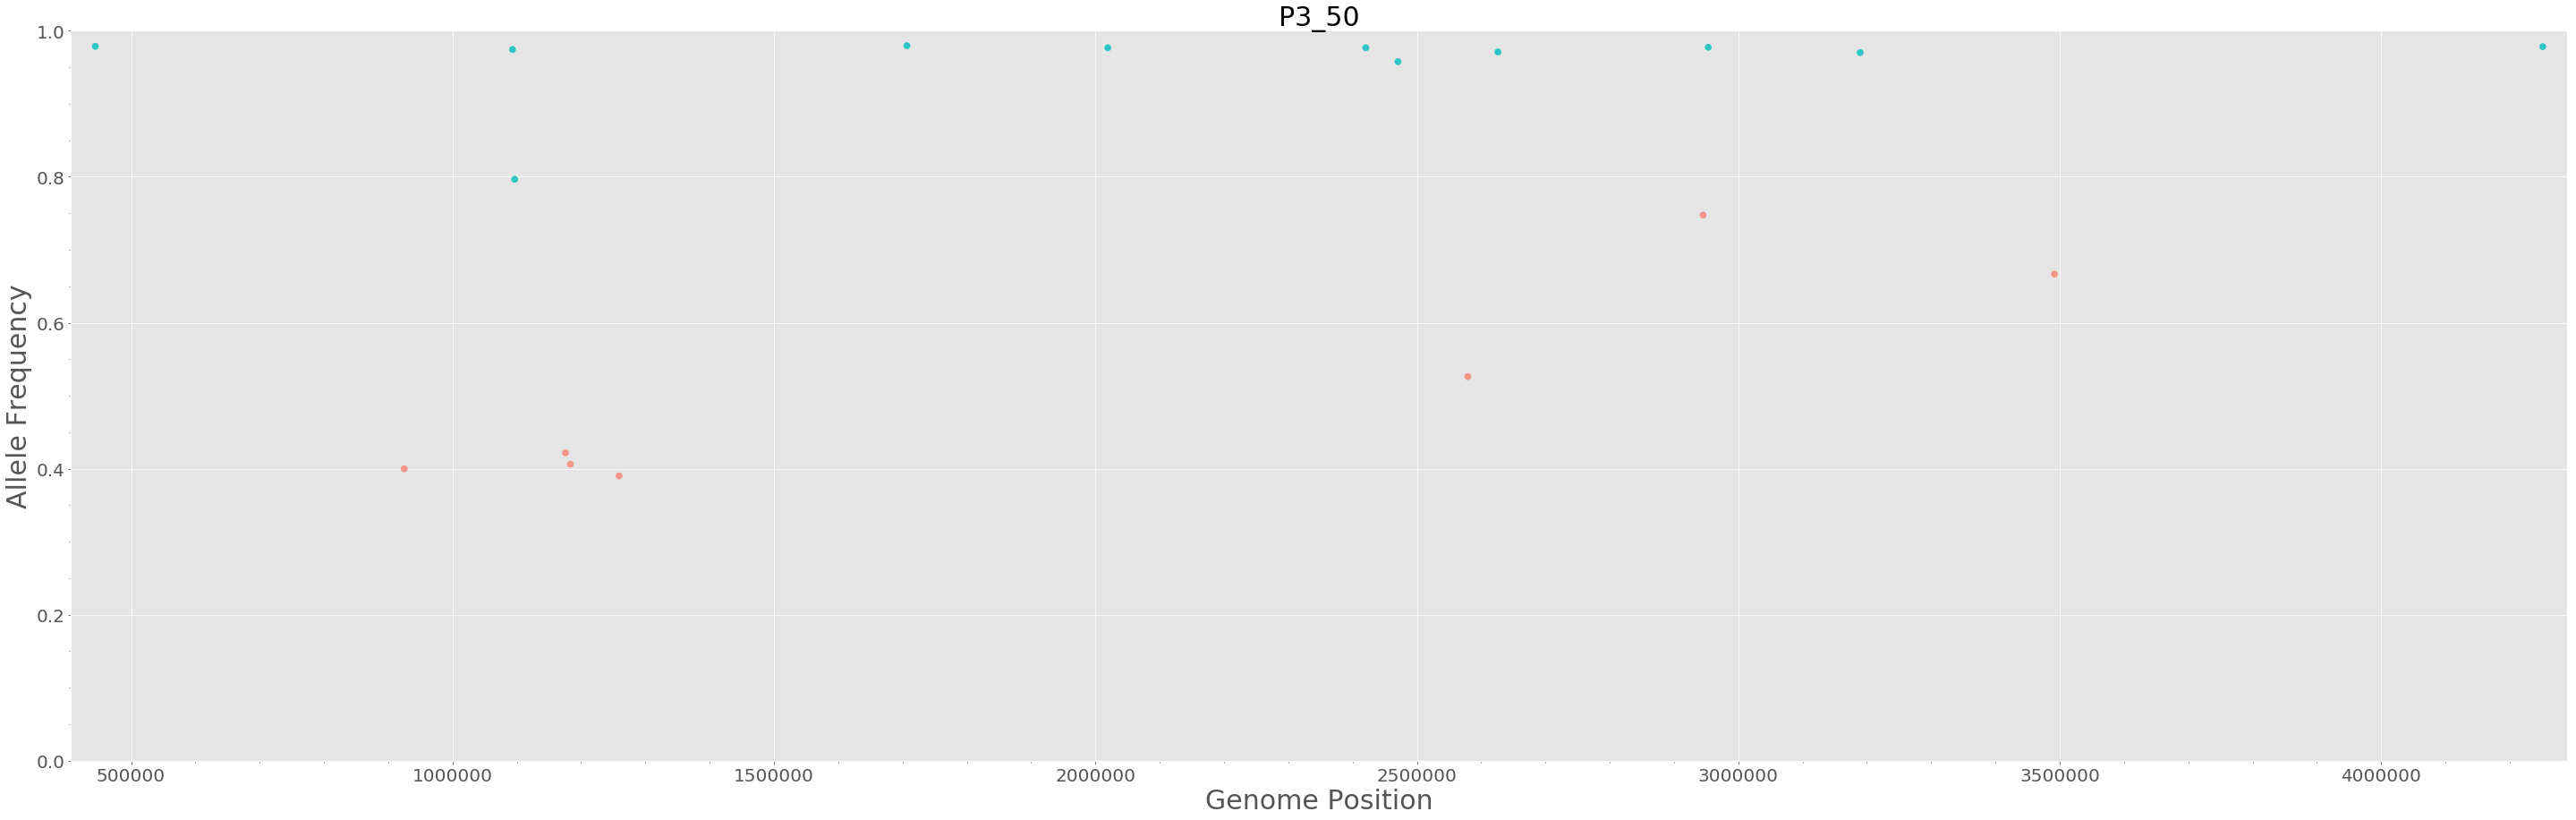

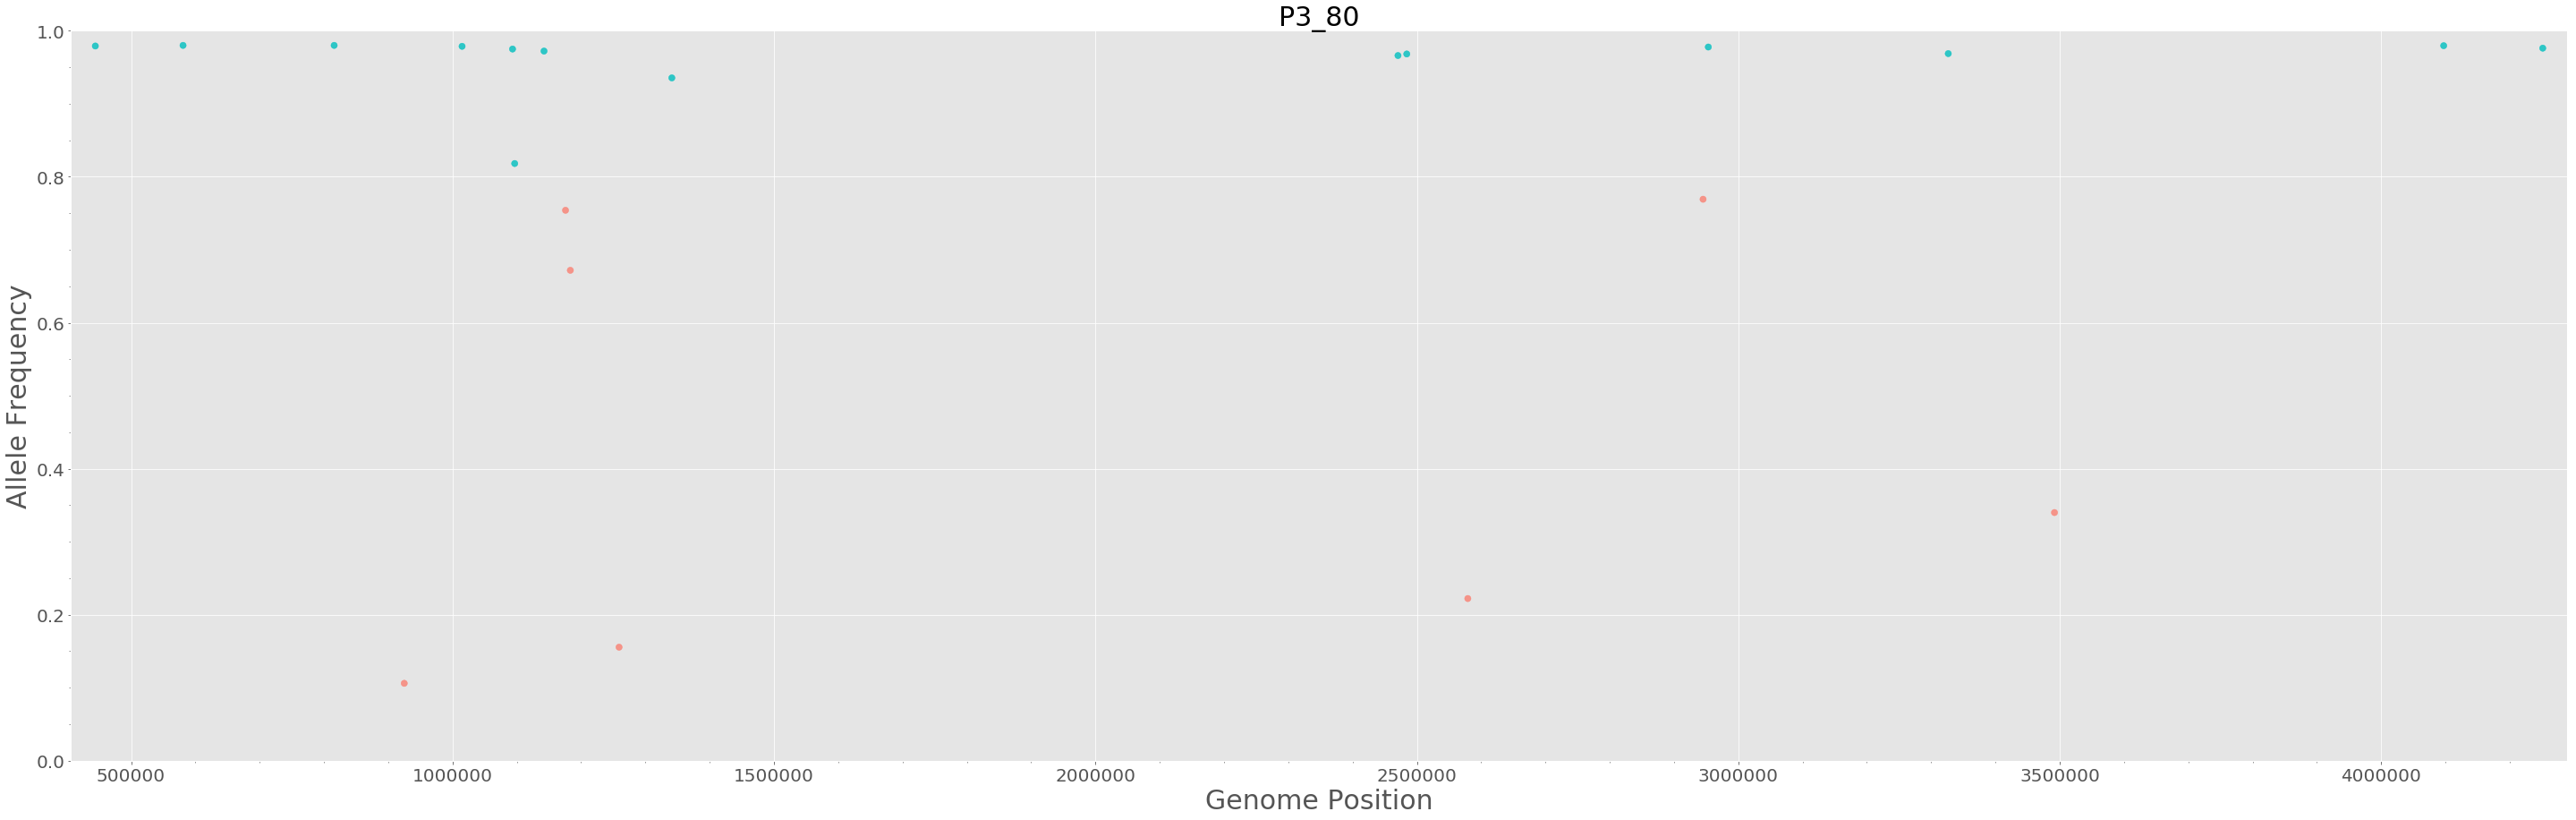

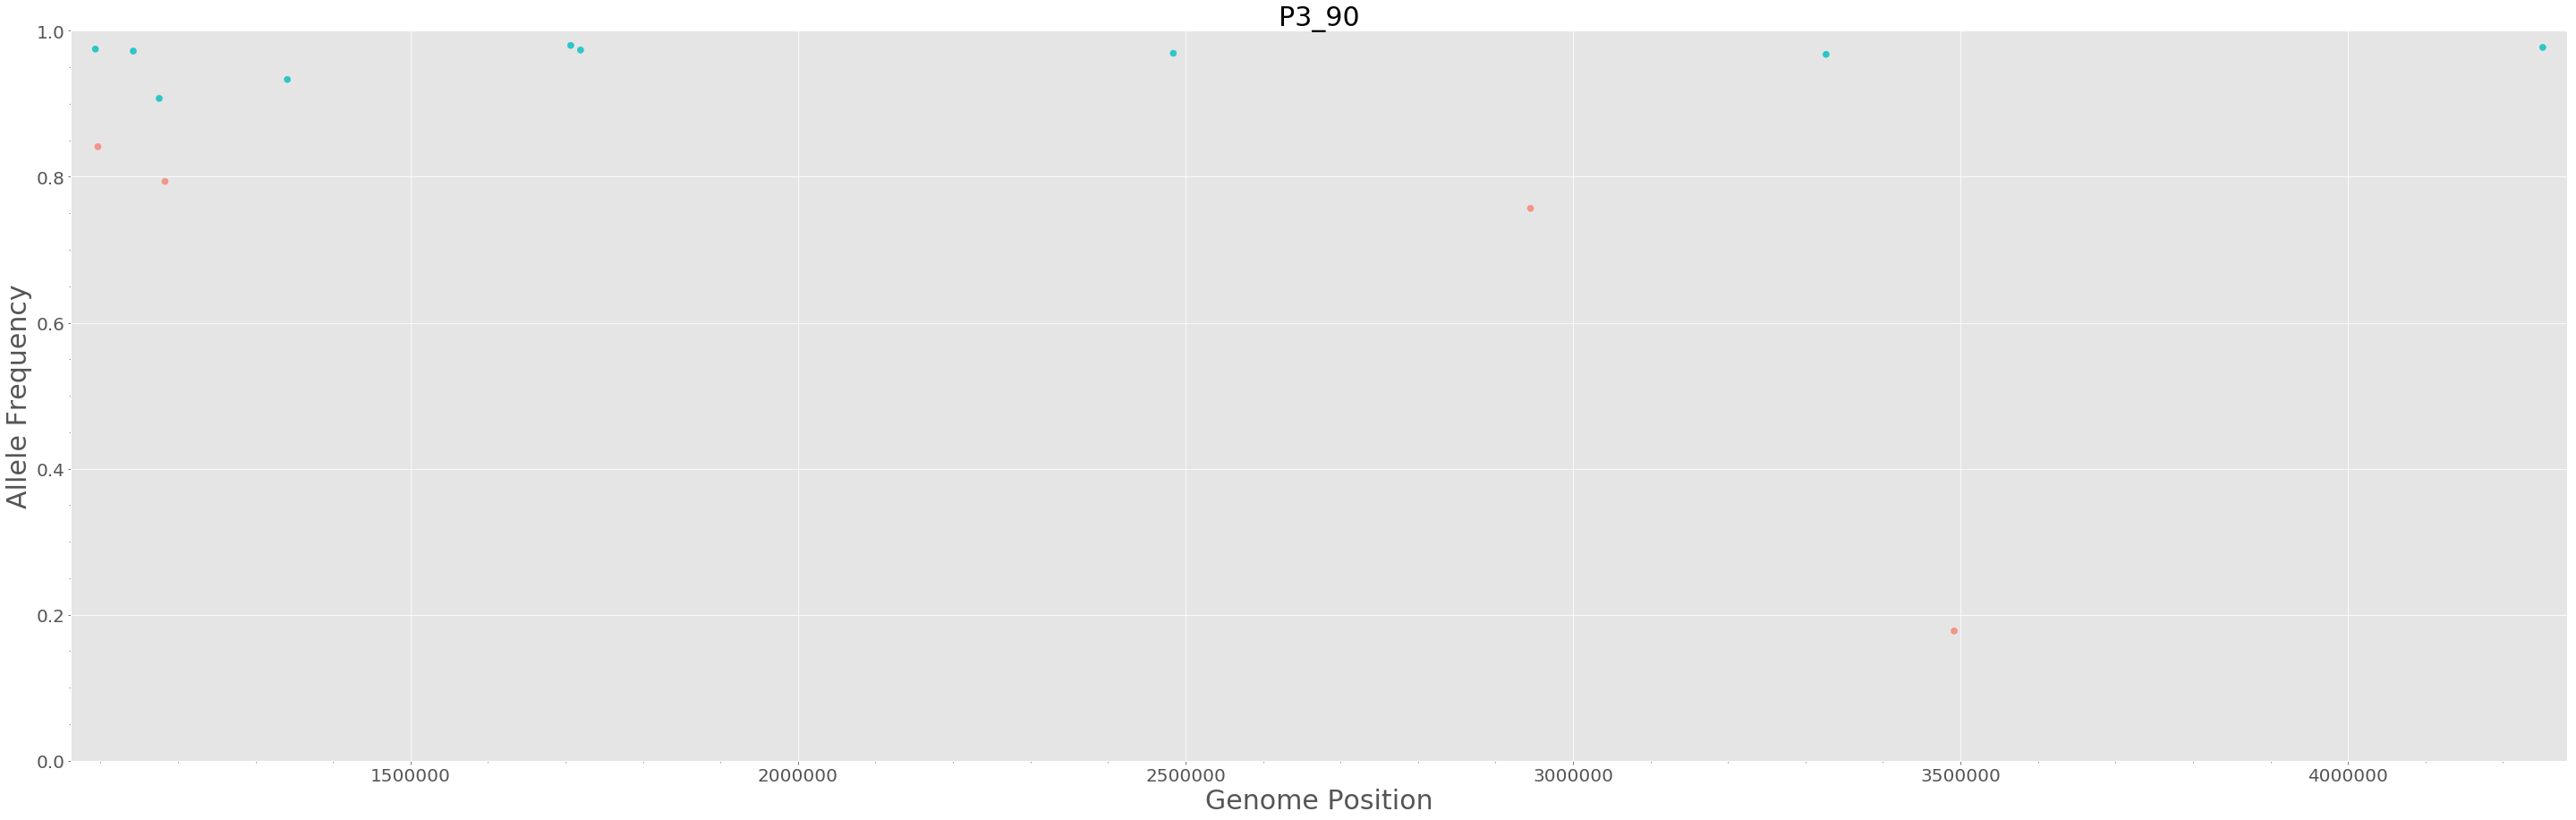

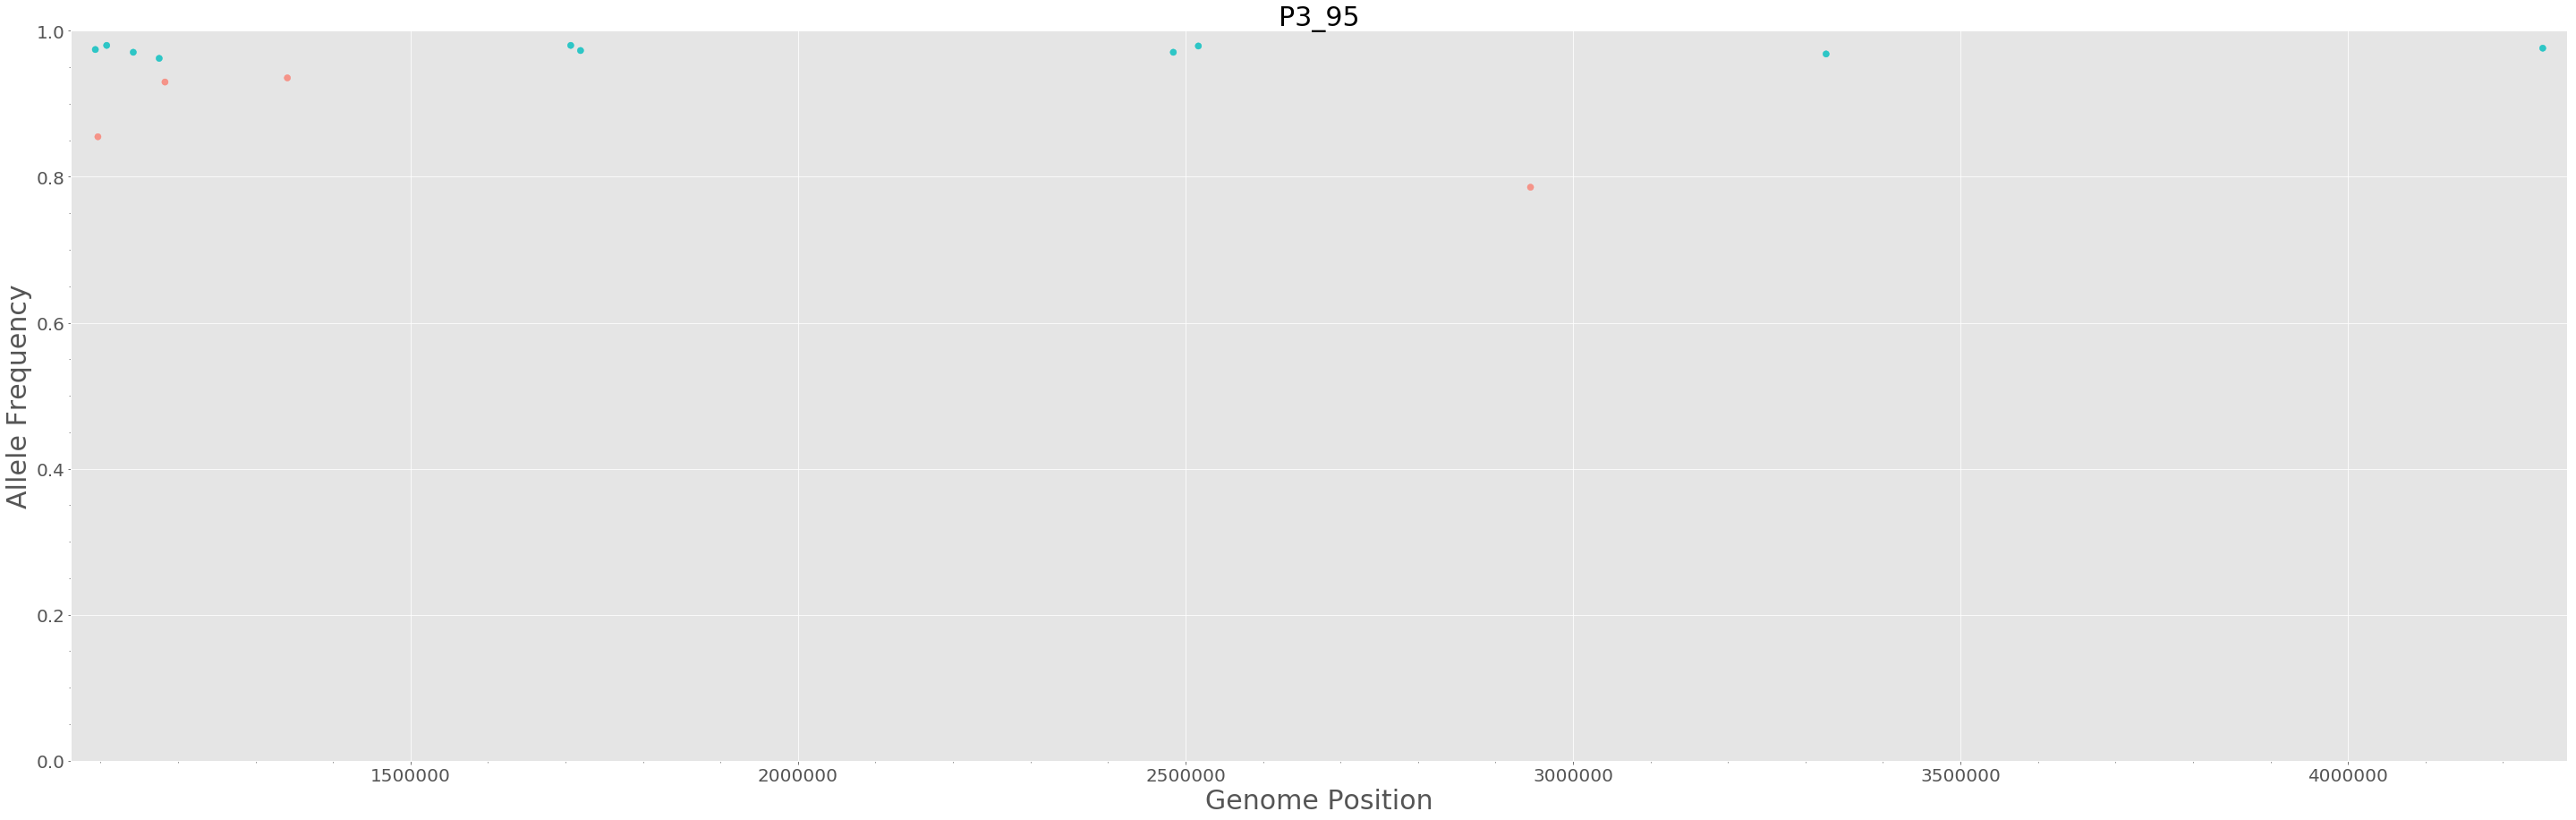

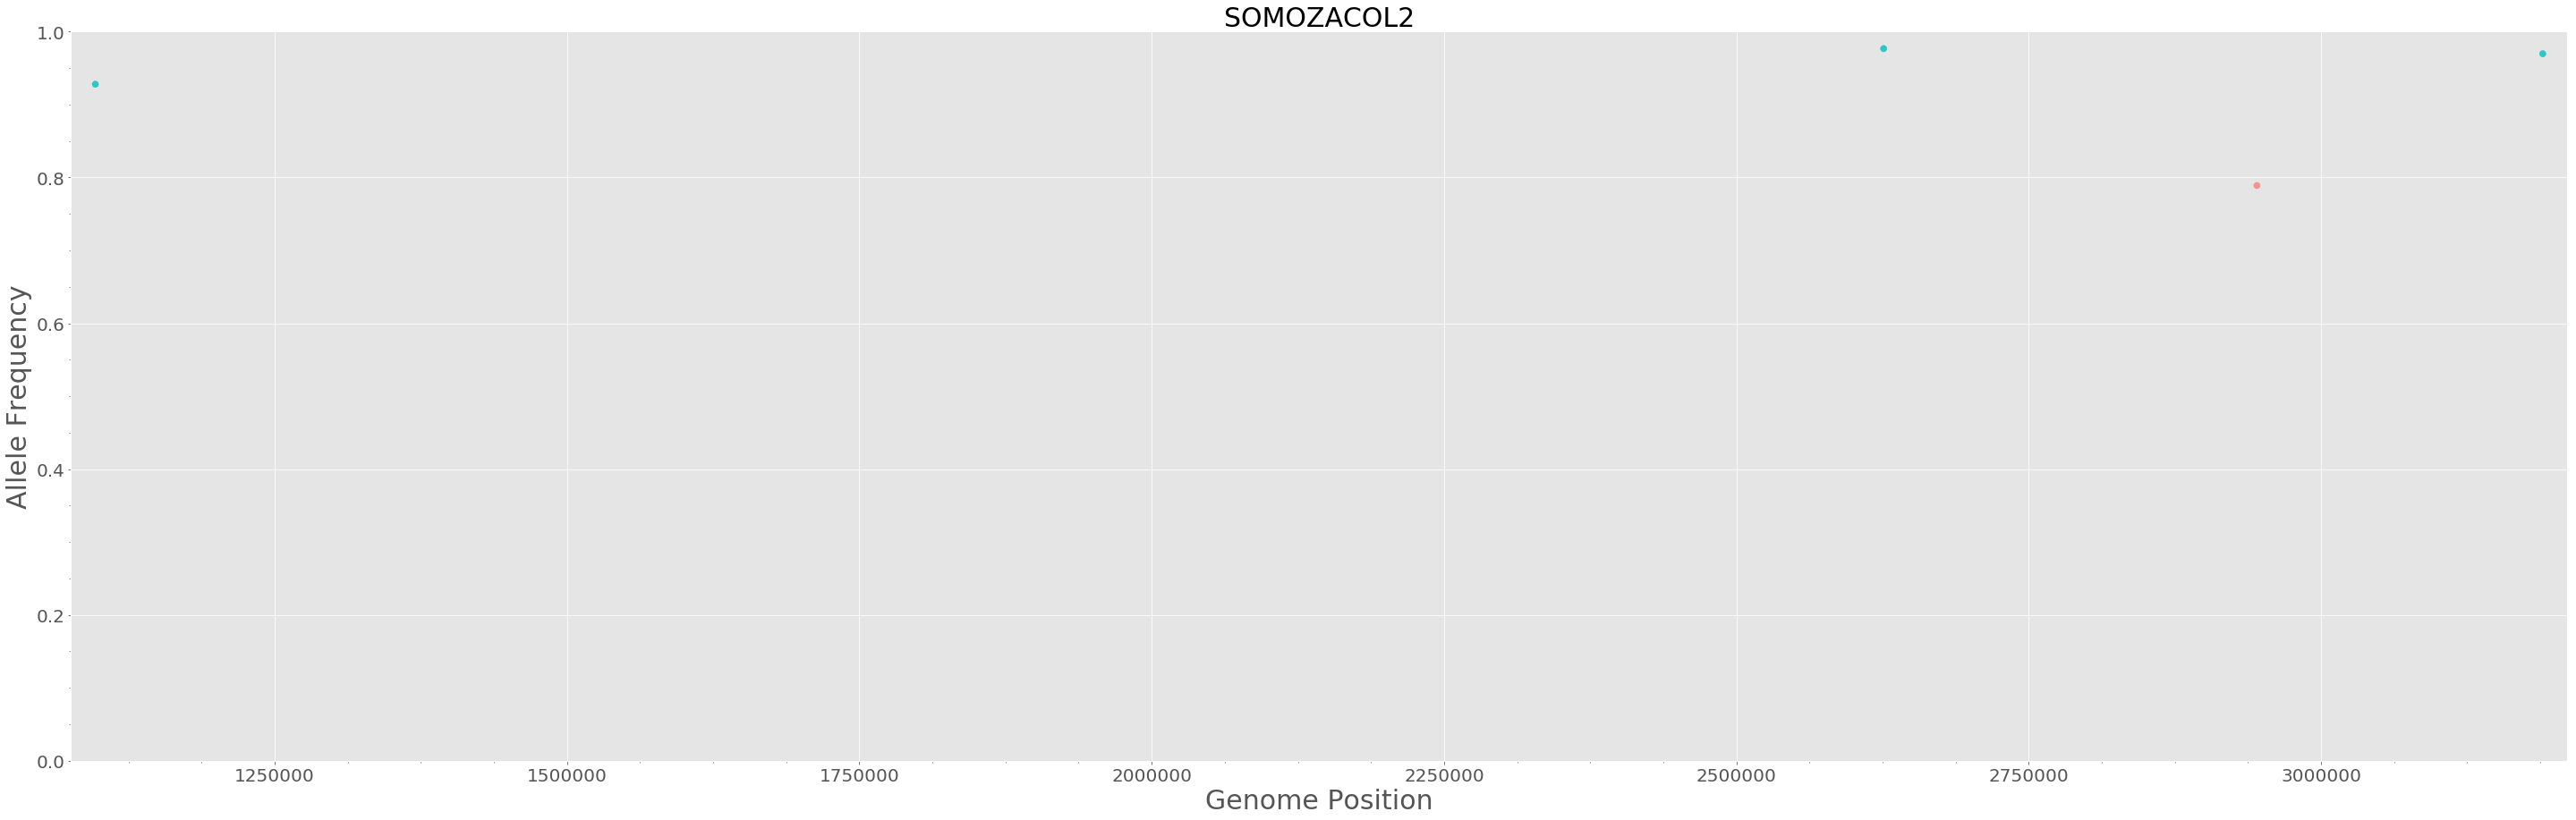

In [288]:
for name_dsf, df in dict_dff.items():
    scatter_vcf_pos(df,name_dsf, 0.98)

In [289]:
dict_dff['AL14621'][dict_dff['AL14621'].AF < 0.8]

#CHROM      POS ID REF ALT      QUAL FILTER  \
689  MTB_anc  2339719  .   G   A  15407.94   PASS   

                                                  INFO  \
689  AC=1;AF=0.500;AN=2;BaseQRankSum=0.00;DP=8;Exce...   

                        FORMAT                                         sample  \
689  GT:AD:DP:GQ:PGT:PID:PL:PS  0|1:2,6:8:66:1|0:2339709_C_A:226,0,66:2339709   

      AC   af   AN  BaseQRankSum   DP  ExcessHet   FS InbreedingCoeff    MQ  \
689  1.0  0.5  2.0           0.0  8.0     3.0103  0.0         -0.0286  60.0   

     MQRankSum     QD  ReadPosRankSum    SOR   GT   AD    GQ        PL  PGT  \
689        0.0  30.53          -0.619  0.824  0|1  2,6  66.0  226,0,66  1|0   

             PID       PS  len_AD  REF_AD  ALT_AD  gt0  gt1   dp    aF    AF  \
689  2339709_C_A  2339709       2     2.0     6.0    0    1  8.0  0.25  0.75   

     Is_repeat  snp_left_distance  snp_right_distance  Window_10  
689      False              464.0                 7.0          2

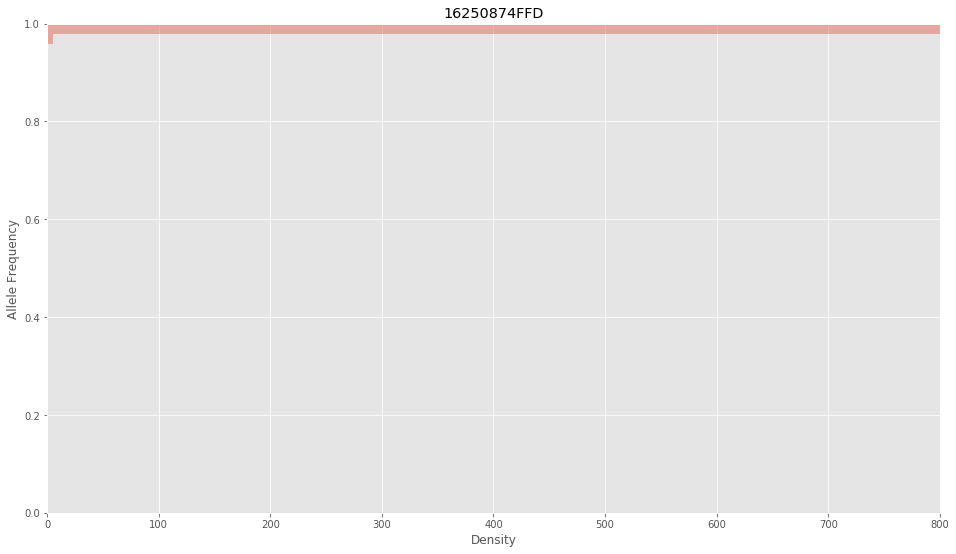

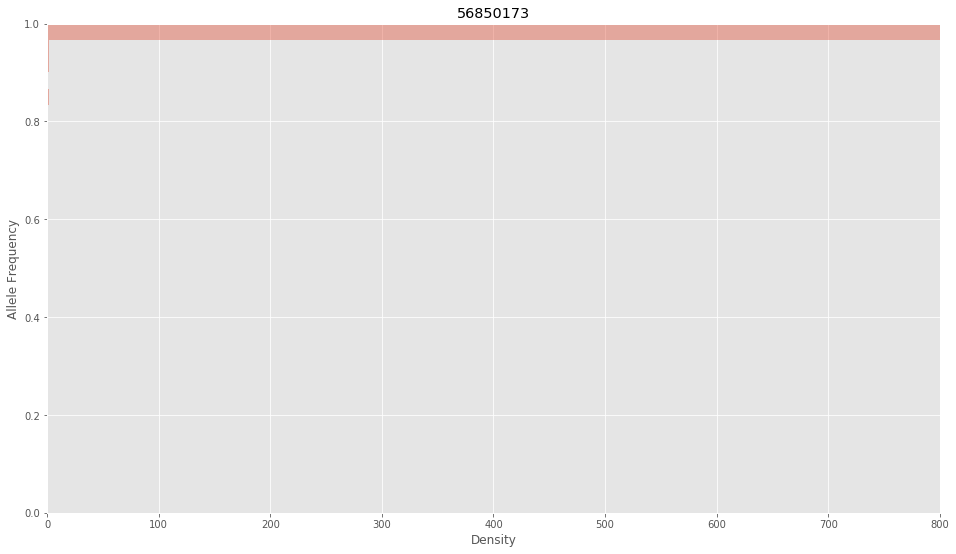

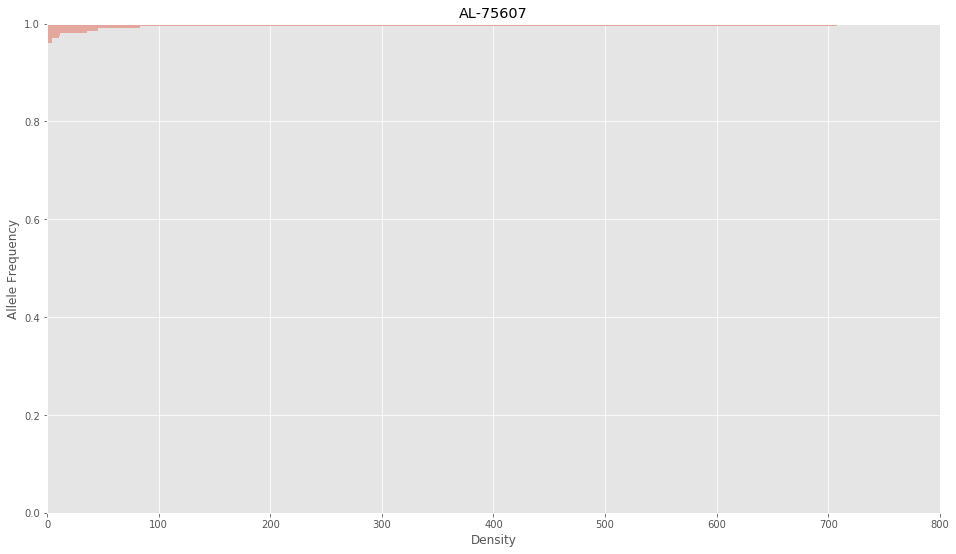

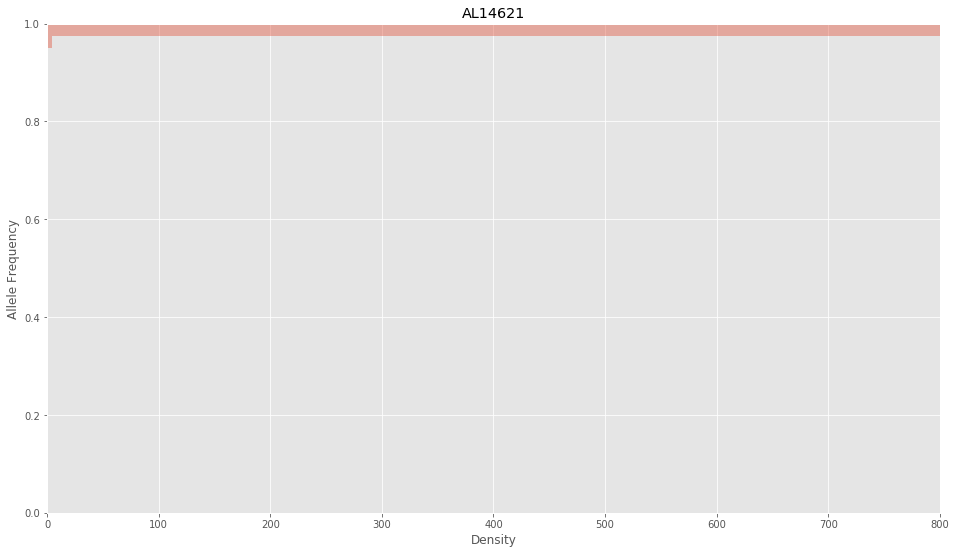

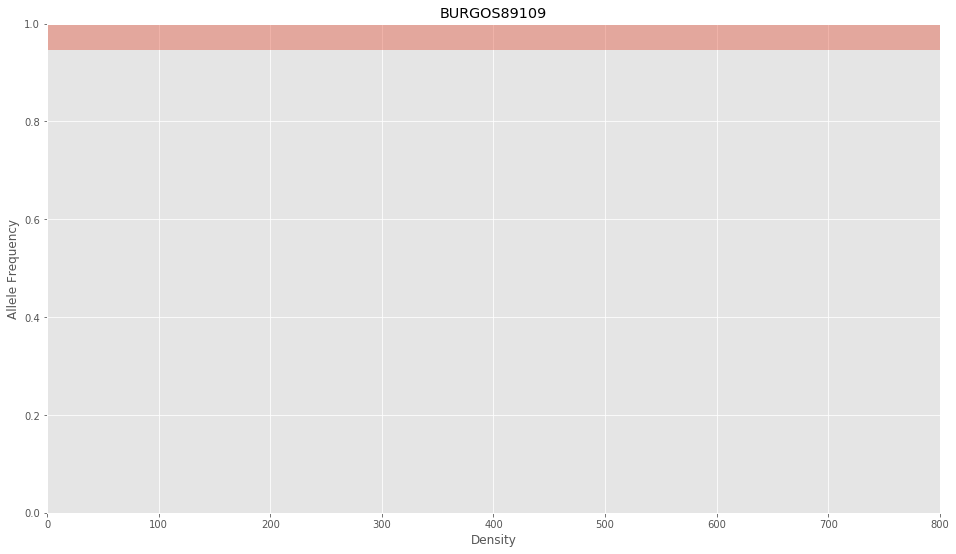

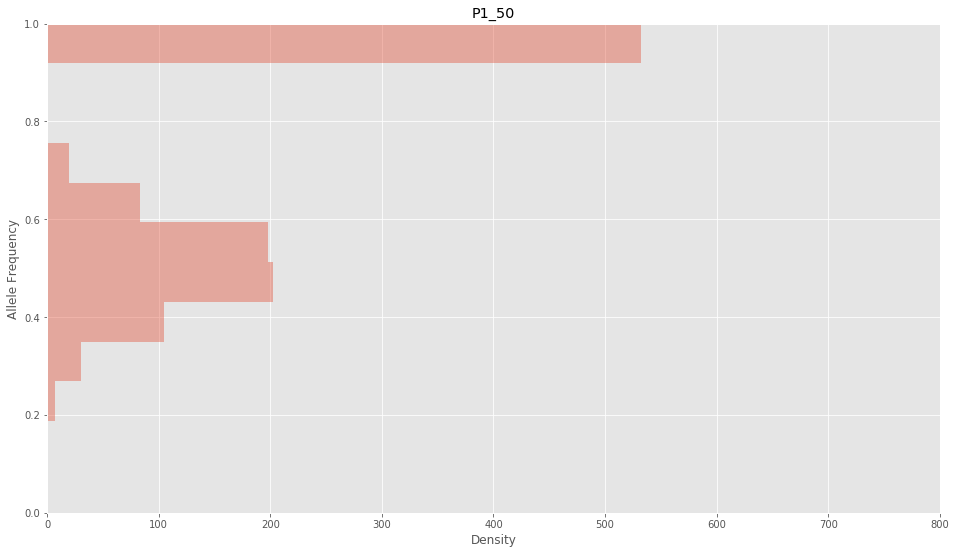

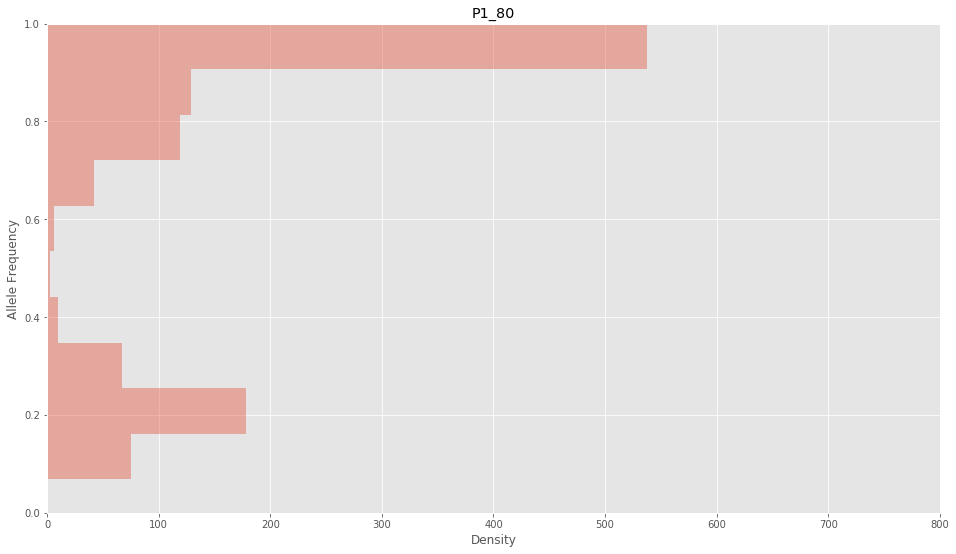

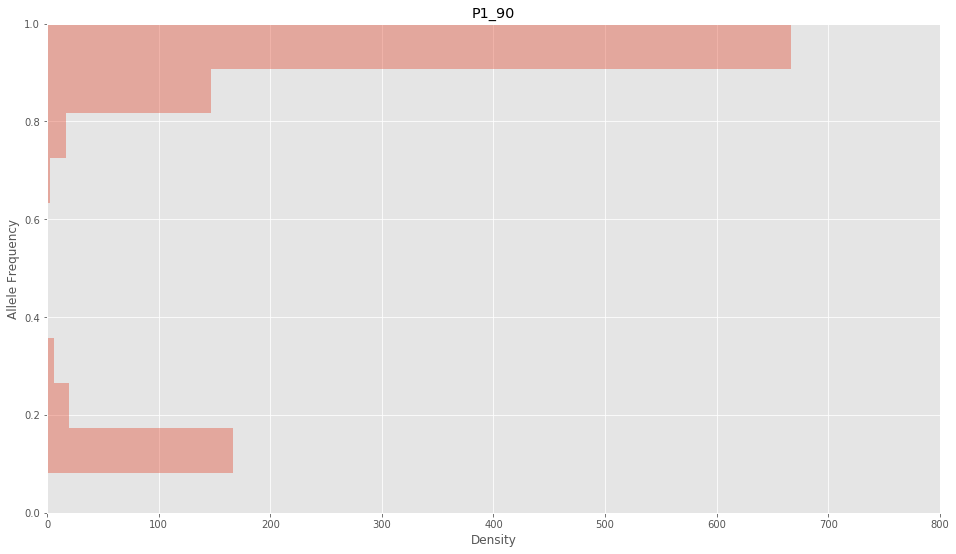

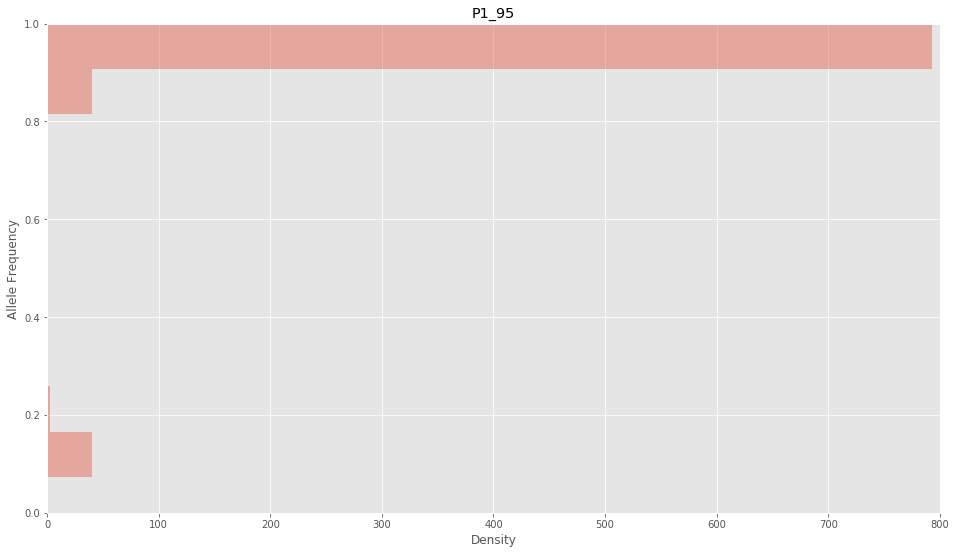

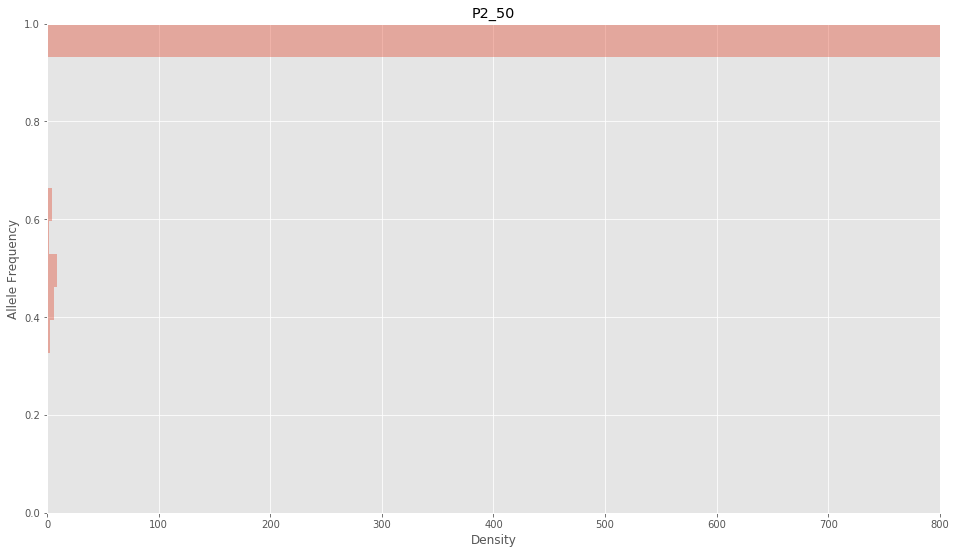

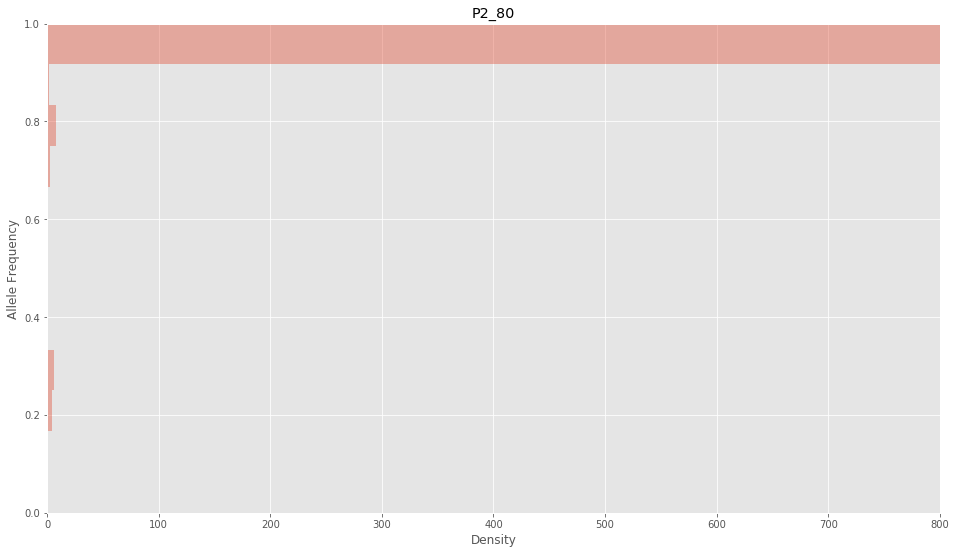

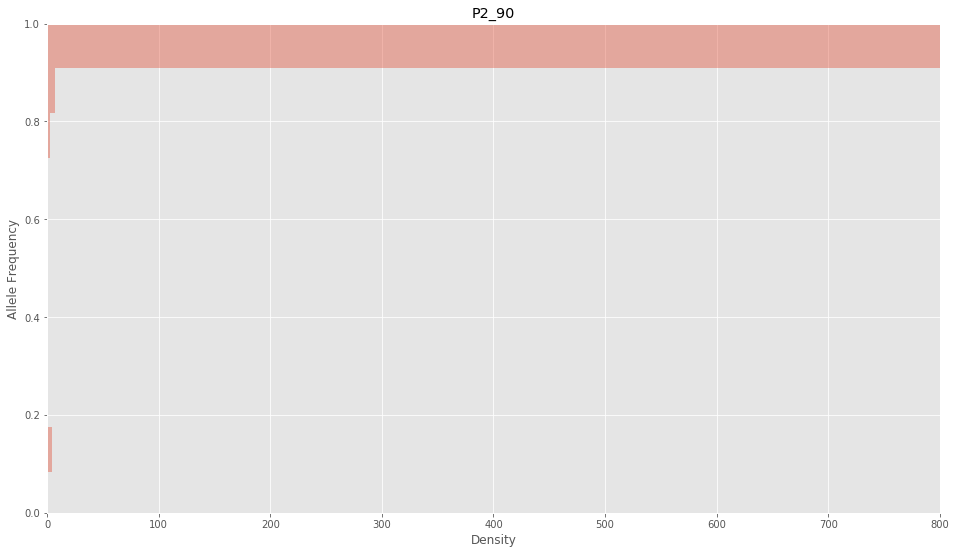

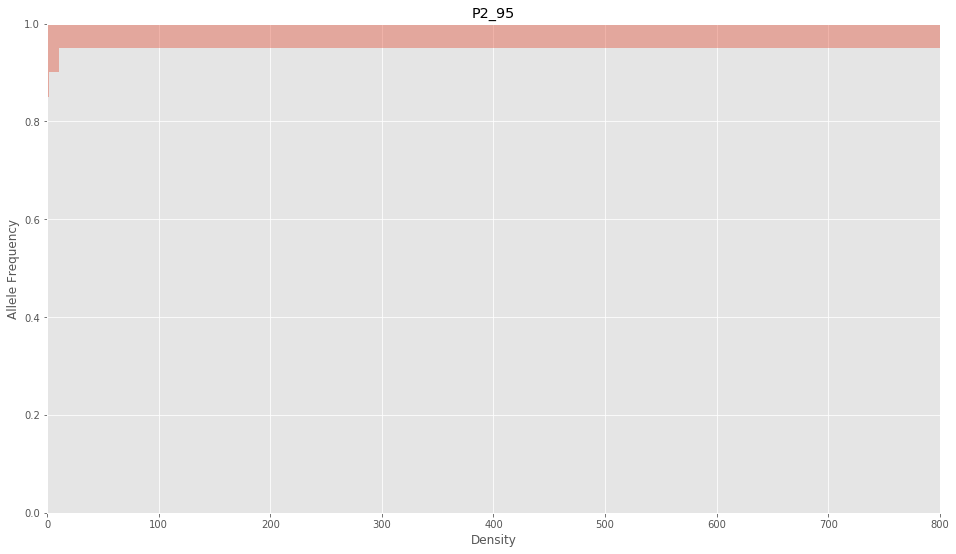

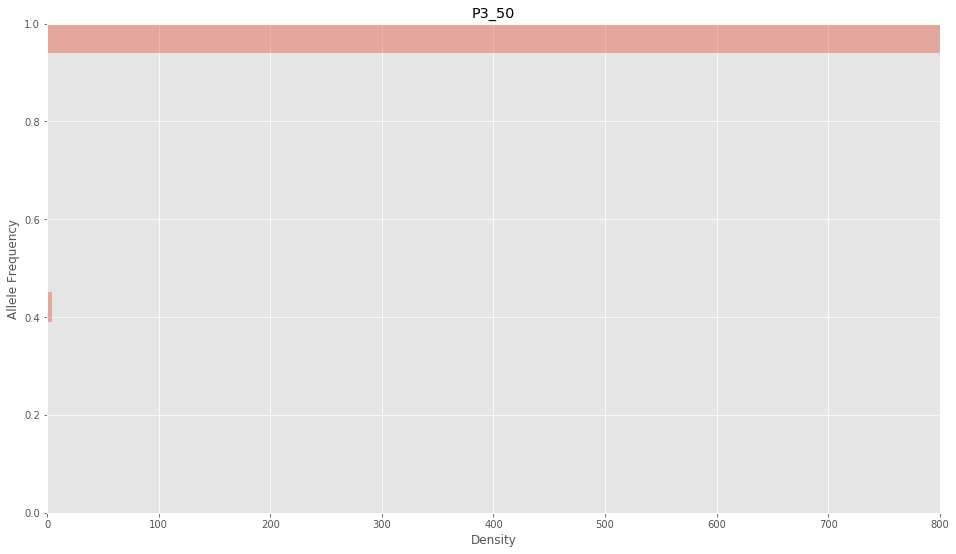

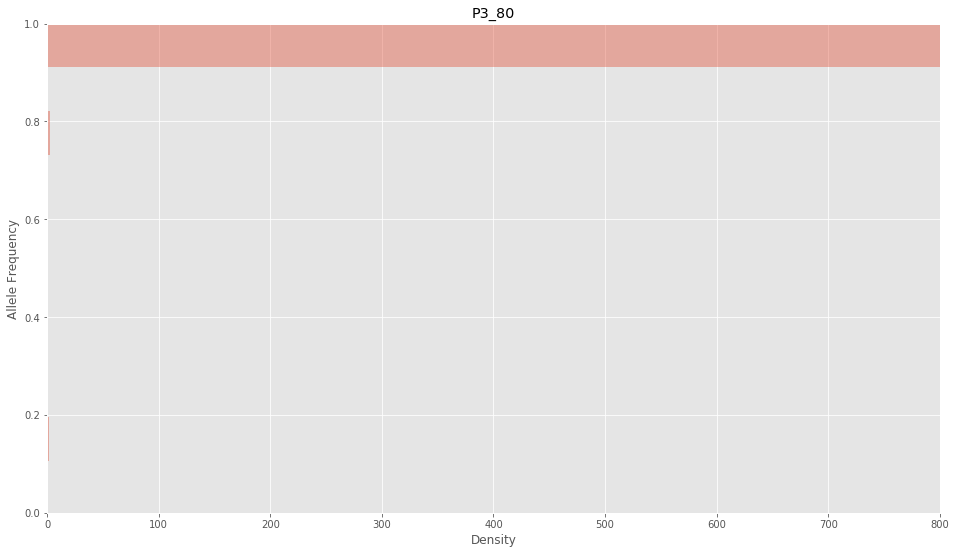

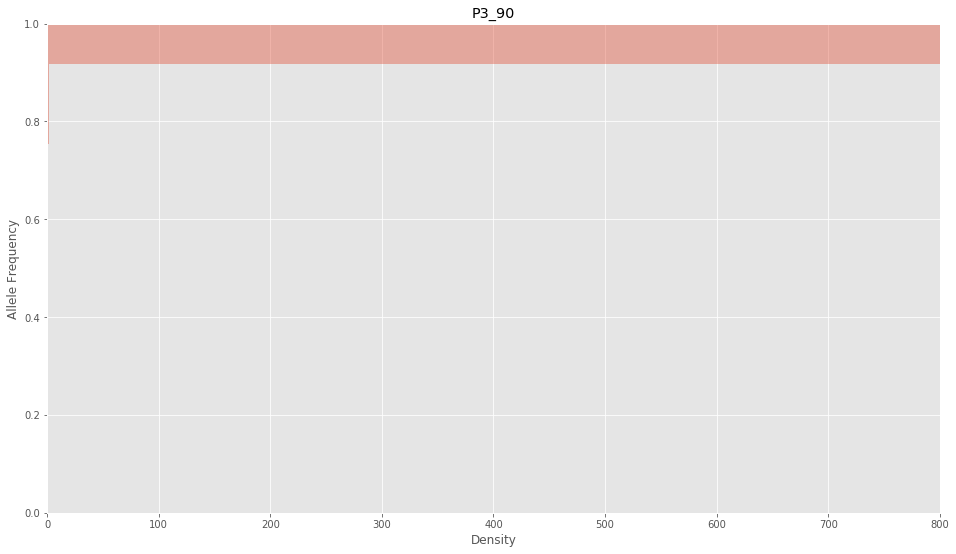

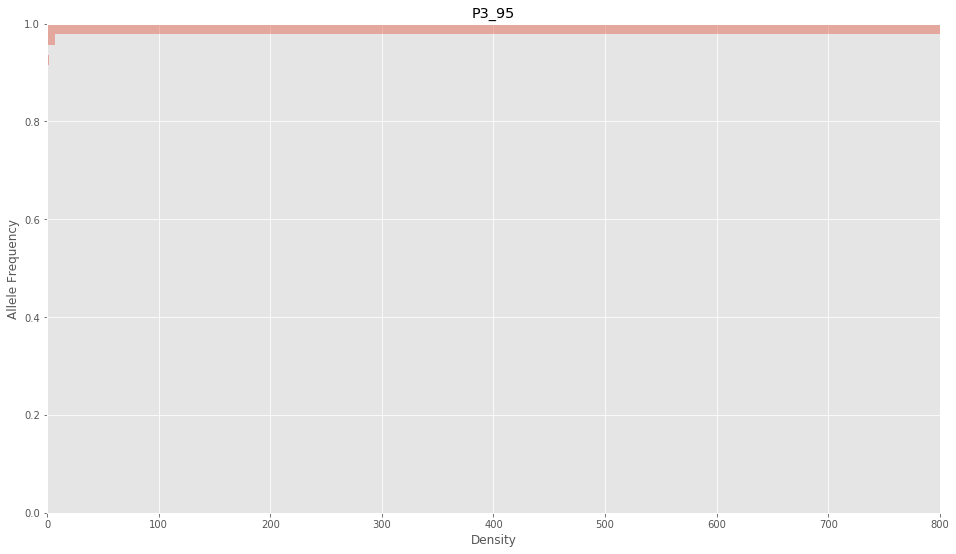

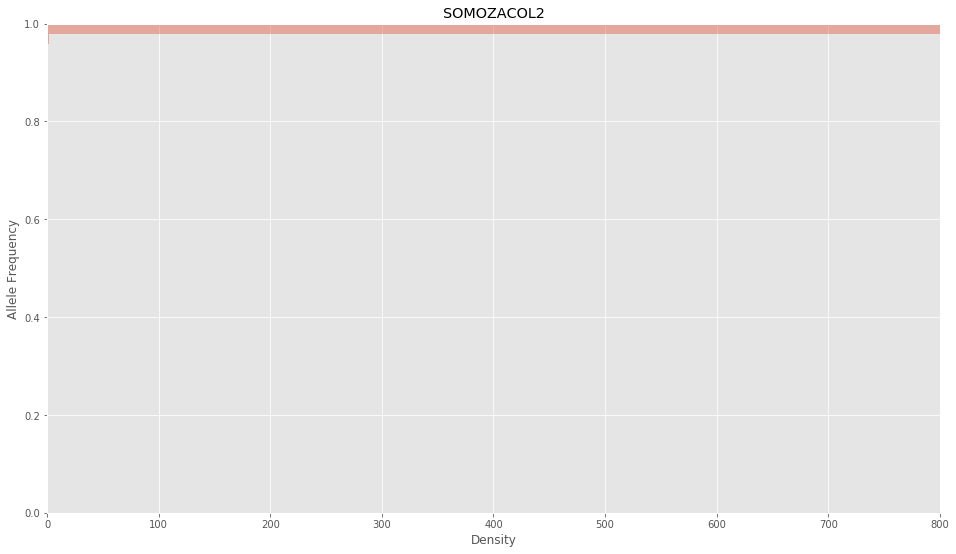

In [290]:
for name_dsf, df in dict_dff.items():
    distplot_sns(df,name_dsf)

In [291]:
def split_df_mean(vcf_df, homoz=0.95):
    filter_homoz_top = homoz
    filter_homoz_bottom = (1 - filter_homoz_top)
    
    mean = vcf_df['AF'][(vcf_df['AF'] <= filter_homoz_top) & (vcf_df['AF'] >= filter_homoz_bottom)].mean(axis = 0)    

    top_positions = vcf_df['POS'][(vcf_df['AF'] >= mean) & (vcf_df['AF'] <= filter_homoz_top)].tolist()
    bottom_positions = vcf_df['POS'][(vcf_df['AF'] <= mean) & (vcf_df['AF'] >= filter_homoz_bottom)].tolist()
    
    return top_positions, bottom_positions

In [292]:
dict_t_b = {}
for name_dff, df_dff in dict_dff.items():
    name_top = name_dff + "_t"
    name_btm = name_dff + "_b"
    name_top , name_btm = split_df_mean(df_dff)
    dict_t_b[name_dff] = name_top , name_btm

In [293]:
for k,v in dict_t_b.items():
    print(k, len(v), len(v[0]), len(v[1]))

16250874FFD 2 1 1
56850173 2 3 3
AL-75607 2 1 1
AL14621 2 1 1
BURGOS89109 2 1 1
P1_50 2 322 325
P1_80 2 301 332
P1_90 2 267 194
P1_95 2 142 43
P2_50 2 10 18
P2_80 2 19 10
P2_90 2 18 6
P2_95 2 12 2
P3_50 2 3 5
P3_80 2 5 4
P3_90 2 5 1
P3_95 2 2 2
SOMOZACOL2 2 1 1


# Create sets for comparing

In [294]:
B = set(dict_dff['BURGOS89109'].POS.values)
P = set(dict_dff['56850173'].POS.values)
A75 = set(dict_dff['AL-75607'].POS.values)
A14 = set(dict_dff['AL14621'].POS.values)
F = set(dict_dff['16250874FFD'].POS.values)
S = set(dict_dff['SOMOZACOL2'].POS.values)

In [295]:
B_exclusive = B - P
P_exclusive = P - B
Shared_B_P = P & B
total_difference_B_P = (len(B_exclusive) + len(P_exclusive))
print("B has %s unique positions\n\
P has %s unique positions\n\
Both share %s positions\n\
Total difference: %s" % (len(B_exclusive) , len(P_exclusive), len(Shared_B_P),total_difference_B_P ))

B has 301 unique positions
P has 345 unique positions
Both share 533 positions
Total difference: 646


In [296]:
A75_exclusive = A75 - A14
A14_exclusive = A14 - A75
Shared_A75_A14 = A14 & A75

print("A75 has %s unique positions\n\
A14 has %s unique positions\n\
Both share %s positions" % (len(A75_exclusive) , len(A14_exclusive), len(Shared_A75_A14)))

A75 has 16 unique positions
A14 has 10 unique positions
Both share 889 positions


In [297]:
F_exclusive = F - S
S_exclusive = S - F
Shared_F_S = S & F

print("F has %s unique Positions\n\
S has %s unique Sositions\n\
Both share %s Positions" % (len(F_exclusive) , len(S_exclusive), len(Shared_F_S)))

F has 2 unique Positions
S has 4 unique Sositions
Both share 870 Positions


# Use venn diagram to check disgregation

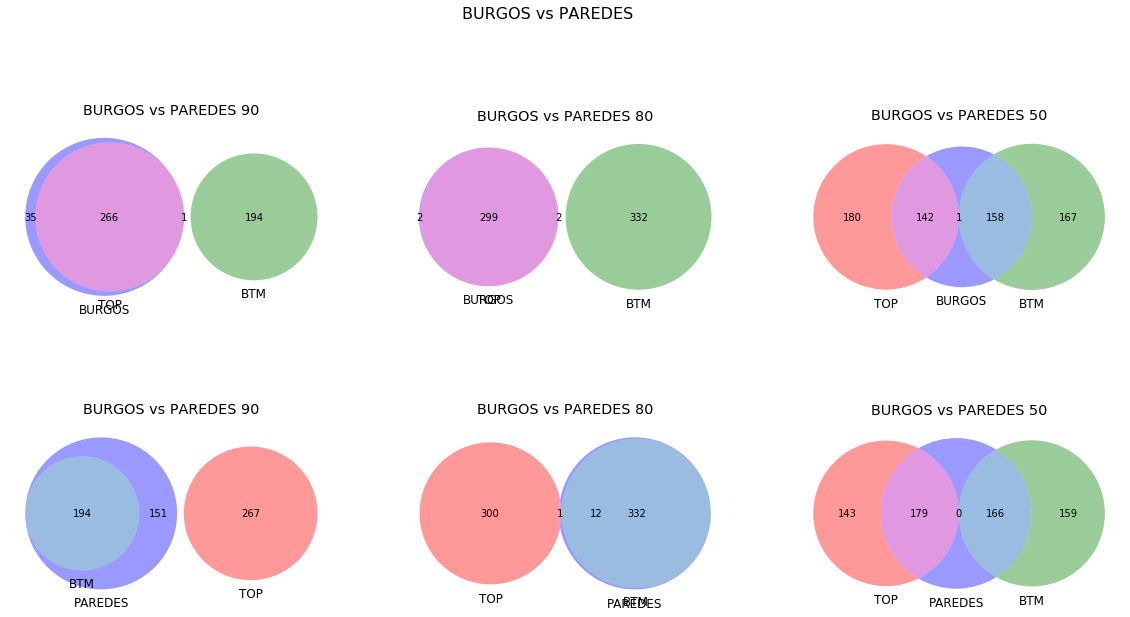

In [298]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
plt.title("BURGOS vs PAREDES 90")
v3 = venn3([set(dict_t_b['P1_90'][0]), set(dict_t_b['P1_90'][1]), B_exclusive], 
            set_labels = ('TOP', 'BTM', 'BURGOS'))

plt.subplot(2, 3, 2)
plt.title("BURGOS vs PAREDES 80")
v3 = venn3([set(dict_t_b['P1_80'][0]), set(dict_t_b['P1_80'][1]), B_exclusive], 
            set_labels = ('TOP', 'BTM', 'BURGOS'))

plt.subplot(2, 3, 3)
plt.title("BURGOS vs PAREDES 50")
v3 = venn3([set(dict_t_b['P1_50'][0]), set(dict_t_b['P1_50'][1]), B_exclusive], 
            set_labels = ('TOP', 'BTM', 'BURGOS'))

plt.suptitle('BURGOS vs PAREDES', fontsize=16, verticalalignment='bottom')


plt.subplot(2, 3, 4)
plt.title("BURGOS vs PAREDES 90")
v3 = venn3([set(dict_t_b['P1_90'][0]), set(dict_t_b['P1_90'][1]), P_exclusive], 
            set_labels = ('TOP', 'BTM', 'PAREDES'))

plt.subplot(2, 3, 5)
plt.title("BURGOS vs PAREDES 80")
v3 = venn3([set(dict_t_b['P1_80'][0]), set(dict_t_b['P1_80'][1]), P_exclusive], 
            set_labels = ('TOP', 'BTM', 'PAREDES'))

plt.subplot(2, 3, 6)
plt.title("BURGOS vs PAREDES 50")
v3 = venn3([set(dict_t_b['P1_50'][0]), set(dict_t_b['P1_50'][1]), P_exclusive], 
            set_labels = ('TOP', 'BTM', 'PAREDES'))

#plt.savefig(os.path.join('img', 'SOMOZA_ALL.svg'), format="svg")

plt.show()

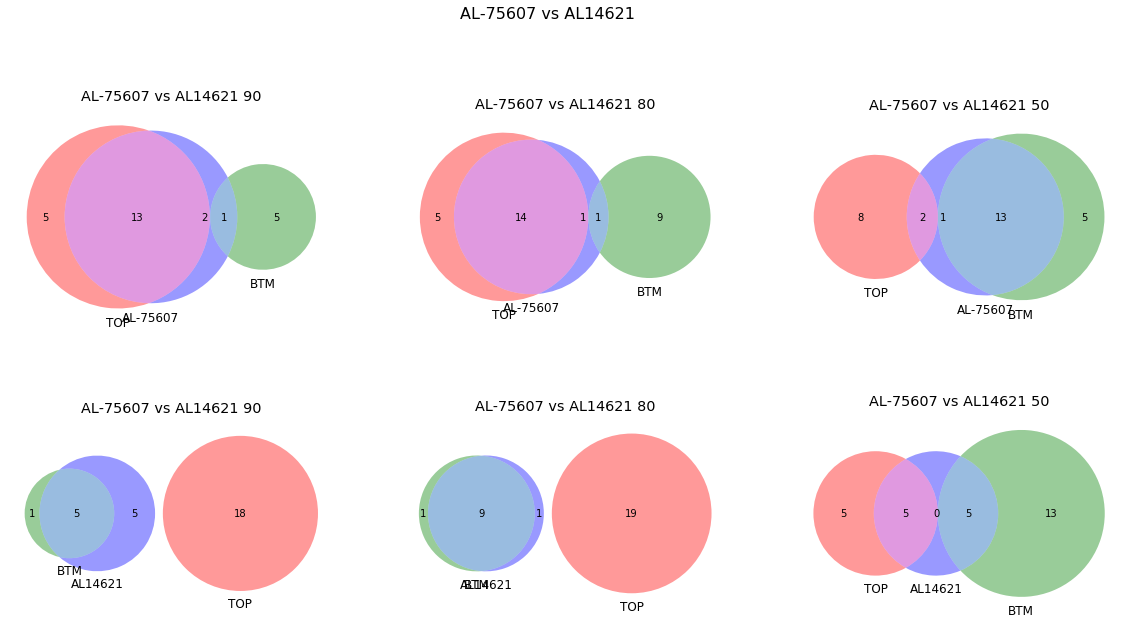

In [299]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
plt.title("AL-75607 vs AL14621 90")
v3 = venn3([set(dict_t_b['P2_90'][0]), set(dict_t_b['P2_90'][1]), A75_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL-75607'))

plt.subplot(2, 3, 2)
plt.title("AL-75607 vs AL14621 80")
v3 = venn3([set(dict_t_b['P2_80'][0]), set(dict_t_b['P2_80'][1]), A75_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL-75607'))

plt.subplot(2, 3, 3)
plt.title("AL-75607 vs AL14621 50")
v3 = venn3([set(dict_t_b['P2_50'][0]), set(dict_t_b['P2_50'][1]), A75_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL-75607'))

plt.suptitle('AL-75607 vs AL14621', fontsize=16, verticalalignment='bottom')


plt.subplot(2, 3, 4)
plt.title("AL-75607 vs AL14621 90")
v3 = venn3([set(dict_t_b['P2_90'][0]), set(dict_t_b['P2_90'][1]), A14_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL14621'))

plt.subplot(2, 3, 5)
plt.title("AL-75607 vs AL14621 80")
v3 = venn3([set(dict_t_b['P2_80'][0]), set(dict_t_b['P2_80'][1]), A14_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL14621'))

plt.subplot(2, 3, 6)
plt.title("AL-75607 vs AL14621 50")
v3 = venn3([set(dict_t_b['P2_50'][0]), set(dict_t_b['P2_50'][1]), A14_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL14621'))

#plt.savefig(os.path.join('img', 'SOMOZA_ALL.svg'), format="svg")

plt.show()

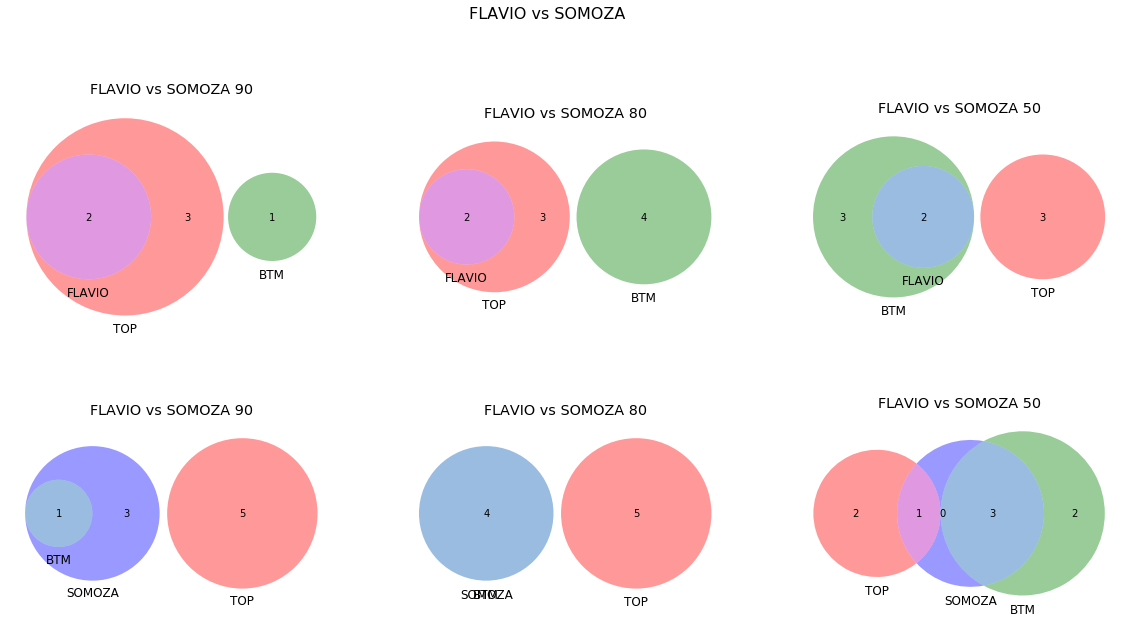

In [300]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
plt.title("FLAVIO vs SOMOZA 90")
v3 = venn3([set(dict_t_b['P3_90'][0]), set(dict_t_b['P3_90'][1]), F_exclusive], 
            set_labels = ('TOP', 'BTM', 'FLAVIO'))

plt.subplot(2, 3, 2)
plt.title("FLAVIO vs SOMOZA 80")
v3 = venn3([set(dict_t_b['P3_80'][0]), set(dict_t_b['P3_80'][1]), F_exclusive], 
            set_labels = ('TOP', 'BTM', 'FLAVIO'))

plt.subplot(2, 3, 3)
plt.title("FLAVIO vs SOMOZA 50")
v3 = venn3([set(dict_t_b['P3_50'][0]), set(dict_t_b['P3_50'][1]), F_exclusive], 
            set_labels = ('TOP', 'BTM', 'FLAVIO'))

plt.suptitle('FLAVIO vs SOMOZA', fontsize=16, verticalalignment='bottom')


plt.subplot(2, 3, 4)
plt.title("FLAVIO vs SOMOZA 90")
v3 = venn3([set(dict_t_b['P3_90'][0]), set(dict_t_b['P3_90'][1]), S_exclusive], 
            set_labels = ('TOP', 'BTM', 'SOMOZA'))

plt.subplot(2, 3, 5)
plt.title("FLAVIO vs SOMOZA 80")
v3 = venn3([set(dict_t_b['P3_80'][0]), set(dict_t_b['P3_80'][1]), S_exclusive], 
            set_labels = ('TOP', 'BTM', 'SOMOZA'))

plt.subplot(2, 3, 6)
plt.title("FLAVIO vs SOMOZA 50")
v3 = venn3([set(dict_t_b['P3_50'][0]), set(dict_t_b['P3_50'][1]), S_exclusive], 
            set_labels = ('TOP', 'BTM', 'SOMOZA'))

#plt.savefig(os.path.join('img', 'SOMOZA_ALL.svg'), format="svg")

plt.show()

# Start K-means clustering

### Thanks to: http://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/

In [301]:
dict_dff['P1_50'].describe()

POS          QUAL           AC           af      AN  \
count  1.179000e+03   1179.000000  1179.000000  1179.000000  1179.0   
mean   2.173089e+06  30353.597405     1.451230     0.725615     2.0   
std    1.325588e+06  16140.032802     0.497827     0.248913     0.0   
min    1.977000e+03   2602.880000     1.000000     0.500000     2.0   
25%    1.051145e+06  17968.610000     1.000000     0.500000     2.0   
50%    2.140753e+06  26523.510000     1.000000     0.500000     2.0   
75%    3.295218e+06  43515.270000     2.000000     1.000000     2.0   
max    4.408923e+06  87850.270000     2.000000     1.000000     2.0   

       BaseQRankSum           DP    ExcessHet           FS           MQ  \
count    785.000000  1179.000000  1179.000000  1179.000000  1179.000000   
mean       0.190948    63.531807     1.417363     1.998997    59.839152   
std        1.855847    17.432274     1.495430     4.060021     1.255724   
min       -4.556000     6.000000     0.000300     0.000000    43.050000   
25%       -1.340000    52.000000     0.011100     0.000000    60.000000   
50%        0.287000    62.000000     0.195400     0.000000    60.000000   
75%        1.710000    76.000000     3.010300     2.274000    60.000000   
max        6.150000   130.000000    10.548300    33.993000    60.000000   

        MQRankSum           QD  ReadPosRankSum          SOR           GQ  \
count  785.000000  1179.000000      784.000000  1179.000000  1179.000000   
mean    -0.007205    29.936667        0.191953     0.751634    98.504665   
std      0.695876     3.307449        1.005886     0.346808     4.432930   
min     -7.441000    16.820000       -2.697000     0.013000    18.000000   
25%      0.000000    27.575000       -0.555000     0.536000    99.000000   
50%      0.000000    30.260000        0.141500     0.740000    99.000000   
75%      0.000000    32.760000        0.933000     0.921000    99.000000   
max      7.750000    37.710000        2.660000     2.833000    99.000000   

       len_AD       REF_AD       ALT_AD          gt0     gt1           dp  \
count  1179.0  1179.000000  1179.000000  1179.000000  1179.0  1179.000000   
mean      2.0    17.391009    46.135708     0.451230     1.0    63.526718   
std       0.0    17.548592    21.152857     0.497827     0.0    17.433256   
min       2.0     0.000000     3.000000     0.000000     1.0     6.000000   
25%       2.0     0.000000    29.000000     0.000000     1.0    52.000000   
50%       2.0    18.000000    42.000000     0.000000     1.0    62.000000   
75%       2.0    32.000000    61.000000     1.000000     1.0    76.000000   
max       2.0    66.000000   130.000000     1.000000     1.0   130.000000   

                aF           AF  snp_left_distance  snp_right_distance  \
count  1179.000000  1179.000000        1179.000000         1179.000000   
mean      0.273767     0.726233        3359.735369         3314.277354   
std       0.258014     0.258014        3578.395386         3432.923815   
min       0.000000     0.187500           1.000000            1.000000   
25%       0.000000     0.490381         868.500000          868.500000   
50%       0.375000     0.625000        2140.000000         2163.000000   
75%       0.509619     1.000000        4694.000000         4694.000000   
max       0.812500     1.000000       31347.000000        21698.000000   

         Window_10  
count  1179.000000  
mean      1.033079  
std       0.178918  
min       1.000000  
25%       1.000000  
50%       1.000000  
75%       1.000000  
max       2.000000

/home/laura/env36/lib/python3.6/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


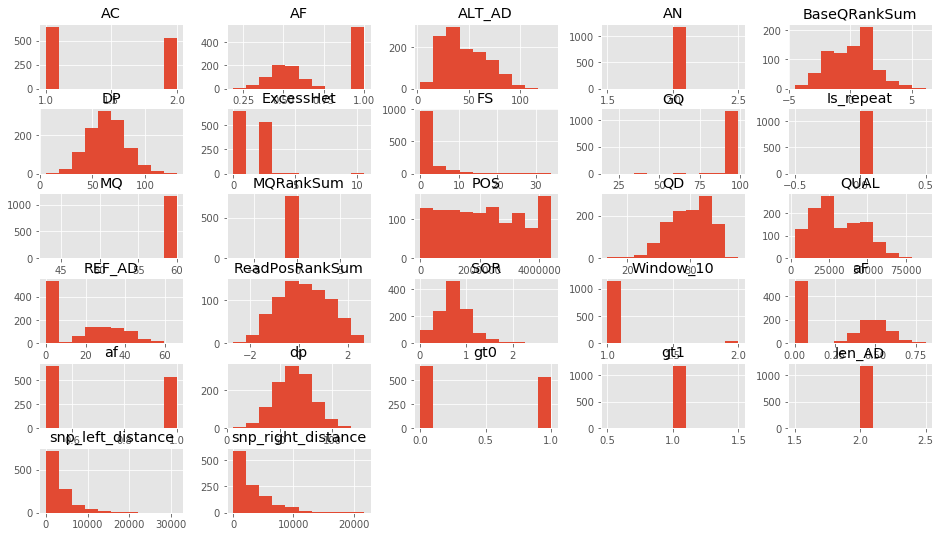

In [302]:
dict_dff['P1_50'].hist()
plt.show()

In [303]:
def assign_group_P1(row):
    if row.POS in B_exclusive:
        return 1
    elif row.POS in P_exclusive:
        return 2
    else:
        return 3


In [354]:
Ktest5 = dict_dff['P1_50']
Ktest8 = dict_dff['P1_80']
Ktest9 = dict_dff['P1_90']
Ktest95 = dict_dff['P1_95']

In [357]:
Ktest5['category'] = Ktest5.apply(assign_group_P1, axis=1)
Ktest8['category'] = Ktest8.apply(assign_group_P1, axis=1)
Ktest9['category'] = Ktest9.apply(assign_group_P1, axis=1)
Ktest95['category'] = Ktest95.apply(assign_group_P1, axis=1)

/home/laura/env36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/laura/env36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/laura/env36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [361]:
Ktest8[(Ktest8.gt0 == 0) & (Ktest8.category == 3)]

#CHROM      POS ID REF ALT     QUAL FILTER  \
1099  MTB_anc  3122096  .   C   T  3145.82   PASS   

                                                   INFO          FORMAT  \
1099  AC=1;AF=0.500;AN=2;BaseQRankSum=-2.082e+00;DP=...  GT:AD:DP:GQ:PL   

                         sample   AC   af   AN  BaseQRankSum    DP  ExcessHet  \
1099  0/1:10,13:23:99:496,0,341  1.0  0.5  2.0        -2.082  23.0     0.1954   

          FS InbreedingCoeff     MQ  MQRankSum     QD  ReadPosRankSum    SOR  \
1099  14.793          0.4680  56.92      0.228  34.57            1.61  2.259   

       GT     AD    GQ         PL  PGT  PID   PS  len_AD  REF_AD  ALT_AD  gt0  \
1099  0/1  10,13  99.0  496,0,341  NaN  NaN  NaN       2    10.0    13.0    0   

      gt1    dp        aF        AF  Is_repeat  snp_left_distance  \
1099    1  23.0  0.434783  0.565217      False               31.0   

      snp_right_distance  Window_10  category  Label  
1099               847.0          1         3      0

In [364]:
Ktest8.gt0[Ktest8.category == 3].value_counts()

1    533
0      1
Name: gt0, dtype: int64

In [365]:
Ktest5.gt0[Ktest5.category == 3].value_counts()

1    532
0      2
Name: gt0, dtype: int64

In [366]:
Ktest9.gt0[Ktest9.category == 3].value_counts()

1    533
0      1
Name: gt0, dtype: int64

In [367]:
Ktest95.gt0[Ktest95.category == 3].value_counts()

1    534
Name: gt0, dtype: int64

In [369]:
Ktest95.shape

(877, 43)

In [372]:
Ktest8.shape

(1167, 44)

In [308]:
Ktest8.gt0[Ktest8.category == 2].value_counts()

0    333
Name: gt0, dtype: int64

In [309]:
Ktest8.gt0[Ktest8.category == 1].value_counts()

0    298
1      2
Name: gt0, dtype: int64

In [310]:
Ktest8[(Ktest8.category == 3) & (Ktest8.GT == "0/1")]

#CHROM      POS ID REF ALT     QUAL FILTER  \
1099  MTB_anc  3122096  .   C   T  3145.82   PASS   

                                                   INFO          FORMAT  \
1099  AC=1;AF=0.500;AN=2;BaseQRankSum=-2.082e+00;DP=...  GT:AD:DP:GQ:PL   

                         sample   AC   af   AN  BaseQRankSum    DP  ExcessHet  \
1099  0/1:10,13:23:99:496,0,341  1.0  0.5  2.0        -2.082  23.0     0.1954   

          FS InbreedingCoeff     MQ  MQRankSum     QD  ReadPosRankSum    SOR  \
1099  14.793          0.4680  56.92      0.228  34.57            1.61  2.259   

       GT     AD    GQ         PL  PGT  PID   PS  len_AD  REF_AD  ALT_AD  gt0  \
1099  0/1  10,13  99.0  496,0,341  NaN  NaN  NaN       2    10.0    13.0    0   

      gt1    dp        aF        AF  Is_repeat  snp_left_distance  \
1099    1  23.0  0.434783  0.565217      False               31.0   

      snp_right_distance  Window_10  category  
1099               847.0          1         3

In [311]:
Ktest8.head()

#CHROM   POS ID REF ALT      QUAL FILTER  \
0  MTB_anc  1977  .   G   A  19963.51   PASS   
1  MTB_anc  2532  .   C   T  16595.27   PASS   
2  MTB_anc  6140  .   G   T  22403.11   PASS   
3  MTB_anc  7585  .   C   G  31938.04   PASS   
4  MTB_anc  9143  .   C   T  56818.27   PASS   

                                                INFO          FORMAT  \
0  AC=1;AF=0.500;AN=2;BaseQRankSum=0.720;DP=42;Ex...  GT:AD:DP:GQ:PL   
1  AC=2;AF=1.00;AN=2;DP=13;ExcessHet=3.0103;FS=0....  GT:AD:DP:GQ:PL   
2  AC=1;AF=0.500;AN=2;BaseQRankSum=1.43;DP=52;Exc...  GT:AD:DP:GQ:PL   
3  AC=1;AF=0.500;AN=2;BaseQRankSum=1.27;DP=72;Exc...  GT:AD:DP:GQ:PL   
4  AC=2;AF=1.00;AN=2;DP=73;ExcessHet=3.0103;FS=0....  GT:AD:DP:GQ:PL   

                       sample   AC   af   AN  BaseQRankSum    DP  ExcessHet  \
0  0/1:10,32:42:99:1042,0,200  1.0  0.5  2.0          0.72  42.0     0.0442   
1     1/1:0,13:13:39:394,39,0  2.0  1.0  2.0           NaN  13.0     3.0103   
2   0/1:43,9:52:99:213,0,1214  1.0  0.5  2.0          1.43  52.0     0.0069   
3  0/1:22,50:72:99:1565,0,484  1.0  0.5  2.0          1.27  72.0     0.0111   
4   1/1:0,73:73:99:2536,218,0  2.0  1.0  2.0           NaN  73.0     3.0103   

      FS InbreedingCoeff    MQ  MQRankSum     QD  ReadPosRankSum    SOR   GT  \
0  1.003          0.5558  60.0        0.0  30.57           0.655  0.434  0/1   
1  0.000         -0.0000  60.0        NaN  31.55             NaN  0.883  1/1   
2  0.919          0.7203  60.0        0.0  29.67          -0.273  0.827  0/1   
3  0.994          0.6656  60.0        0.0  32.33          -0.405  0.573  0/1   
4  0.000          0.0000  60.0        NaN  34.27             NaN  1.010  1/1   

      AD    GQ          PL  PGT  PID   PS  len_AD  REF_AD  ALT_AD  gt0  gt1  \
0  10,32  99.0  1042,0,200  NaN  NaN  NaN       2    10.0    32.0    0    1   
1   0,13  39.0    394,39,0  NaN  NaN  NaN       2     0.0    13.0    1    1   
2   43,9  99.0  213,0,1214  NaN  NaN  NaN       2    43.0     9.0    0    1   
3  22,50  99.0  1565,0,484  NaN  NaN  NaN       2    22.0    50.0    0    1   
4   0,73  99.0  2536,218,0  NaN  NaN  NaN       2     0.0    73.0    1    1   

     dp        aF        AF  Is_repeat  snp_left_distance  snp_right_distance  \
0  42.0  0.238095  0.761905      False             1977.0               555.0   
1  13.0  0.000000  1.000000      False              555.0              3608.0   
2  52.0  0.826923  0.173077      False             3608.0              1445.0   
3  72.0  0.305556  0.694444      False             1445.0              1558.0   
4  73.0  0.000000  1.000000      False             1558.0               161.0   

   Window_10  category  
0          1         1  
1          1         3  
2          1         2  
3          1         1  
4          1         3

In [374]:
Ktest8[(Ktest8.category == 1) & (Ktest8.gt0 == 1)]

#CHROM      POS ID REF ALT      QUAL FILTER  \
441   MTB_anc  1180072  .   G   A  11720.76   PASS   
1248  MTB_anc  3599912  .   T   C  11693.76   PASS   

                                                   INFO          FORMAT  \
441   AC=2;AF=1.00;AN=2;BaseQRankSum=-1.745e+00;DP=7...  GT:AD:DP:GQ:PL   
1248  AC=2;AF=1.00;AN=2;BaseQRankSum=2.09;DP=61;Exce...  GT:AD:DP:GQ:PL   

                         sample   AC   af   AN  BaseQRankSum    DP  ExcessHet  \
441   1/1:2,72:74:99:2105,134,0  2.0  1.0  2.0        -1.745  74.0      0.002   
1248   1/1:5,56:61:37:1935,37,0  2.0  1.0  2.0         2.090  61.0      0.002   

         FS InbreedingCoeff    MQ  MQRankSum     QD  ReadPosRankSum    SOR  \
441   7.521          0.8519  60.0        0.0  28.04           0.184  0.133   
1248  3.263          0.8518  60.0        0.0  32.66           0.645  0.469   

       GT    AD    GQ          PL  PGT  PID   PS  len_AD  REF_AD  ALT_AD  gt0  \
441   1/1  2,72  99.0  2105,134,0  NaN  NaN  NaN       2     2.0    72.0    1   
1248  1/1  5,56  37.0   1935,37,0  NaN  NaN  NaN       2     5.0    56.0    1   

      gt1    dp        aF        AF  Is_repeat  snp_left_distance  \
441     1  74.0  0.027027  0.972973      False             1956.0   
1248    1  61.0  0.081967  0.918033      False             5788.0   

      snp_right_distance  Window_10  category  Label  
441               3762.0          1         1      1  
1248             10216.0          1         1      1

LinAlgError: singular matrix

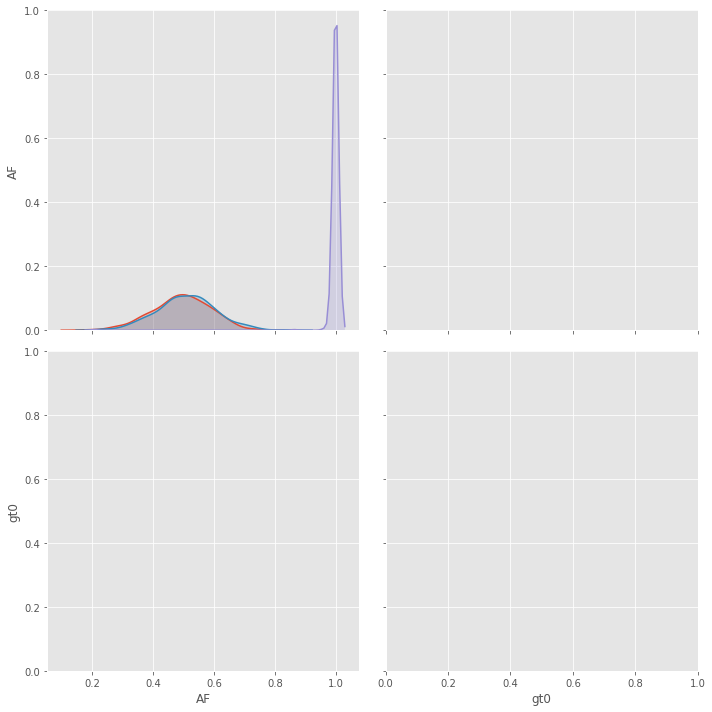

In [375]:
sns.pairplot(Ktest5, hue='category',size=5,vars=["AF","QD","SOR","dp", "MQ", "FS","GQ"],kind='scatter')

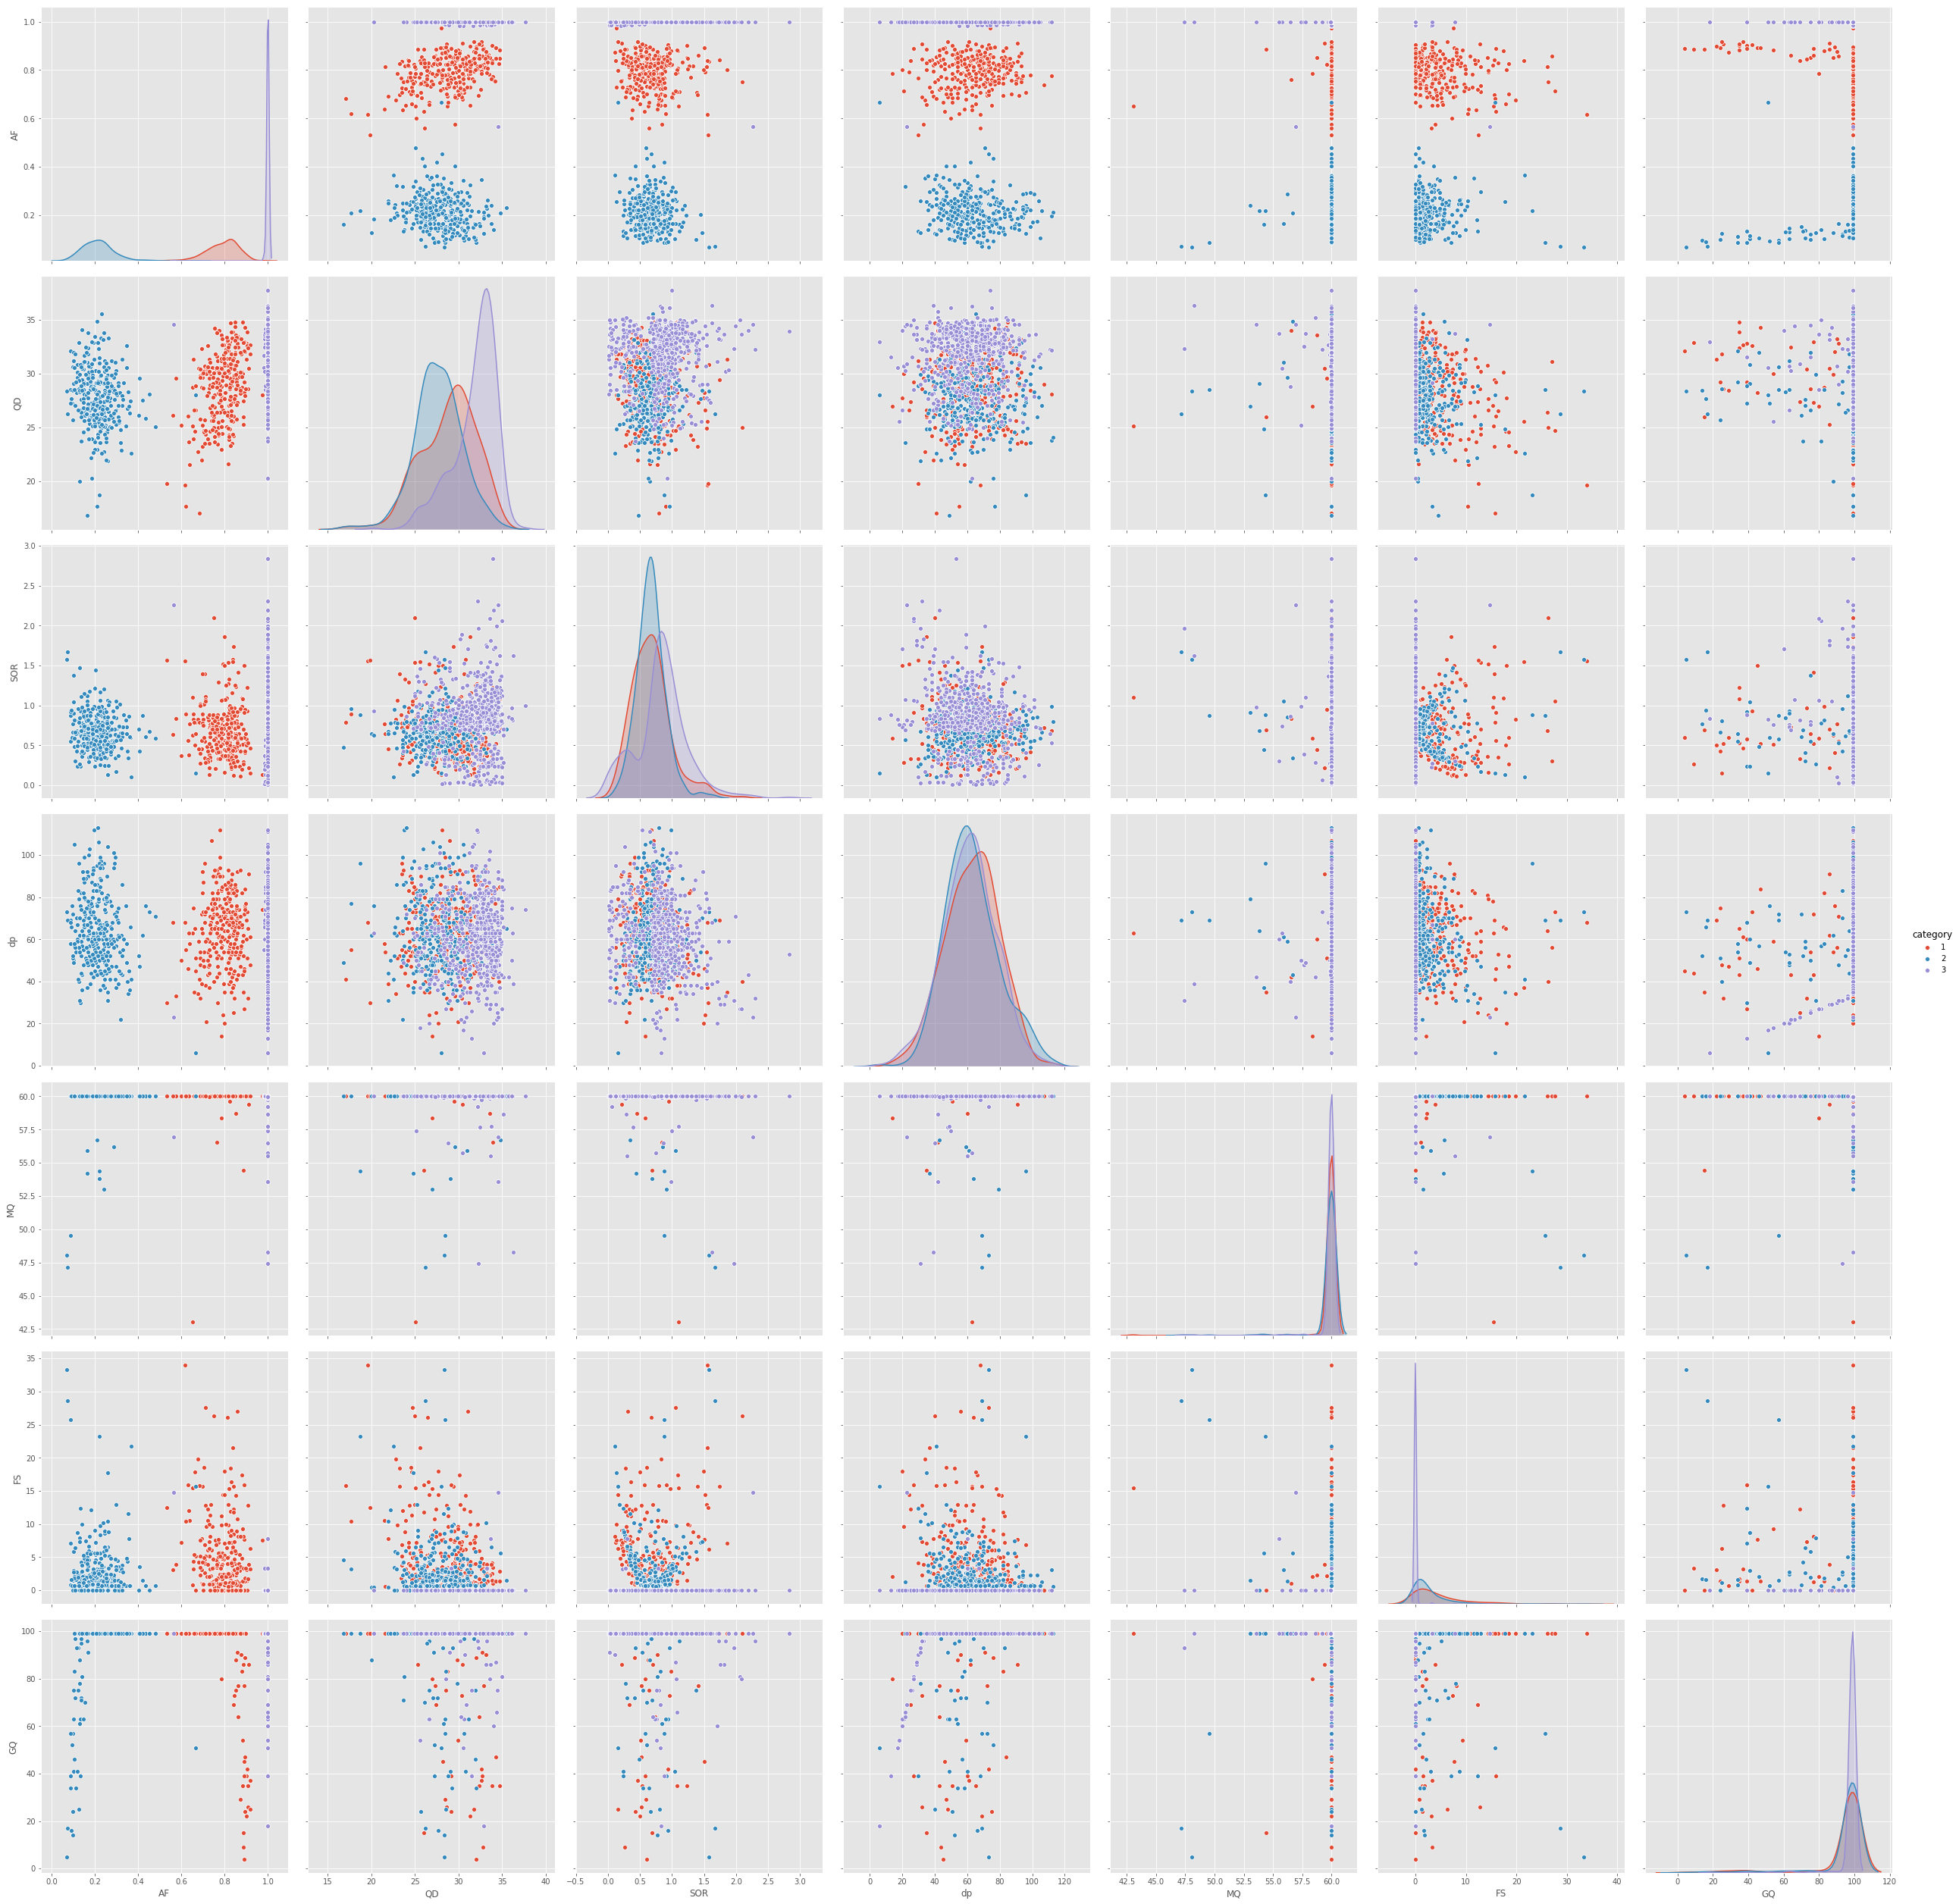

In [314]:
sns.pairplot(Ktest8, hue='category',size=5,vars=["AF","QD","SOR","dp", "MQ", "FS","GQ"],kind='scatter')

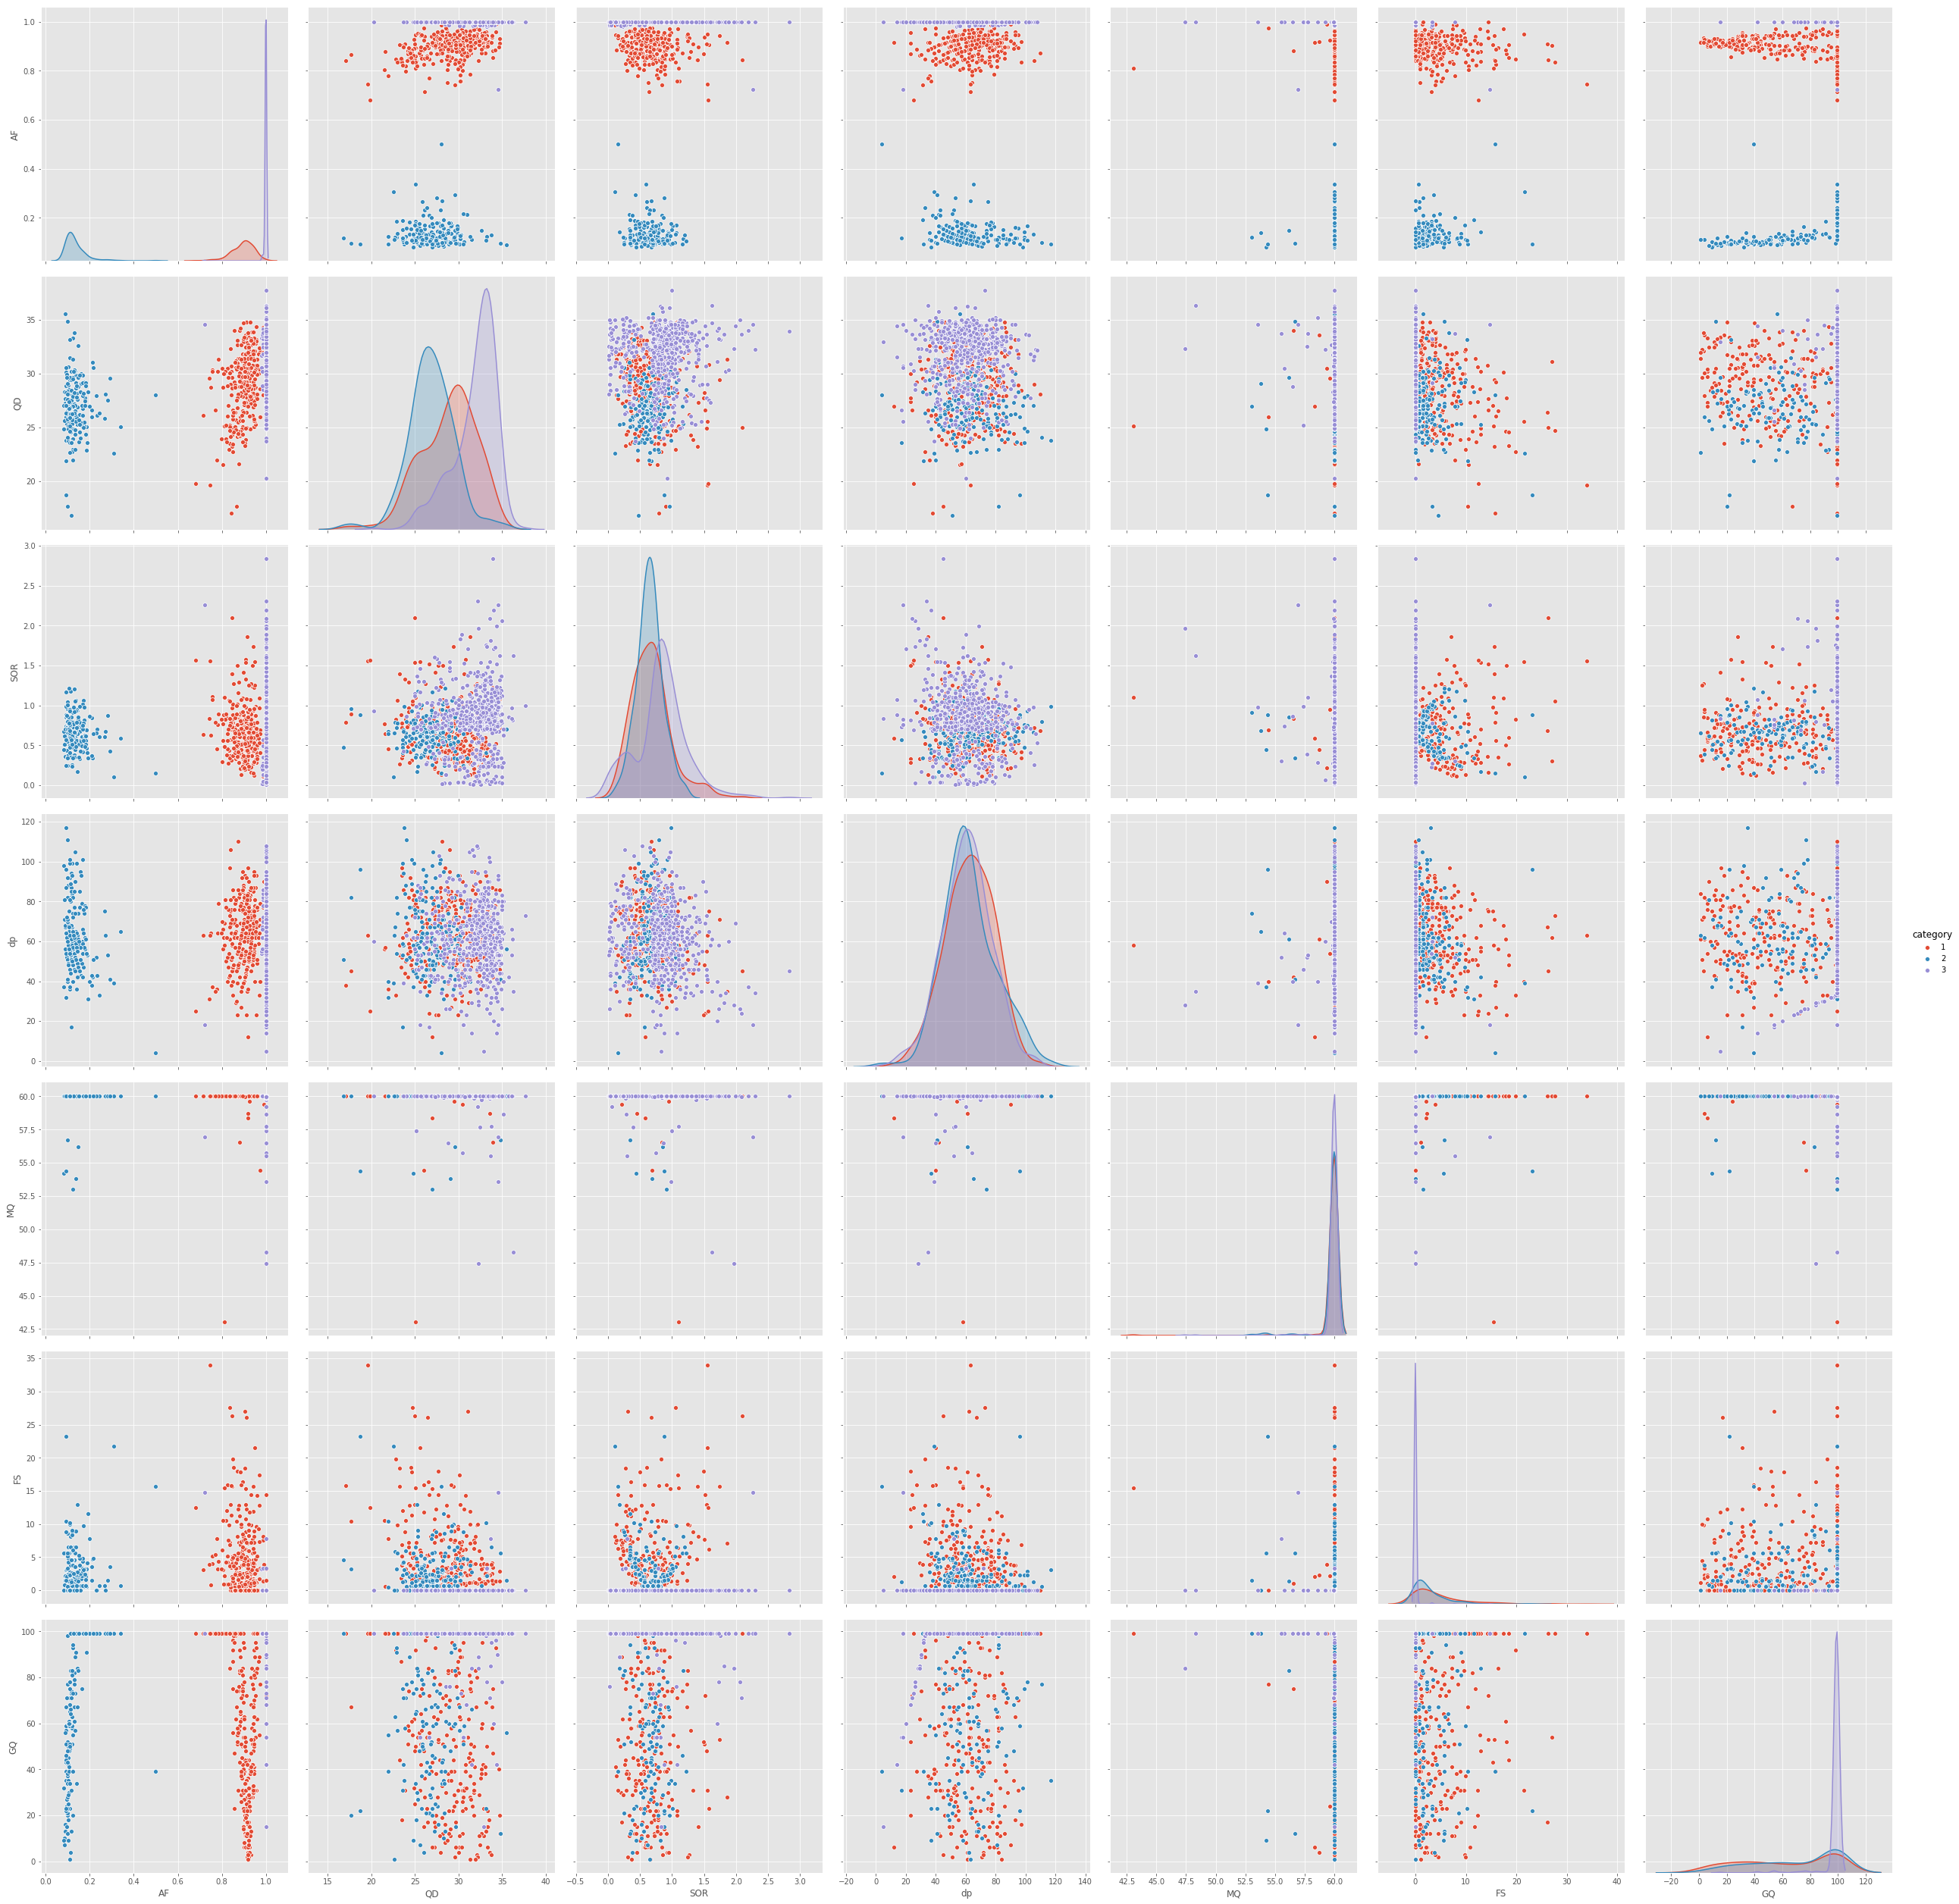

In [315]:
sns.pairplot(Ktest9, hue='category',size=5,vars=["AF","QD","SOR","dp", "MQ", "FS","GQ"],kind='scatter')

In [316]:
X = np.array(Ktest5[["AF","QD","FS"]])
y = np.array(Ktest5['category'])
X.shape

(1179, 3)

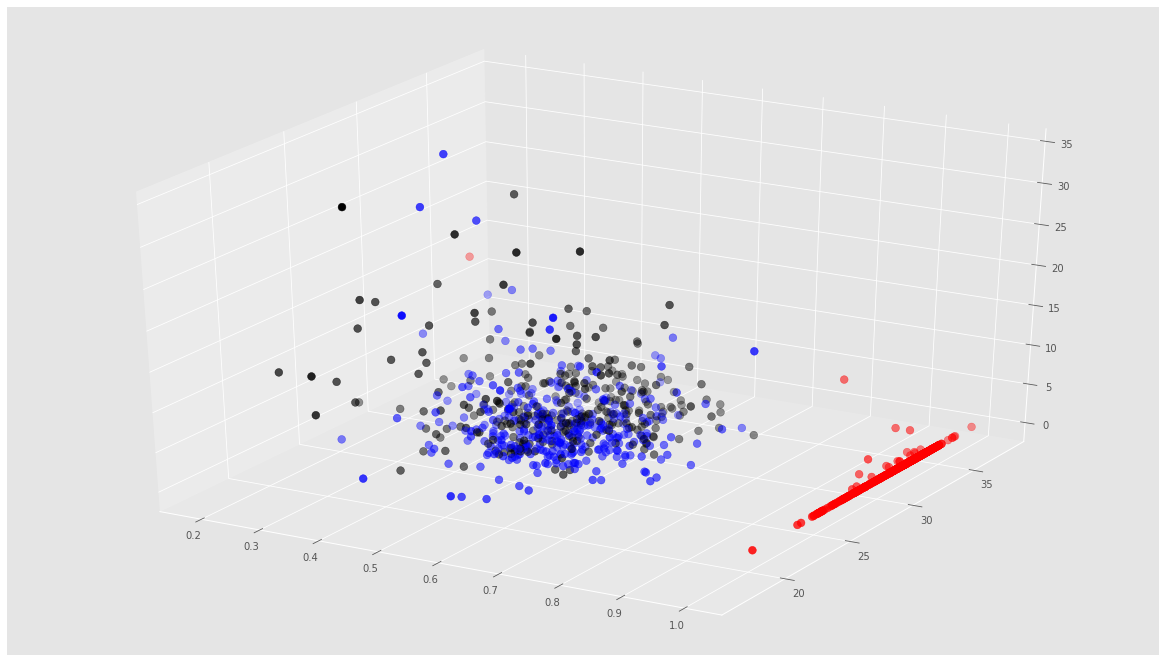

In [317]:
fig = plt.figure()
ax = Axes3D(fig)
colors=['black','blue','red','purple']
assign=[]
for row in y:
    assign.append(colors[row - 1])
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=assign,s=60)

In [318]:
X8 = np.array(Ktest8[["AF","QD","FS"]])
y8 = np.array(Ktest8['category'])
X8.shape

(1167, 3)

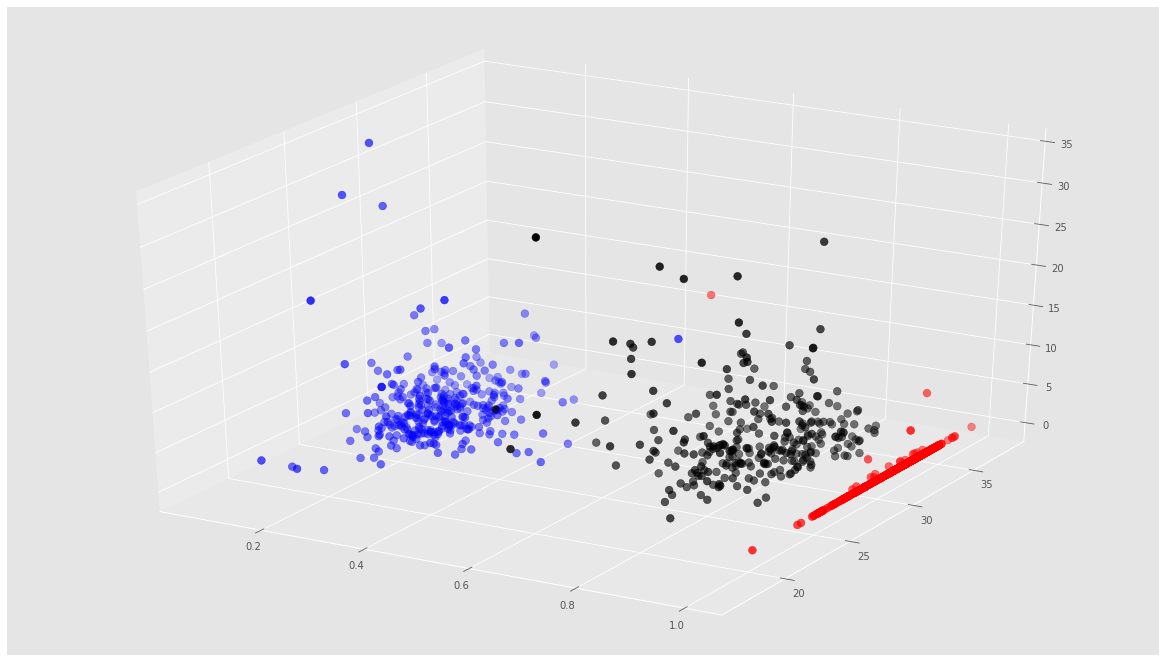

In [319]:
fig = plt.figure()
ax = Axes3D(fig)
colors=['black','blue','red','purple']
assign=[]
for row in y8:
    assign.append(colors[row - 1])
ax.scatter(X8[:, 0], X8[:, 1], X8[:, 2], c=assign,s=60)

In [320]:
X9 = np.array(Ktest9[["AF","QD","FS"]])
y9 = np.array(Ktest9['category'])
X9.shape

(1028, 3)

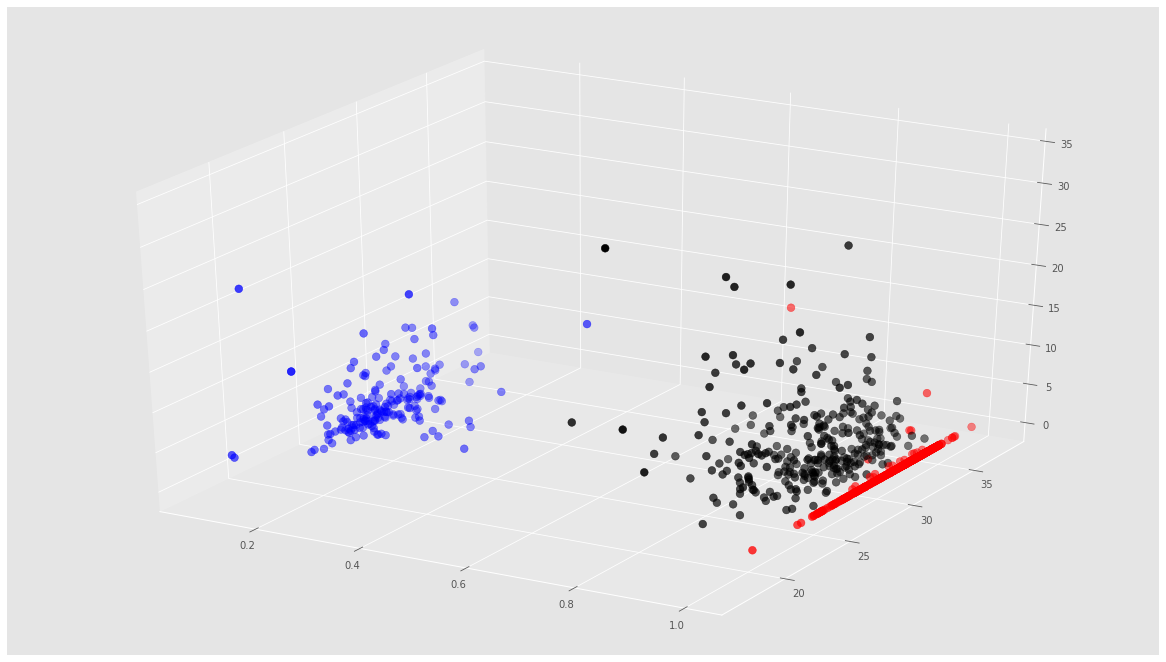

In [321]:
fig = plt.figure()
ax = Axes3D(fig)
colors=['black','blue','red','purple']
assign=[]
for row in y9:
    assign.append(colors[row - 1])
ax.scatter(X9[:, 0], X9[:, 1], X9[:, 2], c=assign,s=60)

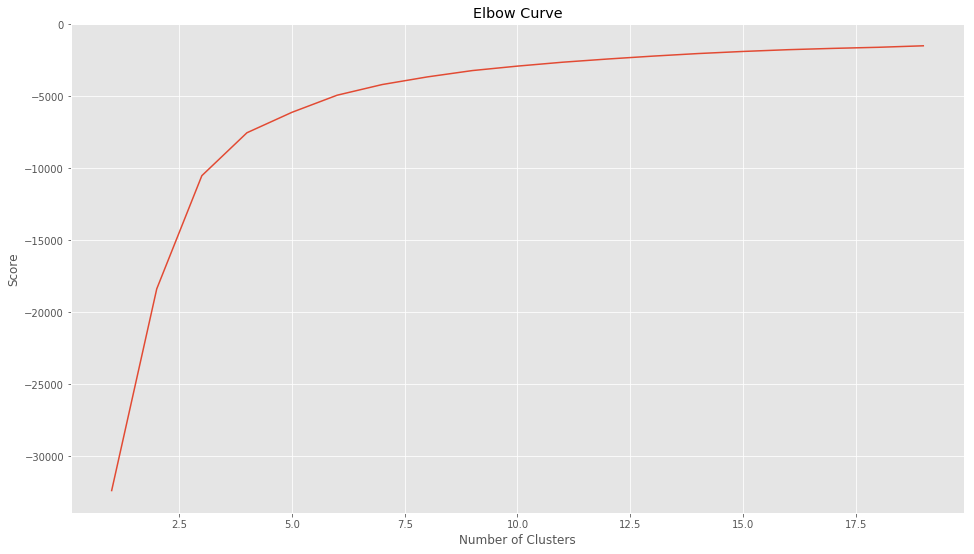

In [322]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [323]:
X = np.array(Ktest5[["AF","QD","FS", "MQ", "SOR"]])
y = np.array(Ktest5['category'])
X

array([[ 0.37037037, 30.57      ,  1.003     , 60.        ,  0.434     ],
       [ 1.        , 31.55      ,  0.        , 60.        ,  0.883     ],
       [ 0.62162162, 29.67      ,  0.919     , 60.        ,  0.827     ],
       ...,
       [ 0.60869565, 30.52      ,  4.826     , 60.        ,  0.643     ],
       [ 1.        , 30.71      ,  0.        , 59.95      ,  0.706     ],
       [ 1.        , 27.35      ,  0.        , 59.95      ,  0.73      ]])

In [324]:
X = StandardScaler().fit_transform(X)
X

array([[-1.37981881,  0.1915682 , -0.2454224 ,  0.12814637, -0.91626936],
       [ 1.06150453,  0.48799479, -0.49257028,  0.12814637,  0.37894582],
       [-0.40561824, -0.0806603 , -0.26612072,  0.12814637,  0.2174045 ],
       ...,
       [-0.45573734,  0.1764444 ,  0.6965979 ,  0.12814637, -0.3133741 ],
       [ 1.06150453,  0.23391486, -0.49257028,  0.0883118 , -0.13164012],
       [ 1.06150453, -0.78240486, -0.49257028,  0.0883118 , -0.06240813]])

In [325]:
kmeans = KMeans(n_clusters=3, max_iter=1000, init='k-means++').fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[  1.01933408   0.61237764  -0.48102538   0.08575887   0.22494289]
 [ -0.8689842   -0.52555585   0.36617922   0.06944279  -0.21840094]
 [ -0.96059017  -0.3330598    3.51137875 -10.01196596   1.64371173]]


In [326]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [327]:
X8 = np.array(Ktest8[["AF","QD","FS", "MQ", "SOR"]])
y8 = np.array(Ktest8['category'])
X8 = StandardScaler().fit_transform(X8)

X8.shape

(1167, 5)

In [328]:
kmeans8 = KMeans(n_clusters=3, max_iter=1000, init='k-means++').fit(X8)
centroids8 = kmeans8.cluster_centers_
print(centroids8)

[[  0.68960539   0.52608745  -0.35879409   0.06794117   0.13347704]
 [ -1.03213095  -0.78841494   0.4850649    0.07527515  -0.23155866]
 [ -0.90674132  -0.63303203   3.45840193 -10.26468062   1.65206648]]


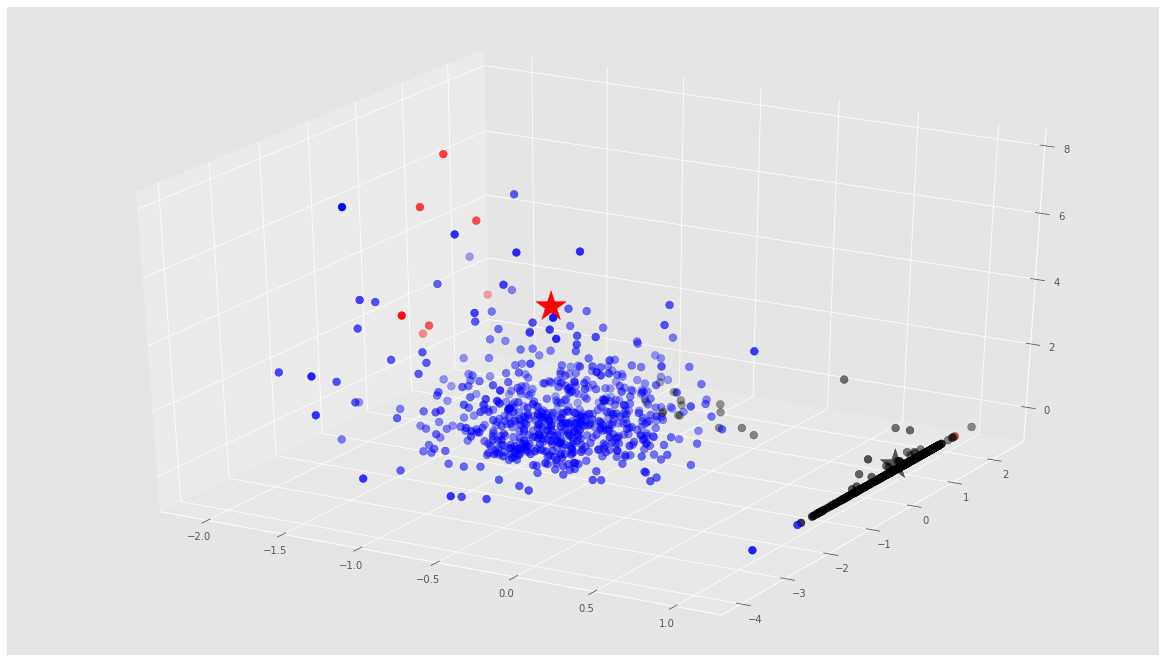

In [329]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colors=['black','blue','red']
assign=[]
for row in labels:
    assign.append(colors[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=assign,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colors, s=1000)

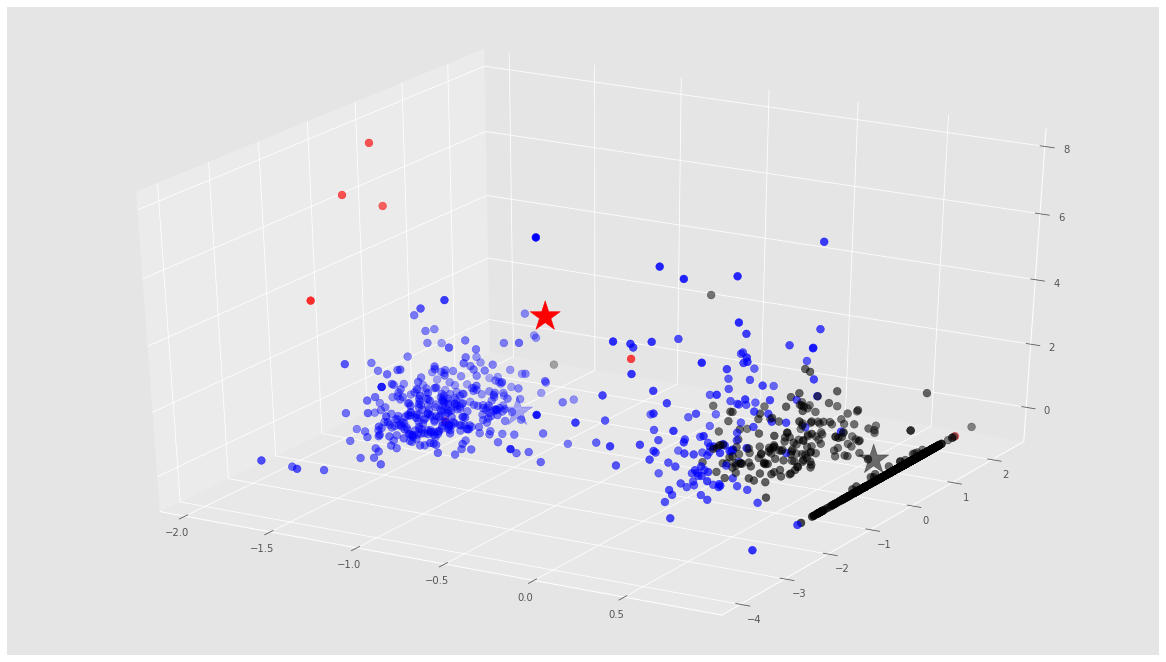

In [330]:
# Predicting the clusters
labels8 = kmeans8.predict(X8)
# Getting the cluster centers
C8 = kmeans8.cluster_centers_
colors=['black','blue','red']
assign=[]
for row in labels8:
    assign.append(colors[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X8[:, 0], X8[:, 1], X8[:, 2], c=assign,s=60)
ax.scatter(C8[:, 0], C8[:, 1], C8[:, 2], marker='*', c=colors, s=1000)

In [331]:
print(labels)

[1 0 1 ... 1 0 0]


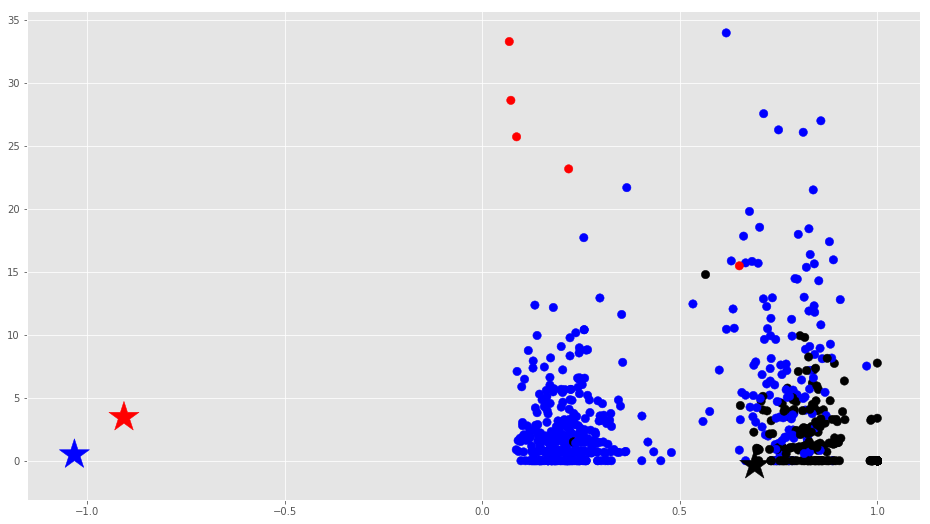

In [332]:
# Getting the values and plotting it
f1 = Ktest8['AF'].values
f2 = Ktest8['FS'].values

plt.scatter(f1, f2, c=assign, s=70)
plt.scatter(C8[:, 0], C8[:, 2], marker='*', c=colors, s=1000)
plt.show()

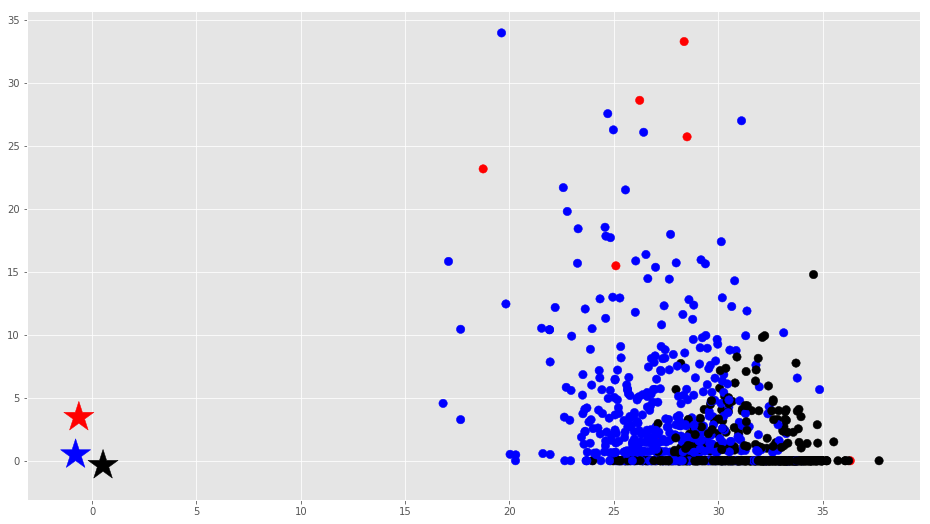

In [333]:
# Getting the values and plotting it
f1 = Ktest8['QD'].values
f2 = Ktest8['FS'].values

plt.scatter(f1, f2, c=assign, s=70)
plt.scatter(C8[:, 1], C8[:, 2], marker='*', c=colors, s=1000)
plt.show()

In [334]:
copy =  pd.DataFrame()
copy['POS']=Ktest8['POS'].values
copy['AF']=Ktest8['AF'].values
copy['category']=Ktest8['category'].values
copy['label'] = labels8;
Ngrouped =  pd.DataFrame()
Ngrouped['colors']=colors
Ngrouped['N']=copy.groupby('label').size()
Ngrouped

colors    N
0  black  700
1   blue  459
2    red    8

In [335]:
copy.head()

POS        AF  category  label
0  1977  0.761905         1      0
1  2532  1.000000         3      0
2  6140  0.173077         2      1
3  7585  0.694444         1      0
4  9143  1.000000         3      0

# Use more labels

In [336]:
W = np.array(Ktest8[["AF","QD","FS","MQ","SOR", "DP", "dp"]])
W

array([[ 0.76190476, 30.57      ,  1.003     , ...,  0.434     ,
        42.        , 42.        ],
       [ 1.        , 31.55      ,  0.        , ...,  0.883     ,
        13.        , 13.        ],
       [ 0.17307692, 29.67      ,  0.919     , ...,  0.827     ,
        52.        , 52.        ],
       ...,
       [ 0.34482759, 30.52      ,  4.826     , ...,  0.643     ,
        58.        , 58.        ],
       [ 1.        , 30.71      ,  0.        , ...,  0.706     ,
        43.        , 43.        ],
       [ 1.        , 27.35      ,  0.        , ...,  0.73      ,
        45.        , 45.        ]])

In [337]:
kmeansw = KMeans(n_clusters=3, max_iter=1000, verbose=0, init='k-means++').fit(W)
centroidsw = kmeansw.cluster_centers_
print(kmeansw)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [338]:
print(centroidsw)

[[ 0.71915471 29.68810398  1.54854434 59.92033639  0.706263   82.48012232
  82.4648318 ]
 [ 0.71806968 30.10900175  1.85642557 59.88588441  0.74711909 61.02977233
  61.02101576]
 [ 0.73217611 29.80669145  2.7755539  59.75442379  0.8169777  40.71375465
  40.70260223]]


In [339]:
labelsw = kmeansw.predict(W)


In [340]:
w =  pd.DataFrame()
w['POS']=Ktest8['POS'].values
w['AF']=Ktest8['AF'].values
w['category']=Ktest8['category'].values
w['label'] = labelsw;

In [341]:
labelsw

array([2, 2, 1, ..., 1, 2, 2], dtype=int32)

In [342]:
w.describe()

POS           AF     category        label
count  1.167000e+03  1167.000000  1167.000000  1167.000000
mean   2.169568e+06     0.721625     2.200514     0.950300
std    1.324884e+06     0.335829     0.821599     0.713216
min    1.977000e+03     0.068493     1.000000     0.000000
25%    1.044548e+06     0.292175     1.000000     0.000000
50%    2.135870e+06     0.854839     2.000000     1.000000
75%    3.283426e+06     1.000000     3.000000     1.000000
max    4.408923e+06     1.000000     3.000000     2.000000

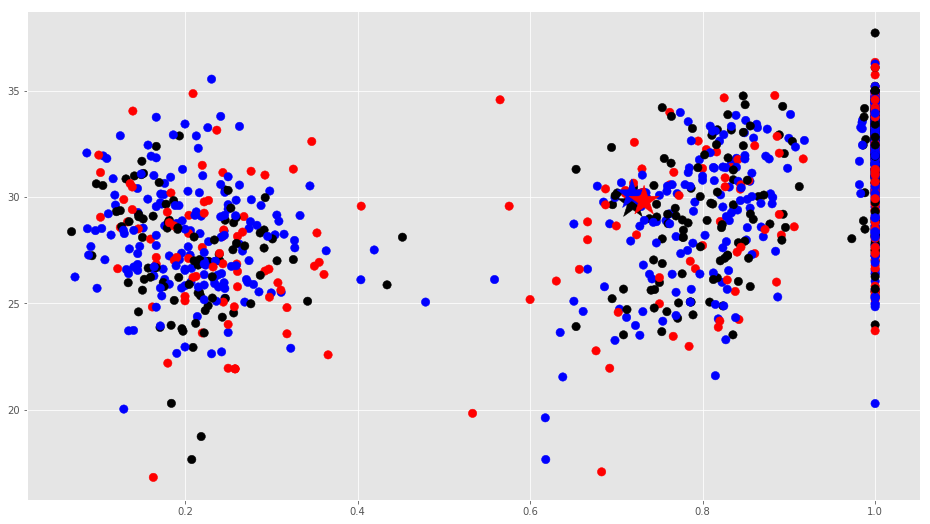

In [343]:
# Getting the values and plotting it
f1 = Ktest8['AF'].values
f2 = Ktest8['QD'].values


colors=['black','blue','red']
assign=[]
for row in labelsw:
    assign.append(colors[row])


plt.scatter(f1, f2, c=assign, s=70)
plt.scatter(centroidsw[:, 0], centroidsw[:, 1], marker='*', c=colors, s=1000)
plt.show()

In [344]:
 #metrics.adjusted_rand_score(labels_true, labels_pred)

# Compute Affinity Propagation

In [345]:
# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))


Estimated number of clusters: 61
Silhouette Coefficient: 0.255


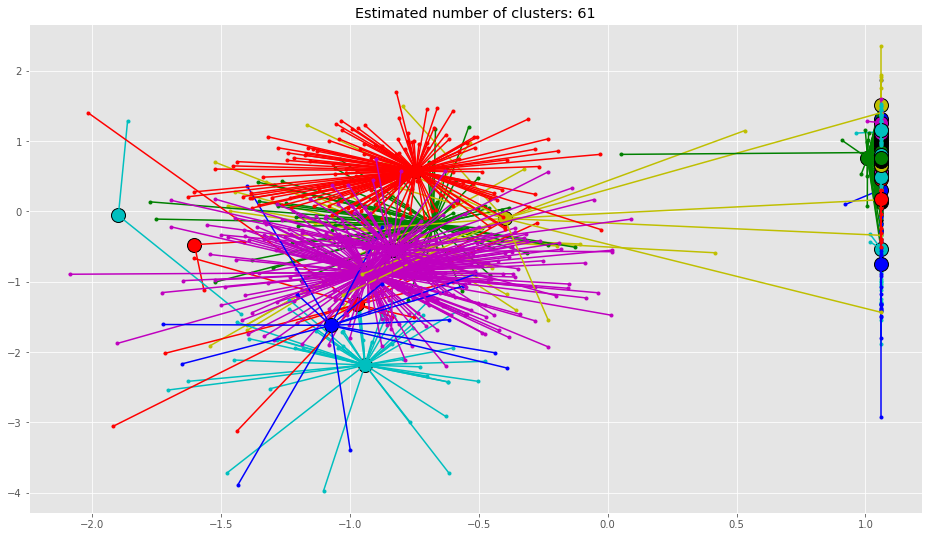

In [346]:

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Compute Agglomerative Clustering

In [347]:
ward = AgglomerativeClustering(n_clusters=3, linkage='ward') #connectivity=connectivity
ward.fit(X8)
#label = np.reshape(ward.labels_, rescaled_coins.shape)
labels = ward.labels_


In [348]:
Ktest8['Label'] = labels

/home/laura/env36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [349]:
#Ktest8[Ktest8.Label == 2]

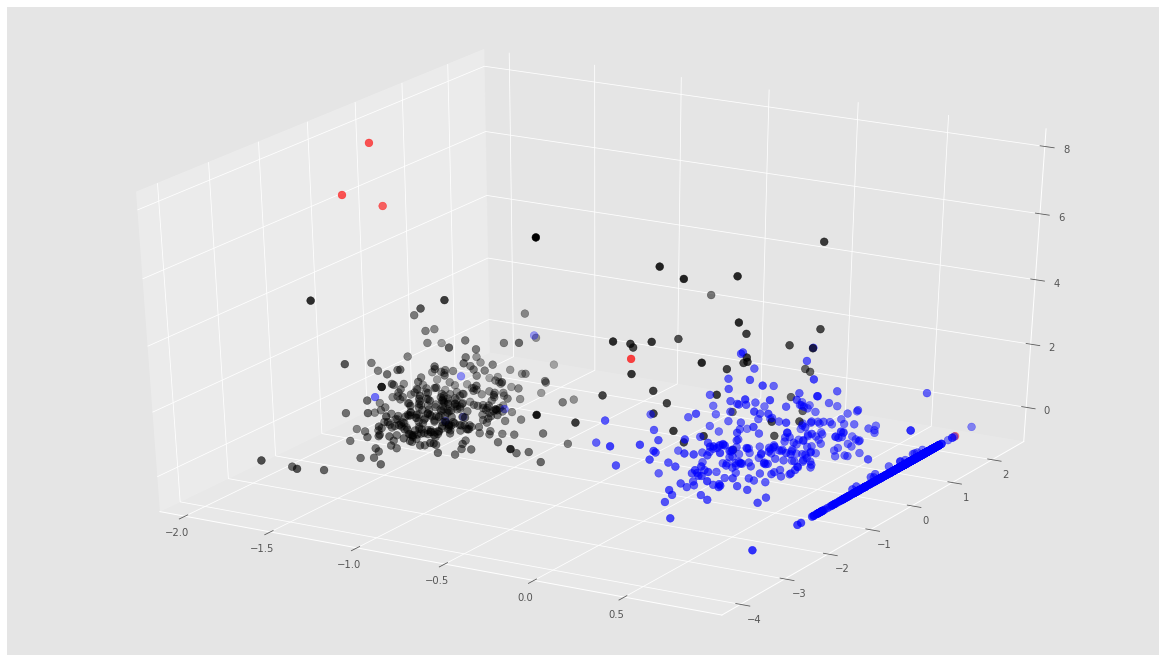

In [350]:
# Predicting the clusters

# Getting the cluster centers
colors=['black','blue','red']
assign=[]
for row in labels:
    assign.append(colors[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X8[:, 0], X8[:, 1], X8[:, 2], c=assign,s=60)


In [351]:
# #############################################################################
# Plot the results on an image
plt.figure(figsize=(5, 5))
#plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(label == l,
                colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
plt.xticks(())
plt.yticks(())
plt.show()

NameError: name 'n_clusters' is not defined

<Figure size 360x360 with 0 Axes>